## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 1
clip = 33
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

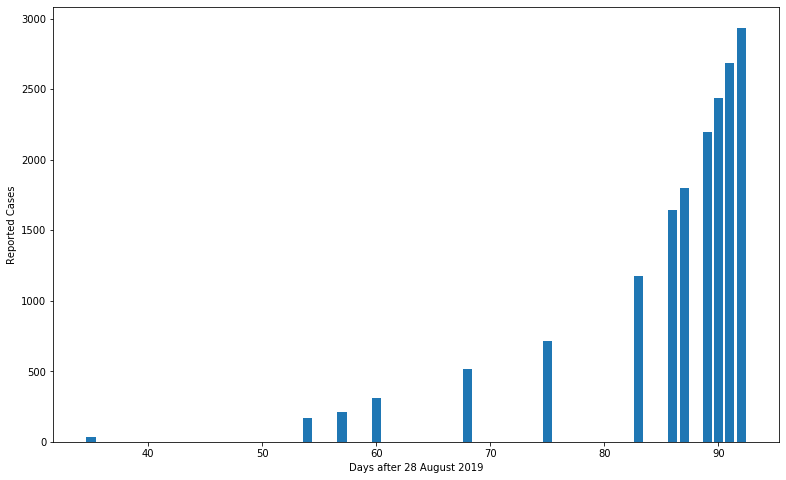

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

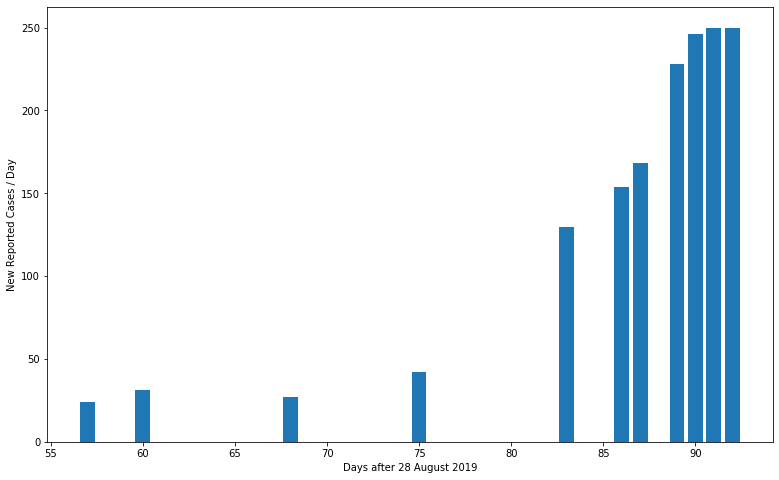

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

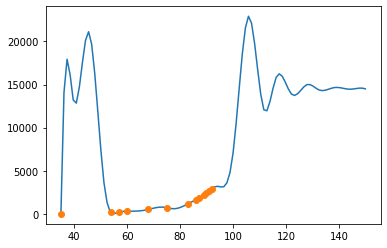

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [14]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 220  8.3883463e+00 0.00e+00 8.22e-04  -8.6 5.55e+02 -13.4 1.00e+00 5.00e-01h  2
 230  8.3883388e+00 0.00e+00 2.75e-04  -8.6 1.76e+02 -13.7 1.00e+00 1.00e+00h  1
 240  8.3883298e+00 0.00e+00 2.80e-04  -8.6 4.83e+02 -13.9 1.00e+00 1.00e+00h  1
 250  8.3883197e+00 0.00e+00 1.36e-04  -8.6 7.11e+02 -14.2 1.00e+00 1.00e+00f  1
 260  8.3883090e+00 0.00e+00 1.63e-03  -8.6 1.29e+03 -12.6 4.71e-01 4.28e-01f  1
 270  8.3881273e+00 0.00e+00 4.63e-03  -8.6 1.60e+04 -13.8 9.50e-02 6.10e-02f  1
 280  8.3877329e+00 0.00e+00 3.38e-05  -8.6 9.15e+02 -14.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 284

                                   (scaled)                 (unscaled)
Objective...............:   8.3877326316572081e+00    8.3877326316572081e+00
Dual infeasibility......:   1.7962738465873973e-09    1.7962738465873973e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.....

  60  8.3940016e+00 0.00e+00 6.16e-03  -8.6 6.56e+02 -13.5 1.00e+00 1.00e+00h  1
  70  8.3940154e+00 0.00e+00 2.23e-02  -8.6 1.31e+03 -12.9 1.00e+00 1.00e+00h  1
  80  8.3939943e+00 0.00e+00 3.46e-04  -8.6 4.01e+02 -14.9 1.00e+00 1.00e+00h  1
  90  8.3939940e+00 0.00e+00 6.34e-05  -8.6 4.83e+02 -15.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3939937e+00 0.00e+00 5.89e-05  -8.6 8.41e+01 -13.6 1.00e+00 1.00e+00h  1
 110  8.3939934e+00 0.00e+00 5.53e-04  -8.6 3.98e+02 -14.8 1.00e+00 1.00e+00h  1
 120  8.3939927e+00 0.00e+00 4.21e-05  -8.6 7.81e+01 -14.2 1.00e+00 1.00e+00h  1
 130  8.3939920e+00 0.00e+00 5.86e-04  -8.6 2.35e+02 -13.5 1.00e+00 1.00e+00h  1
 140  8.3939908e+00 0.00e+00 4.74e-03  -8.6 8.19e+02 -14.7 1.00e+00 1.00e+00h  1
 150  8.3939925e+00 0.00e+00 2.08e-02  -8.6 2.94e+03 -14.9 1.00e+00 5.00e-01h  2
 160  8.3996942e+00 0.00e+00 6.43e-01  -8.6 1.05e+03 -10.6 4.63e-01 3.98e-01f  1
 170  8.3939674e+00 0.00e+00

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4018245e+00 0.00e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.0243762e+01 0.00e+00 7.23e+00  -1.0 3.23e+04    -  8.47e-02 6.74e-02f  1
  20  8.6821429e+00 0.00e+00 5.99e-01  -2.5 5.16e+03    -  1.00e+00 1.00e+00f  1
  30  8.4659538e+00 0.00e+00 7.81e-04  -8.6 3.04e+01  -7.3 1.00e+00 1.00e+00f  1
  40  8.4110180e+00 0.00e+00 4.82e-01  -8.6 5.78e+03 -12.1 1.00e+00 1.00e+00f  1
 

 270  8.4108903e+00 0.00e+00 1.98e-03  -8.6 1.58e+03 -12.4 5.07e-01 1.50e-01h  1
 280  8.4105293e+00 0.00e+00 3.77e-03  -8.6 6.52e+02 -12.6 1.66e-02 7.11e-01f  1
 290  8.4086826e+00 0.00e+00 5.48e-03  -8.6 1.70e+03 -12.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.4085749e+00 0.00e+00 4.68e-06  -8.6 5.13e+02 -14.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 308

                                   (scaled)                 (unscaled)
Objective...............:   8.4085663502509611e+00    8.4085663502509611e+00
Dual infeasibility......:   2.8541819713466873e-09    2.8541819713466873e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060848449789053e-09    2.5060848449789053e-09
Overall NLP error.......:   2.8541819713466873e-09    2.8541819713466873e-09


Number of objective function evaluations             = 516
Number of objective gradient evaluations      

 100  8.4336459e+00 0.00e+00 2.78e-03  -8.6 2.48e+02 -12.8 1.00e+00 1.00e+00h  1
 110  8.4336167e+00 0.00e+00 2.01e-02  -8.6 3.11e+02 -11.7 1.00e+00 1.00e+00h  1
 120  8.4336021e+00 0.00e+00 1.73e-04  -8.6 5.42e+01 -12.3 1.00e+00 1.00e+00h  1
 130  8.4335943e+00 0.00e+00 2.34e-04  -8.6 1.22e+02 -12.9 1.00e+00 1.00e+00h  1
 140  8.4335858e+00 0.00e+00 5.38e-03  -8.6 2.25e+04    -  1.00e+00 6.25e-02h  5
 150  8.4335807e+00 0.00e+00 2.72e-04  -8.6 9.78e+02 -14.6 1.00e+00 1.00e+00h  1
 160  8.4335720e+00 0.00e+00 1.52e-03  -8.6 6.38e+02 -13.9 1.00e+00 1.00e+00h  1
 170  8.4335037e+00 0.00e+00 9.18e-04  -8.6 2.12e+02 -13.3 1.00e+00 1.00e+00f  1
 180  8.4334500e+00 0.00e+00 6.12e-03  -8.6 1.30e+03 -14.0 1.00e+00 1.00e+00h  1
 190  8.4333362e+00 0.00e+00 5.95e-03  -8.6 1.62e+04 -14.2 1.42e-03 2.97e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.4331997e+00 0.00e+00 1.12e-02  -8.6 9.38e+03 -11.8 7.75e-02 2.55e-02f  2
 210  8.4318402e+00 0.00e+00

 120  8.4729197e+00 0.00e+00 1.64e-02  -8.6 1.27e+04    -  5.78e-01 1.25e-01h  4
 130  8.4729035e+00 0.00e+00 1.24e-02  -8.6 1.43e+04    -  1.00e+00 1.25e-01h  4
 140  8.4728874e+00 0.00e+00 2.35e-04  -8.6 6.15e+01 -13.1 1.00e+00 1.00e+00f  1
 150  8.4728554e+00 0.00e+00 7.21e-04  -8.6 9.11e+02 -13.4 1.00e+00 1.00e+00f  1
 160  8.4727165e+00 0.00e+00 7.63e-03  -8.6 1.95e+02 -11.8 1.00e+00 1.00e+00h  1
 170  8.4726726e+00 0.00e+00 2.03e-02  -8.6 1.03e+03 -13.0 1.00e+00 5.00e-01h  2
 180  8.4724475e+00 0.00e+00 6.59e-03  -8.6 2.01e+02 -12.4 1.00e+00 1.00e+00f  1
 190  8.4718987e+00 0.00e+00 1.30e-03  -8.6 2.39e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.4662134e+00 0.00e+00 5.28e-03  -8.6 1.86e+02  -8.3 2.92e-01 4.51e-01f  2
 210  8.4653744e+00 0.00e+00 7.38e-03  -8.6 5.82e+02 -13.1 9.70e-01 5.00e-01f  2
 220  8.4653508e+00 0.00e+00 6.40e-05  -8.6 5.94e+01 -12.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 2

  10  1.0653828e+01 0.00e+00 7.87e-03  -1.0 7.84e-01  -4.0 9.98e-01 1.00e+00f  1
  20  8.8218454e+00 0.00e+00 1.89e-03  -5.7 1.67e+01  -6.4 1.00e+00 1.00e+00f  1
  30  8.5619200e+00 0.00e+00 3.62e-01  -5.7 8.65e+02 -10.3 1.00e+00 1.00e+00f  1
  40  8.5422010e+00 0.00e+00 2.31e-02  -5.7 1.52e+02 -11.4 1.00e+00 1.00e+00f  1
  50  8.5418939e+00 0.00e+00 8.23e-02  -5.7 2.37e+04    -  7.30e-01 1.25e-01f  4
  60  8.5418356e+00 0.00e+00 2.61e-04  -5.7 1.26e+02 -12.4 1.00e+00 1.00e+00h  1
  70  8.5418120e+00 0.00e+00 3.84e-04  -5.7 4.10e+01 -12.0 1.00e+00 1.00e+00h  1
  80  8.5417898e+00 0.00e+00 1.42e-04  -5.7 2.22e+01 -11.7 1.00e+00 1.00e+00h  1
  90  8.5417590e+00 0.00e+00 7.26e-03  -5.7 3.09e+02 -14.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.5417444e+00 0.00e+00 7.66e-03  -5.7 4.07e+03    -  1.00e+00 5.00e-01h  2
 110  8.5417294e+00 0.00e+00 2.05e-02  -8.6 1.97e+04    -  6.76e-01 2.41e-02h  6
 120  8.5416800e+00 0.00e+00

  60  8.6606073e+00 0.00e+00 1.33e-01  -5.7 1.44e+04    -  1.00e+00 2.50e-01f  3
  70  8.6604676e+00 0.00e+00 2.34e-02  -5.7 9.85e+02 -13.8 1.00e+00 5.00e-01h  2
  80  8.6604214e+00 0.00e+00 3.83e-02  -5.7 8.19e+03    -  1.00e+00 2.50e-01h  3
  90  8.6603944e+00 0.00e+00 4.54e-03  -5.7 4.14e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.6603585e+00 0.00e+00 3.20e-02  -8.6 2.73e+04    -  1.00e+00 6.25e-02h  5
 110  8.6603411e+00 0.00e+00 3.91e-03  -8.6 2.68e+02 -12.2 1.00e+00 1.00e+00F  1
 120  8.6602835e+00 0.00e+00 6.35e-02  -8.6 1.78e+03 -12.4 1.00e+00 2.50e-01h  3
 130  8.6600186e+00 0.00e+00 6.80e-02  -8.6 2.81e+03 -13.6 1.00e+00 5.00e-01f  2
 140  8.6596422e+00 0.00e+00 5.68e-03  -8.6 4.10e+02 -12.9 1.00e+00 1.00e+00f  1
 150  8.6591179e+00 0.00e+00 1.72e-02  -8.6 1.30e+02 -11.4 1.00e+00 1.00e+00f  1
 160  8.6583582e+00 0.00e+00 3.05e-02  -8.6 8.18e+02 -12.5 1.05e-01 3.06e-01f  1
 170  8.6511055e+00 0.00e+00

  50  8.8667757e+00 0.00e+00 5.89e-02  -5.7 3.61e+03 -13.0 1.00e+00 5.00e-01f  2
  60  8.8665886e+00 0.00e+00 7.22e-03  -5.7 1.80e+02 -12.7 1.00e+00 1.00e+00h  1
  70  8.8664986e+00 0.00e+00 2.24e-02  -5.7 2.01e+04 -13.9 1.00e+00 1.25e-01h  4
  80  8.8664304e+00 0.00e+00 3.21e-03  -5.7 1.16e+02 -13.1 1.00e+00 1.00e+00h  1
  90  8.8663976e+00 0.00e+00 2.66e-02  -5.7 2.14e+03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.8663757e+00 0.00e+00 6.33e-04  -5.7 5.10e+02    -  1.00e+00 1.00e+00h  1
 110  8.8663427e+00 0.00e+00 8.86e-02  -8.6 5.94e+02 -12.6 1.00e+00 5.00e-01f  2
 120  8.8661929e+00 0.00e+00 3.67e-03  -8.6 6.46e+01 -10.2 1.00e+00 1.00e+00h  1
 130  8.8655303e+00 0.00e+00 4.01e-02  -8.6 7.58e+02 -10.4 8.51e-01 2.50e-01f  3
 140  8.8652042e+00 0.00e+00 2.08e-02  -8.6 2.83e+02 -10.7 5.60e-01 9.63e-02f  4
 150  8.8645648e+00 0.00e+00 2.44e-02  -8.6 1.67e+02 -11.9 1.00e+00 1.00e+00f  1
 160  8.8626511e+00 0.00e+00

  70  9.2187427e+00 0.00e+00 9.70e-02  -5.7 1.08e+03 -12.6 1.00e+00 1.00e+00f  1
  80  9.2170700e+00 0.00e+00 5.16e-02  -5.7 2.27e+02  -9.2 1.00e+00 5.00e-01f  2
  90  9.2109377e+00 0.00e+00 9.17e-02  -5.7 1.97e+02  -8.6 5.95e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.1602829e+00 0.00e+00 7.39e-02  -5.7 3.03e+03 -10.2 1.19e-02 2.76e-03f  1
 110  9.1549321e+00 0.00e+00 6.01e-04  -5.7 8.30e+01 -11.8 1.00e+00 1.00e+00f  1
 120  9.1549589e+00 0.00e+00 3.01e-03  -5.7 1.15e+03 -13.7 1.00e+00 1.00e+00h  1
 130  9.1549589e+00 0.00e+00 1.76e-08  -5.7 3.33e+00    -  1.00e+00 1.00e+00h  1
 140  9.1549232e+00 0.00e+00 9.24e-03  -8.6 2.62e+03 -14.9 1.00e+00 1.00e+00h  1
 150  9.1548965e+00 0.00e+00 2.72e-04  -8.6 1.20e+02 -12.0 1.00e+00 1.00e+00h  1
 160  9.1548018e+00 0.00e+00 2.08e-04  -8.6 5.94e+01 -11.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 167

                                   (scaled)                 (unscaled)
Object

  10  1.4292646e+01 0.00e+00 8.15e-02  -1.0 4.88e+00  -4.0 9.97e-01 1.00e+00f  1
  20  9.9993251e+00 0.00e+00 1.02e-02  -5.7 3.10e+01  -6.4 1.00e+00 1.00e+00f  1
  30  9.8224967e+00 0.00e+00 1.53e-01  -5.7 5.26e+03 -10.3 8.86e-01 3.16e-01f  2
  40  9.6904570e+00 0.00e+00 8.98e-01  -5.7 3.29e+04 -12.3 2.48e-02 5.14e-02f  1
  50  9.4886827e+00 0.00e+00 9.28e-02  -5.7 1.61e+02  -9.0 1.00e+00 4.48e-02f  1
  60  9.4829767e+00 0.00e+00 5.83e-06  -5.7 1.57e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   9.4829119792545615e+00    9.4829119792545615e+00
Dual infeasibility......:   1.0688219786896212e-10    1.0688219786896212e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059043868642614e-09    2.5059043868642614e-09
Overall NLP error.......:   2.5059043868642614e-09    2.5059043868642614e-09


Number of objective funct

  10  2.3642395e+01 0.00e+00 8.32e+01  -1.0 7.77e+03    -  4.51e-01 5.76e-01f  1
  20  1.4374321e+01 0.00e+00 6.29e+01  -1.7 1.86e+04    -  7.12e-01 5.00e-01f  2
  30  1.1734553e+01 0.00e+00 1.12e-01  -2.5 1.87e+03 -10.2 1.00e+00 1.00e+00f  1
  40  1.1758392e+01 0.00e+00 6.75e-01  -2.5 6.11e+02  -9.9 1.00e+00 1.00e+00f  1
  50  1.1760240e+01 0.00e+00 2.15e+00  -2.5 5.33e+02  -9.7 1.00e+00 1.00e+00f  1
  60  1.1765999e+01 0.00e+00 3.20e+00  -2.5 7.82e+03 -11.2 1.00e+00 1.25e-01f  4
  70  1.1771764e+01 0.00e+00 9.95e-02  -2.5 1.70e+02    -  1.00e+00 1.00e+00h  1
  80  1.1595027e+01 0.00e+00 1.08e+00  -3.8 2.21e+03 -11.9 1.00e+00 1.00e+00f  1
  90  1.1582556e+01 0.00e+00 1.43e+00  -3.8 1.13e+03 -12.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1578893e+01 0.00e+00 2.21e-02  -3.8 8.25e+01 -11.4 1.00e+00 1.00e+00f  1
 110  1.1574885e+01 0.00e+00 2.67e-01  -5.7 2.49e+02 -10.7 1.00e+00 1.00e+00f  1
 120  1.1573640e+01 0.00e+00

  40  1.2252133e+01 0.00e+00 1.19e+00  -3.8 3.97e+02  -9.2 1.00e+00 6.14e-01f  1
  50  1.2182892e+01 0.00e+00 1.64e-03  -5.7 7.31e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   1.2182758855427503e+01    1.2182758855427503e+01
Dual infeasibility......:   1.1604400000497497e-09    1.1604400000497497e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5127442671631340e-09    2.5127442671631340e-09
Overall NLP error.......:   2.5127442671631340e-09    2.5127442671631340e-09


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 65
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 60
Num

Total CPU secs in NLP function evaluations           =      0.152

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.96ms ( 27.01us)  13.03ms ( 27.15us)       480
       nlp_g  |   6.64ms ( 13.83us)   6.60ms ( 13.74us)       480
    nlp_grad  |  63.00us ( 63.00us)  62.54us ( 62.54us)         1
  nlp_grad_f  |  16.16ms ( 55.34us)  16.24ms ( 55.61us)       292
  nlp_hess_l  | 109.81ms (378.64us) 110.23ms (380.12us)       290
   nlp_jac_g  |   5.18ms ( 17.75us)   5.23ms ( 17.90us)       292
       total  | 756.60ms (756.60ms) 755.05ms (755.05ms)         1
Solving for p=0.0024770763559917113
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Tot

 140  2.9197427e+01 0.00e+00 6.43e+02  -2.5 2.31e+04    -  6.39e-01 2.50e-01f  3
 150  2.8417706e+01 0.00e+00 1.94e+02  -2.5 8.47e+02  -9.1 1.00e+00 1.00e+00f  1
 160  2.7858341e+01 0.00e+00 2.03e+02  -2.5 6.49e+03 -11.1 7.78e-01 1.00e+00f  1
 170  2.7700891e+01 0.00e+00 5.92e+01  -2.5 1.23e+04    -  8.19e-01 2.50e-01f  3
 180  2.7657156e+01 0.00e+00 2.12e+02  -3.8 3.54e+04    -  4.09e-01 2.09e-01f  3
 190  2.7519598e+01 0.00e+00 2.26e+01  -3.8 1.01e+03  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.7383803e+01 0.00e+00 1.51e+01  -3.8 1.33e+03  -8.7 1.00e+00 1.00e+00f  1
 210  2.3513512e+01 0.00e+00 8.07e+00  -3.8 7.08e+03  -9.8 4.00e-01 2.24e-01f  2
 220  2.3175092e+01 0.00e+00 1.47e+00  -3.8 5.43e+03 -11.9 1.00e+00 1.00e+00f  1
 230  2.3112010e+01 0.00e+00 7.56e+00  -3.8 5.83e+03 -11.3 1.00e+00 5.00e-01f  2
 240  2.2854510e+01 0.00e+00 1.04e+01  -3.8 1.75e+03  -9.7 1.00e+00 1.00e+00f  1
 250  1.9015315e+01 0.00e+00

  50  3.2809245e+01 0.00e+00 3.07e+01  -1.7 6.71e+04 -10.0 1.72e-01 2.66e-02f  5
  60  3.3052036e+01 0.00e+00 1.52e+01  -1.7 4.11e+02  -8.8 1.00e+00 1.00e+00f  1
  70  3.3093303e+01 0.00e+00 3.41e+00  -1.7 1.43e+02  -8.5 1.00e+00 1.00e+00f  1
  80  3.3060337e+01 0.00e+00 3.27e+01  -1.7 1.58e+03    -  1.00e+00 1.00e+00f  1
  90  3.2431303e+01 0.00e+00 1.19e+01  -3.8 4.67e+03 -10.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2353186e+01 0.00e+00 4.03e+00  -3.8 1.81e+03 -11.2 1.00e+00 1.00e+00f  1
 110  3.2217091e+01 0.00e+00 1.36e+01  -3.8 2.35e+03 -10.6 1.00e+00 1.00e+00f  1
 120  3.1796687e+01 0.00e+00 1.19e+01  -3.8 1.04e+03  -9.9 1.00e+00 1.00e+00f  1
 130  2.8789411e+01 0.00e+00 6.20e+00  -3.8 4.87e+02  -8.4 1.00e+00 1.00e+00f  1
 140  2.4067751e+01 0.00e+00 2.09e-01  -3.8 1.81e+02  -9.0 1.00e+00 1.00e+00f  1
 150  2.4052566e+01 0.00e+00 4.59e-01  -3.8 1.61e+03 -11.4 1.00e+00 1.00e+00f  1
 160  2.4044661e+01 0.00e+00

  70  4.6670850e+01 0.00e+00 2.14e+03  -1.7 1.17e+03  -8.2 1.00e+00 1.00e+00f  1
  80  4.4137863e+01 0.00e+00 2.04e+01  -1.7 1.05e+02  -7.1 1.00e+00 1.00e+00f  1
  90  4.1807957e+01 0.00e+00 7.40e+01  -1.7 1.46e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0552150e+01 0.00e+00 9.78e+01  -1.7 4.99e+02  -8.3 1.00e+00 1.00e+00f  1
 110  3.9964032e+01 0.00e+00 5.15e+01  -1.7 3.69e+03 -10.3 1.00e+00 1.00e+00f  1
 120  4.0087558e+01 0.00e+00 3.46e-01  -1.7 1.90e+01  -7.3 1.00e+00 1.00e+00f  1
 130  3.9571448e+01 0.00e+00 5.24e-01  -2.5 9.40e+01  -8.4 1.00e+00 1.00e+00f  1
 140  3.9509523e+01 0.00e+00 6.92e-01  -2.5 4.51e+02 -10.8 1.00e+00 1.00e+00f  1
 150  3.9435447e+01 0.00e+00 1.16e+01  -2.5 2.61e+03    -  1.00e+00 5.00e-01f  2
 160  3.9352419e+01 0.00e+00 1.23e+01  -2.5 9.15e+03    -  1.00e+00 1.25e-01f  4
 170  3.9206221e+01 0.00e+00 4.13e+00  -2.5 1.92e+05    -  3.22e-01 2.06e-02f  5
 180  3.8941261e+01 0.00e+00

  60  4.6814434e+01 0.00e+00 3.11e+02  -1.7 2.12e+02  -8.0 1.00e+00 1.00e+00f  1
  70  4.6956703e+01 0.00e+00 4.45e+01  -1.7 1.18e+03  -9.5 1.00e+00 1.00e+00f  1
  80  4.7299876e+01 0.00e+00 1.35e+02  -1.7 2.45e+04    -  8.28e-01 6.25e-02f  5
  90  4.7432002e+01 0.00e+00 1.34e+02  -1.7 3.43e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7472850e+01 0.00e+00 5.29e+00  -1.7 4.35e+02  -9.0 1.00e+00 1.00e+00f  1
 110  4.7649391e+01 0.00e+00 5.12e+01  -1.7 5.67e+02  -8.3 1.00e+00 2.50e-01f  3
 120  4.7305651e+01 0.00e+00 2.27e+01  -2.5 3.65e+03 -10.3 1.00e+00 1.25e-01f  4
 130  4.7142697e+01 0.00e+00 2.87e+01  -2.5 2.30e+04 -10.9 1.00e+00 6.25e-02f  5
 140  4.7000747e+01 0.00e+00 3.52e+01  -2.5 2.16e+03 -11.2 1.00e+00 5.00e-01f  2
 150  4.6730790e+01 0.00e+00 4.09e+01  -2.5 7.88e+01  -7.8 1.00e+00 1.00e+00f  1
 160  4.6384536e+01 0.00e+00 1.24e+02  -2.5 4.13e+03 -10.8 1.00e+00 1.00e+00f  1
 170  4.5846615e+01 0.00e+00

  20  4.0906336e+01 0.00e+00 3.58e+00  -3.8 1.80e+04    -  1.00e+00 5.00e-01f  2
  30  4.0893923e+01 0.00e+00 1.37e-01  -8.6 2.17e+04    -  7.85e-01 1.00e+00f  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   4.0893918407015235e+01    4.0893918407015235e+01
Dual infeasibility......:   6.6199200949464344e-09    6.6199200949464344e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059128310288908e-09    2.5059128310288908e-09
Overall NLP error.......:   6.6199200949464344e-09    6.6199200949464344e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Num


Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   5.6569183566790720e+01    5.6569183566790720e+01
Dual infeasibility......:   8.6847473886985789e-10    8.6847473886985789e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.4798561011252854e-09    3.4798561011252854e-09
Overall NLP error.......:   3.4798561011252854e-09    3.4798561011252854e-09


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 29
Number of Lagrangian Hessian evaluations             = 28
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluation

  30  7.1482547e+01 0.00e+00 1.57e-03  -2.5 3.49e+01    -  1.00e+00 1.00e+00h  1
  40  7.1426681e+01 0.00e+00 1.08e-02  -5.7 7.34e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   7.1426562615489516e+01    7.1426562615489516e+01
Dual infeasibility......:   1.4541582575711371e-09    1.4541582575711371e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9080283142803458e-09    2.9080283142803458e-09
Overall NLP error.......:   2.9080283142803458e-09    2.9080283142803458e-09


Number of objective function evaluations             = 72
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 72
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Num

  90  1.0699619e+02 0.00e+00 2.15e+01  -1.7 1.53e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0754260e+02 0.00e+00 1.98e+01  -1.7 1.08e+02 -11.1 1.00e+00 1.00e+00f  1
 110  1.0809387e+02 0.00e+00 4.72e+01  -1.7 1.34e+02 -11.2 1.00e+00 1.00e+00f  1
 120  1.0868529e+02 0.00e+00 2.10e+01  -1.7 1.29e+02  -8.2 1.00e+00 1.00e+00f  1
 130  1.0904325e+02 0.00e+00 2.96e+01  -1.7 1.13e+02  -9.3 1.00e+00 1.00e+00f  1
 140  1.0948735e+02 0.00e+00 4.97e+00  -1.7 1.28e+01  -7.2 1.00e+00 1.00e+00f  1
 150  1.0990926e+02 0.00e+00 2.53e+02  -1.7 3.47e+02  -9.1 1.00e+00 5.00e-01f  2
 160  1.1011482e+02 0.00e+00 5.63e+00  -1.7 5.02e+01  -8.0 1.00e+00 1.00e+00f  1
 170  1.1042909e+02 0.00e+00 1.73e-01  -1.7 5.04e+00  -6.8 1.00e+00 1.00e+00f  1
 180  1.1010616e+02 0.00e+00 5.46e+01  -2.5 1.59e+02  -8.0 1.00e+00 1.00e+00f  1
 190  1.0970571e+02 0.00e+00 5.54e+01  -2.5 3.08e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 430  1.2106652e+02 0.00e+00 4.09e+02  -2.5 1.11e+03  -8.5 1.00e+00 1.25e-01f  4
 440  1.2064605e+02 0.00e+00 4.86e+02  -2.5 9.16e+02  -8.8 1.00e+00 5.00e-01f  2
 450  1.1986610e+02 0.00e+00 9.10e+02  -2.5 4.05e+02  -8.1 1.00e+00 1.00e+00f  1
 460  1.1912786e+02 0.00e+00 2.01e+01  -2.5 3.83e+01  -6.6 1.00e+00 1.00e+00f  1
 470  1.1838327e+02 0.00e+00 3.59e+02  -2.5 1.01e+03  -9.6 1.00e+00 1.00e+00f  1
 480  1.1726754e+02 0.00e+00 2.28e+02  -2.5 3.65e+02  -8.9 1.00e+00 5.00e-01f  2
 490  1.1610281e+02 0.00e+00 4.23e+00  -2.5 3.05e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1537959e+02 0.00e+00 9.50e+01  -2.5 3.38e+01  -6.6 1.00e+00 1.00e+00f  1
 510  1.1501024e+02 0.00e+00 2.68e+01  -2.5 1.21e+04    -  1.00e+00 5.00e-01f  2
 520  1.1497089e+02 0.00e+00 3.54e+00  -3.8 2.37e+03    -  1.00e+00 1.00e+00f  1
 530  1.1497043e+02 0.00e+00 6.87e-01  -8.6 5.22e+03 -13.4 1.00e+00 1.00e+00f  1
 540  1.1496998e+02 0.00e+00

  50  1.4894572e+02 0.00e+00 1.21e+01  -1.7 1.07e+01  -7.3 1.00e+00 1.00e+00f  1
  60  1.4833496e+02 0.00e+00 6.86e+02  -2.5 3.07e+02  -7.9 1.00e+00 1.00e+00f  1
  70  1.4771124e+02 0.00e+00 4.82e+01  -2.5 9.05e+01  -7.3 1.00e+00 1.00e+00f  1
  80  1.4698188e+02 0.00e+00 5.52e-01  -2.5 6.56e+00  -5.7 1.00e+00 1.00e+00f  1
  90  1.4620071e+02 0.00e+00 5.77e+01  -2.5 2.80e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4580251e+02 0.00e+00 7.13e+01  -2.5 8.42e+01  -8.4 1.00e+00 1.00e+00f  1
 110  1.4576021e+02 0.00e+00 2.65e-02  -2.5 5.86e+01 -10.0 1.00e+00 1.00e+00f  1
 120  1.4572536e+02 0.00e+00 2.08e+00  -3.8 2.68e+02 -11.5 1.00e+00 1.00e+00f  1
 130  1.4572363e+02 0.00e+00 3.15e-01  -3.8 8.15e+02 -12.2 1.00e+00 5.00e-01f  2
 140  1.4572163e+02 0.00e+00 2.82e+00  -3.8 8.13e+02 -12.5 1.00e+00 1.00e+00h  1
 150  1.4571840e+02 0.00e+00 3.69e+00  -3.8 8.25e+01 -10.4 1.00e+00 1.00e+00f  1
 160  1.4571442e+02 0.00e+00

  50  1.8561597e+02 0.00e+00 2.15e+01  -2.5 7.27e+02  -9.2 1.00e+00 5.00e-01f  2
  60  1.8565232e+02 0.00e+00 8.06e+01  -2.5 1.92e+01  -6.7 1.00e+00 1.00e+00f  1
  70  1.8566752e+02 0.00e+00 7.16e+01  -2.5 2.07e+04    -  1.00e+00 1.25e-01f  4
  80  1.8565328e+02 0.00e+00 1.32e+01  -3.8 1.01e+02  -8.8 1.00e+00 5.00e-01f  2
  90  1.8564839e+02 0.00e+00 8.47e-03  -3.8 2.59e+03 -12.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8564203e+02 0.00e+00 9.97e+00  -5.7 6.18e+02 -10.6 1.00e+00 1.00e+00f  1
 110  1.8563966e+02 0.00e+00 7.09e-04  -5.7 5.15e+01 -10.0 1.00e+00 1.00e+00f  1
 120  1.8562814e+02 0.00e+00 4.93e+00  -5.7 1.19e+03 -10.2 1.00e+00 5.00e-01f  2
 130  1.8562247e+02 0.00e+00 2.45e+00  -5.7 4.55e+02 -10.5 1.00e+00 1.00e+00f  1
 140  1.8561651e+02 0.00e+00 4.93e-02  -5.7 1.31e+02  -9.8 1.00e+00 1.00e+00f  1
 150  1.8559771e+02 0.00e+00 3.99e+01  -5.7 4.26e+03 -11.0 1.00e+00 5.00e-01f  2
 160  1.8556808e+02 0.00e+00

  70  2.3955434e+02 0.00e+00 1.05e+00  -3.8 1.20e+01  -7.4 1.00e+00 1.00e+00f  1
  80  2.3954442e+02 0.00e+00 1.30e+01  -3.8 7.84e+03 -12.2 1.00e+00 1.00e+00f  1
  90  2.3953873e+02 0.00e+00 4.21e+01  -3.8 1.26e+04 -11.5 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3953441e+02 0.00e+00 1.38e+00  -5.7 8.15e+00  -8.2 1.00e+00 1.00e+00f  1
 110  2.3952506e+02 0.00e+00 4.68e+01  -5.7 2.01e+04 -11.1 1.00e+00 6.25e-02f  5
 120  2.3951090e+02 0.00e+00 9.63e+00  -5.7 1.11e+03 -10.5 1.00e+00 2.50e-01f  3
 130  2.3950147e+02 0.00e+00 4.16e+00  -5.7 7.92e+02  -9.8 1.00e+00 1.25e-01f  4
 140  2.3947565e+02 0.00e+00 7.53e+01  -5.7 4.09e+03 -11.0 1.00e+00 1.00e+00f  1
 150  2.3945525e+02 0.00e+00 1.44e+01  -5.7 2.54e+02  -9.5 1.00e+00 1.00e+00f  1
 160  2.3943234e+02 0.00e+00 5.37e+01  -5.7 5.03e+02  -9.7 1.00e+00 1.00e+00f  1
 170  2.3940911e+02 0.00e+00 3.90e+00  -5.7 1.24e+02  -9.1 1.00e+00 1.00e+00f  1
 180  2.3937731e+02 0.00e+00

  50  3.1357346e+02 0.00e+00 2.54e+01  -2.5 1.30e+02  -9.7 1.00e+00 1.00e+00f  1
  60  3.1366159e+02 0.00e+00 5.24e+00  -2.5 2.32e+00  -7.6 1.00e+00 1.00e+00f  1
  70  3.1364861e+02 0.00e+00 1.03e+00  -3.8 7.32e+02 -10.5 1.00e+00 1.00e+00f  1
  80  3.1361884e+02 0.00e+00 1.84e-01  -3.8 1.01e+00  -7.1 1.00e+00 1.00e+00f  1
  90  3.1358234e+02 0.00e+00 9.35e-03  -3.8 1.45e+00  -7.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1355085e+02 0.00e+00 3.48e-01  -3.8 3.02e+01  -8.6 1.00e+00 1.00e+00f  1
 110  3.1351799e+02 0.00e+00 1.76e+00  -3.8 4.81e+02  -9.7 1.00e+00 1.00e+00f  1
 120  3.1345759e+02 0.00e+00 1.94e+02  -3.8 1.42e+03 -10.0 1.00e+00 1.00e+00f  1
 130  3.1339765e+02 0.00e+00 4.88e+01  -3.8 4.41e+02  -9.3 1.00e+00 1.00e+00f  1
 140  3.1334330e+02 0.00e+00 1.43e+01  -3.8 1.40e+02  -8.7 1.00e+00 1.00e+00f  1
 150  3.1327441e+02 0.00e+00 3.90e-01  -3.8 3.86e+01  -8.0 1.00e+00 1.00e+00f  1
 160  3.1318690e+02 0.00e+00

  50  4.1381831e+02 0.00e+00 9.48e-01  -5.7 3.67e+01    -  1.00e+00 5.42e-01f  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   4.1381823398071538e+02    4.1381823398071538e+02
Dual infeasibility......:   1.6654857279048351e-10    1.6654857279048351e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597681362e-09    2.5059035597681362e-09
Overall NLP error.......:   2.5059035597681362e-09    2.5059035597681362e-09


Number of objective function evaluations             = 88
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 88
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w

  10  6.2935360e+02 0.00e+00 8.16e+01  -1.0 4.40e+00  -4.5 1.00e+00 1.00e+00f  1
  20  6.2938196e+02 0.00e+00 1.58e+03  -1.0 6.07e+03    -  7.42e-01 1.25e-01f  4
  30  6.3309273e+02 0.00e+00 3.42e+03  -1.0 5.36e+03    -  7.84e-01 2.50e-01f  3
  40  6.3528018e+02 0.00e+00 2.34e+03  -1.0 1.19e+04    -  6.78e-01 6.25e-02f  5
  50  6.3384434e+02 0.00e+00 4.76e+00  -1.7 1.82e+00  -5.0 1.00e+00 1.00e+00f  1
  60  6.3308174e+02 0.00e+00 7.58e+01  -1.7 3.97e+01  -7.1 1.00e+00 1.00e+00f  1
  70  6.3199234e+02 0.00e+00 6.24e+01  -1.7 4.96e+01  -7.2 1.00e+00 1.00e+00f  1
  80  6.3134170e+02 0.00e+00 6.16e+02  -1.7 6.46e+05    -  1.77e-01 8.85e-04f  5
  90  6.3074681e+02 0.00e+00 7.00e+02  -1.7 1.21e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3026180e+02 0.00e+00 1.02e+03  -1.7 7.60e+03    -  9.61e-01 6.25e-02f  5
 110  6.2970754e+02 0.00e+00 6.32e+01  -2.5 1.15e+02  -7.5 1.00e+00 1.00e+00f  1
 120  6.2895656e+02 0.00e+00


Number of Iterations....: 124

                                   (scaled)                 (unscaled)
Objective...............:   5.5897861653429868e+02    8.1688959260120157e+02
Dual infeasibility......:   8.2610406196708033e-10    1.2072658786314743e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596988102e-09    3.6621195828063595e-09
Overall NLP error.......:   2.5059035596988102e-09    3.6621195828063595e-09


Number of objective function evaluations             = 207
Number of objective gradient evaluations             = 125
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 207
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 125
Number of Lagrangian Hessian evaluations             = 124
Total CPU secs in IPOPT (w/o function evaluations)   =      0.223
Total CPU secs in NLP function eval

  90  1.1789987e+03 0.00e+00 5.55e+02  -2.5 1.21e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1788908e+03 0.00e+00 3.39e+01  -2.5 2.92e+00  -6.4 1.00e+00 1.00e+00f  1
 110  1.1788314e+03 0.00e+00 2.50e+01  -2.5 2.94e+01  -7.9 1.00e+00 1.00e+00f  1
 120  1.1787867e+03 0.00e+00 1.08e+01  -2.5 4.04e+01  -9.5 1.00e+00 1.00e+00f  1
 130  1.1787494e+03 0.00e+00 1.56e+01  -2.5 2.00e+03    -  1.00e+00 1.25e-01f  4
 140  1.1786903e+03 0.00e+00 1.11e-01  -3.8 2.37e-01  -5.3 1.00e+00 1.00e+00h  1
 150  1.1786724e+03 0.00e+00 1.43e+02  -3.8 1.36e+03 -10.1 1.00e+00 2.50e-01f  3
 160  1.1786449e+03 0.00e+00 2.77e+01  -3.8 2.99e+01  -8.5 1.00e+00 1.00e+00f  1
 170  1.1786162e+03 0.00e+00 1.75e+02  -3.8 4.55e+02  -9.7 1.00e+00 1.00e+00f  1
 180  1.1785868e+03 0.00e+00 7.92e+01  -3.8 1.26e+03  -9.9 1.00e+00 1.25e-01f  4
 190  1.1785510e+03 0.00e+00 2.83e+02  -3.8 9.01e+03  -9.3 1.00e+00 3.12e-02f  6
iter    objective    inf_pr 

  20  1.4911258e+03 0.00e+00 7.06e+03  -1.0 5.15e+03    -  7.15e-01 5.00e-01f  2
  30  1.4888265e+03 0.00e+00 4.60e+03  -1.0 6.16e+03    -  8.56e-01 2.50e-01f  3
  40  1.4867994e+03 0.00e+00 5.42e+02  -1.7 8.59e+01  -6.3 1.00e+00 1.25e-01f  4
  50  1.4859910e+03 0.00e+00 1.55e+03  -1.7 1.76e+01  -6.0 1.00e+00 1.00e+00f  1
  60  1.4855504e+03 0.00e+00 2.22e+00  -1.7 8.61e-01  -5.3 1.00e+00 1.00e+00f  1
  70  1.4853013e+03 0.00e+00 1.20e+01  -1.7 2.29e+00  -5.9 1.00e+00 1.00e+00f  1
  80  1.4851458e+03 0.00e+00 7.33e+02  -1.7 1.92e+02  -8.3 1.00e+00 5.00e-01f  2
  90  1.4851345e+03 0.00e+00 7.99e+00  -1.7 8.70e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4852982e+03 0.00e+00 1.53e+03  -1.7 1.79e+04    -  1.00e+00 1.25e-01f  4
 110  1.4849925e+03 0.00e+00 2.65e+02  -2.5 4.88e+00  -6.1 1.00e+00 1.00e+00f  1
 120  1.4848795e+03 0.00e+00 1.43e+02  -2.5 2.73e+02  -9.5 1.00e+00 5.00e-01f  2
 130  1.4847984e+03 0.00e+00

  20  1.8555370e+03 0.00e+00 4.11e+01  -1.7 1.20e+00  -4.6 1.00e+00 1.00e+00f  1
  30  1.8545465e+03 0.00e+00 4.11e+01  -1.7 1.75e+00  -5.2 1.00e+00 1.00e+00f  1
  40  1.8542886e+03 0.00e+00 1.49e+03  -1.7 4.69e+03    -  8.67e-01 1.25e-01f  4
  50  1.8541440e+03 0.00e+00 2.99e+02  -2.5 4.03e+03    -  1.00e+00 6.25e-02f  5
  60  1.8541149e+03 0.00e+00 4.25e+02  -2.5 2.59e+01  -7.0 1.00e+00 5.00e-01f  2
  70  1.8541563e+03 0.00e+00 2.10e+02  -2.5 3.68e+03    -  1.00e+00 1.25e-01f  4
  80  1.8542288e+03 0.00e+00 2.23e+02  -2.5 2.75e+03    -  1.00e+00 2.50e-01f  3
  90  1.8542525e+03 0.00e+00 6.36e+02  -3.8 3.40e+04    -  7.73e-01 6.66e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8542260e+03 0.00e+00 2.85e+02  -3.8 6.60e+02  -9.8 1.00e+00 5.00e-01f  2
 110  1.8541869e+03 0.00e+00 6.21e+01  -3.8 1.49e+02  -9.2 1.00e+00 1.00e+00f  1
 120  1.8541436e+03 0.00e+00 1.33e+00  -3.8 7.20e-01  -6.7 1.00e+00 1.00e+00f  1
 130  1.8540993e+03 0.00e+00

  80  2.2926929e+03 0.00e+00 9.36e+00  -2.5 4.37e+00  -6.9 1.00e+00 1.00e+00f  1
  90  2.2926368e+03 0.00e+00 2.69e-01  -2.5 1.22e+01 -10.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2925704e+03 0.00e+00 3.97e+00  -3.8 7.60e+00  -7.8 1.00e+00 1.00e+00f  1
 110  2.2925361e+03 0.00e+00 1.39e+02  -3.8 5.25e+02  -9.8 1.00e+00 1.00e+00f  1
 120  2.2925160e+03 0.00e+00 1.65e+01  -3.8 1.21e+02  -9.2 1.00e+00 1.00e+00f  1
 130  2.2924831e+03 0.00e+00 5.18e+00  -3.8 3.11e+01  -8.5 1.00e+00 1.00e+00f  1
 140  2.2924461e+03 0.00e+00 1.11e+02  -3.8 4.28e+02  -9.7 1.00e+00 1.00e+00f  1
 150  2.2924245e+03 0.00e+00 2.24e+00  -3.8 1.49e+01  -8.1 1.00e+00 1.00e+00f  1
 160  2.2923814e+03 0.00e+00 4.03e+02  -3.8 2.61e+02  -9.3 1.00e+00 1.00e+00f  1
 170  2.2923594e+03 0.00e+00 2.36e+01  -3.8 5.30e+01  -8.7 1.00e+00 1.00e+00f  1
 180  2.2923135e+03 0.00e+00 9.89e-02  -3.8 1.26e+00  -7.1 1.00e+00 1.00e+00h  1
 190  2.2922638e+03 0.00e+00

  70  2.7933482e+03 0.00e+00 1.27e+00  -2.5 8.54e-01  -6.0 1.00e+00 1.00e+00f  1
  80  2.7934287e+03 0.00e+00 7.63e-02  -2.5 1.19e-01  -5.7 1.00e+00 1.00e+00f  1
  90  2.7934934e+03 0.00e+00 2.42e-01  -3.8 4.97e-01  -5.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7934752e+03 0.00e+00 5.16e+01  -3.8 2.79e+00  -7.0 1.00e+00 1.00e+00f  1
 110  2.7934551e+03 0.00e+00 3.90e-01  -3.8 1.70e+00  -7.3 1.00e+00 1.00e+00h  1
 120  2.7934315e+03 0.00e+00 2.88e+00  -3.8 4.54e+00  -7.5 1.00e+00 1.00e+00f  1
 130  2.7934118e+03 0.00e+00 9.00e-01  -3.8 5.46e+00  -7.8 1.00e+00 1.00e+00f  1
 140  2.7933722e+03 0.00e+00 7.65e+02  -3.8 7.65e+02  -9.8 1.00e+00 5.00e-01f  2
 150  2.7933460e+03 0.00e+00 6.11e+02  -3.8 1.70e+02  -9.2 1.00e+00 1.00e+00f  1
 160  2.7933202e+03 0.00e+00 3.17e+01  -3.8 6.89e-01  -5.8 1.00e+00 1.00e+00f  1
 170  2.7932913e+03 0.00e+00 7.82e+01  -3.8 1.37e+00  -6.1 1.00e+00 1.00e+00f  1
 180  2.7932599e+03 0.00e+00

  40  3.3366763e+03 0.00e+00 7.85e+03  -1.0 1.50e+04    -  1.00e+00 1.25e-01f  4
  50  3.3356339e+03 0.00e+00 1.19e+03  -2.5 5.29e+00  -5.1 1.00e+00 1.00e+00f  1
  60  3.3350953e+03 0.00e+00 1.30e+03  -2.5 7.44e+00  -5.4 1.00e+00 1.00e+00f  1
  70  3.3347149e+03 0.00e+00 1.52e+03  -2.5 3.66e+01  -6.1 1.00e+00 2.50e-01f  3
  80  3.3343383e+03 0.00e+00 6.83e+02  -2.5 7.84e+03    -  1.00e+00 3.12e-02f  6
  90  3.3341093e+03 0.00e+00 1.05e+02  -2.5 7.00e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.3340351e+03 0.00e+00 1.94e+02  -2.5 9.77e+00  -6.8 1.00e+00 1.00e+00f  1
 110  3.3339538e+03 0.00e+00 5.16e+00  -2.5 1.07e+00  -6.1 1.00e+00 1.00e+00f  1
 120  3.3339630e+03 0.00e+00 3.36e-01  -2.5 2.61e+00  -6.7 1.00e+00 1.00e+00f  1
 130  3.3339736e+03 0.00e+00 6.51e+02  -3.8 2.04e+01  -5.4 1.00e+00 6.25e-02f  5
 140  3.3339559e+03 0.00e+00 2.26e+02  -3.8 5.61e+02 -10.2 1.00e+00 5.00e-01f  2
 150  3.3339432e+03 0.00e+00

 290  3.6062489e+03 0.00e+00 5.84e-01  -3.8 1.02e+01  -8.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.6062431e+03 0.00e+00 7.18e-02  -3.8 2.39e+00  -8.3 1.00e+00 1.00e+00h  1
 310  3.6062373e+03 0.00e+00 5.93e-01  -3.8 4.46e+00  -8.5 1.00e+00 1.00e+00h  1
 320  3.6062326e+03 0.00e+00 1.24e-01  -3.8 6.51e+01  -9.7 1.00e+00 1.00e+00f  1
 330  3.6062249e+03 0.00e+00 2.89e+01  -3.8 2.93e+00  -8.1 1.00e+00 1.00e+00f  1
 340  3.6062191e+03 0.00e+00 7.21e+01  -3.8 8.68e-01  -6.6 1.00e+00 1.00e+00f  1
 350  3.6062147e+03 0.00e+00 1.44e+02  -3.8 2.22e+00  -6.8 1.00e+00 1.00e+00f  1
 360  3.6062085e+03 0.00e+00 4.84e+00  -3.8 2.42e-01  -7.1 1.00e+00 1.00e+00h  1
 370  3.6062031e+03 0.00e+00 1.25e+01  -3.8 5.03e-01  -7.3 1.00e+00 1.00e+00h  1
 380  3.6061981e+03 0.00e+00 2.90e-02  -3.8 6.72e-01  -7.6 1.00e+00 1.00e+00h  1
 390  3.6061920e+03 0.00e+00 2.51e+01  -3.8 1.10e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 110  4.1407302e+03 0.00e+00 3.33e+03  -1.0 1.37e+01  -5.5 1.00e+00 1.00e+00f  1
 120  4.1406247e+03 0.00e+00 7.65e+02  -1.0 3.20e+00  -4.8 1.00e+00 1.00e+00f  1
 130  4.1405961e+03 0.00e+00 4.27e+03  -1.0 1.86e+02  -5.9 1.00e+00 3.12e-02f  6
 140  4.1405962e+03 0.00e+00 1.46e+02  -1.0 1.58e+00  -4.8 1.00e+00 1.00e+00f  1
 150  4.1406842e+03 0.00e+00 1.64e+03  -1.0 3.11e+00  -5.0 1.00e+00 1.00e+00f  1
 160  4.1408826e+03 0.00e+00 3.13e+03  -1.0 1.55e+04    -  1.00e+00 6.25e-02f  5
 170  4.1410616e+03 0.00e+00 1.68e+03  -1.0 1.19e+04    -  1.00e+00 6.25e-02f  5
 180  4.1412706e+03 0.00e+00 2.99e+03  -1.0 1.05e+04    -  1.00e+00 3.12e-02f  6
 190  4.1414343e+03 0.00e+00 8.15e+02  -1.0 6.42e+00  -6.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.1415374e+03 0.00e+00 1.49e+01  -1.0 2.01e-01  -4.4 1.00e+00 1.00e+00f  1
 210  4.1416928e+03 0.00e+00 2.46e-02  -1.0 3.87e-02  -5.0 1.00e+00 1.00e+00f  1
 220  4.1412410e+03 0.00e+00

  10  4.7491881e+03 0.00e+00 1.99e+05  -1.0 1.92e+03    -  4.92e-01 6.25e-02f  5
  20  4.7138527e+03 0.00e+00 4.23e+04  -1.0 3.86e+03    -  2.55e-01 1.25e-01f  4
  30  4.7098486e+03 0.00e+00 2.76e+01  -1.0 2.02e-01  -3.5 1.00e+00 1.00e+00f  1
  40  4.7095821e+03 0.00e+00 8.44e+03  -1.0 1.38e+01  -5.5 1.00e+00 5.00e-01f  2
  50  4.7093926e+03 0.00e+00 1.72e+03  -1.7 1.17e+00  -4.2 1.00e+00 1.00e+00f  1
  60  4.7092641e+03 0.00e+00 9.36e+03  -1.7 1.24e+04    -  7.71e-01 1.25e-01f  4
  70  4.7092004e+03 0.00e+00 2.99e+03  -2.5 9.64e+03    -  1.00e+00 1.25e-01f  4
  80  4.7092069e+03 0.00e+00 1.73e+02  -2.5 4.69e-01  -5.6 1.00e+00 1.00e+00f  1
  90  4.7092217e+03 0.00e+00 4.52e+02  -2.5 9.27e+03    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7092396e+03 0.00e+00 7.57e+02  -2.5 1.63e+03    -  1.00e+00 5.00e-01f  2
 110  4.7092125e+03 0.00e+00 3.24e+03  -3.8 5.12e+04    -  1.00e+00 3.22e-02f  5
 120  4.7091023e+03 0.00e+00

  50  5.4074595e+03 0.00e+00 5.73e+04  -1.0 9.26e+03    -  6.41e-01 2.50e-01f  3
  60  5.4077115e+03 0.00e+00 5.32e+04  -1.0 1.47e+04    -  8.35e-01 1.25e-01f  4
  70  5.4070317e+03 0.00e+00 1.47e+04  -1.0 1.85e+04    -  1.00e+00 6.25e-02f  5
  80  5.4071129e+03 0.00e+00 2.78e+04  -1.7 3.28e+03    -  1.00e+00 1.25e-01f  4
  90  5.4070079e+03 0.00e+00 3.61e+03  -1.7 4.73e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4070055e+03 0.00e+00 3.88e+03  -1.7 1.13e+04    -  1.00e+00 6.25e-02f  5
 110  5.4070368e+03 0.00e+00 9.20e+03  -1.7 6.26e+03    -  1.00e+00 2.50e-01f  3
 120  5.4069834e+03 0.00e+00 1.26e+02  -2.5 4.30e-01  -4.7 1.00e+00 1.00e+00f  1
 130  5.4069677e+03 0.00e+00 6.06e+02  -2.5 7.79e-01  -5.3 1.00e+00 1.00e+00f  1
 140  5.4069010e+03 0.00e+00 2.17e+03  -2.5 1.08e+04    -  1.00e+00 2.50e-01f  3
 150  5.4068456e+03 0.00e+00 1.56e+02  -2.5 2.22e+02    -  1.00e+00 1.00e+00h  1
 160  5.4066932e+03 0.00e+00

 310  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 320  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.92e-08    -  1.00e+00 3.05e-05f 15
 330  5.8288660e+03 0.00e+00 4.45e-07  -8.6 1.64e-08    -  1.00e+00 1.00e+00w  1
 340  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 350  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 360  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 370  5.8288660e+03 0.00e+00 1.78e-07  -8.6 4.65e-09    -  1.00e+00 1.00e+00w  1
 380  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 390  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
 410  5.8288660e+03 0.00e+00 1.93e-06  -8.6 4.47e-09    -  1.00e+00 1.00e+00w  1
 420  5.8288660e+03 0.00e+00

1250  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1260  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1270  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1280  5.8288660e+03 0.00e+00 1.78e-07  -8.6 4.65e-09    -  1.00e+00 1.00e+00w  1
1290  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1310  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1320  5.8288660e+03 0.00e+00 1.93e-06  -8.6 4.47e-09    -  1.00e+00 1.00e+00w  1
1330  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1340  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1350  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
1360  5.8288660e+03 0.00e+00

2240  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2250  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2260  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2270  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.92e-08    -  1.00e+00 3.05e-05f 15
2280  5.8288660e+03 0.00e+00 4.45e-07  -8.6 1.64e-08    -  1.00e+00 1.00e+00w  1
2290  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2310  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2320  5.8288660e+03 0.00e+00 1.78e-07  -8.6 4.65e-09    -  1.00e+00 1.00e+00w  1
2330  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2340  5.8288660e+03 0.00e+00 8.79e-07  -8.6 1.64e-08    -  1.00e+00 3.05e-05f 16
2350  5.8288660e+03 0.00e+00

  70  6.3119844e+03 0.00e+00 6.70e-01  -2.5 1.63e-02  -4.3 1.00e+00 1.00e+00f  1
  80  6.3119780e+03 0.00e+00 4.14e-01  -3.8 1.94e-02  -4.0 1.00e+00 1.00e+00f  1
  90  6.3118586e+03 0.00e+00 8.82e-03  -3.8 2.59e-03  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3118464e+03 0.00e+00 6.64e-02  -5.7 3.67e+00    -  1.00e+00 1.00e+00h  1
 110  6.3118464e+03 0.00e+00 1.39e-06  -8.6 3.38e-08    -  1.00e+00 2.50e-01f  3
 120  6.3118464e+03 0.00e+00 9.29e-07  -8.6 1.53e-08    -  1.00e+00 1.00e+00F  1
 130  6.3118464e+03 0.00e+00 1.34e-06  -8.6 1.39e-08    -  1.00e+00 1.25e-01f  4
 140  6.3118464e+03 0.00e+00 1.11e-06  -8.6 7.34e-09    -  1.00e+00 6.25e-02f  5
 150  6.3118464e+03 0.00e+00 4.17e-06  -8.6 1.45e-08    -  1.00e+00 5.00e-01f  2
 160  6.3118464e+03 0.00e+00 7.88e-07  -8.6 3.69e-08    -  1.00e+00 1.00e+00H  1
 170  6.3118464e+03 0.00e+00 1.19e-06  -8.6 6.98e-09    -  1.00e+00 1.00e+00F  1
 180  6.3118464e+03 0.00e+00

1010  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1020  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1030  6.3118464e+03 0.00e+00 3.28e-07  -8.6 4.18e-09    -  1.00e+00 1.00e+00w  1
1040  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1050  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1060  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1070  6.3118464e+03 0.00e+00 1.40e-06  -8.6 4.30e-09    -  1.00e+00 1.00e+00w  1
1080  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1090  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
1110  6.3118464e+03 0.00e+00 2.62e-06  -8.6 3.98e-09    -  1.00e+00 6.10e-05h 14
1120  6.3118464e+03 0.00e+00

2030  6.3118464e+03 0.00e+00 9.52e-07  -8.6 1.07e-08    -  1.00e+00 1.00e+00w  1
2040  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2050  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2060  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2070  6.3118464e+03 0.00e+00 3.28e-07  -8.6 4.18e-09    -  1.00e+00 1.00e+00w  1
2080  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2090  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2110  6.3118464e+03 0.00e+00 1.40e-06  -8.6 4.30e-09    -  1.00e+00 1.00e+00w  1
2120  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2130  6.3118464e+03 0.00e+00 2.62e-06  -8.6 1.07e-08    -  1.00e+00 6.10e-05h 15
2140  6.3118464e+03 0.00e+00

  80  6.8640183e+03 0.00e+00 1.95e-05  -3.8 1.09e-04  -3.6 1.00e+00 1.00e+00f  1
  90  6.8640053e+03 0.00e+00 1.21e-06  -8.6 5.14e-09    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.8640053e+03 0.00e+00 2.59e-07  -8.6 1.34e-08    -  1.00e+00 1.00e+00F  1
 110  6.8640053e+03 0.00e+00 1.30e-06  -8.6 3.40e-09    -  1.00e+00 6.10e-05f 15
 120  6.8640053e+03 0.00e+00 3.08e-06  -8.6 7.71e-09    -  1.00e+00 1.53e-05f 17
 130  6.8640053e+03 0.00e+00 5.29e-06  -8.6 2.56e-09    -  1.00e+00 1.00e+00H  1
 140  6.8640053e+03 0.00e+00 1.20e-06  -8.6 6.32e-09    -  1.00e+00 1.25e-01f  4
 150  6.8640053e+03 0.00e+00 2.94e-06  -8.6 8.46e-09    -  1.00e+00 1.00e+00F  1
 160  6.8640053e+03 0.00e+00 9.92e-07  -8.6 3.24e-08    -  1.00e+00 1.00e+00H  1
 170  6.8640053e+03 0.00e+00 3.41e-06  -8.6 1.96e-08    -  1.00e+00 1.00e+00H  1
 180  6.8640053e+03 0.00e+00 2.25e-07  -8.6 7.35e-08    -  1.00e+00 3.12e-02f  6
 190  6.8640053e+03 0.00e+00

1000  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1010  6.8640053e+03 0.00e+00 1.29e-06  -8.6 2.88e-09    -  1.00e+00 1.00e+00w  1
1020  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1030  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1040  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1050  6.8640053e+03 0.00e+00 4.71e-07  -8.6 5.94e-09    -  1.00e+00 1.00e+00w  1
1060  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1070  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1080  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1090  6.8640053e+03 0.00e+00 1.30e-06  -8.6 9.50e-09    -  1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.8640053e+03 0.00e+00 7.07e-06  -8.6 1.77e-08    -  1.00e+00 1.00e+00w  1
1110  6.8640053e+03 0.00e+00

1950  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1960  6.8640053e+03 0.00e+00 4.71e-07  -8.6 5.94e-09    -  1.00e+00 1.00e+00w  1
1970  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1980  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
1990  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.8640053e+03 0.00e+00 1.30e-06  -8.6 9.50e-09    -  1.00e+00 3.05e-05f 15
2010  6.8640053e+03 0.00e+00 7.07e-06  -8.6 1.77e-08    -  1.00e+00 1.00e+00w  1
2020  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
2030  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
2040  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
2050  6.8640053e+03 0.00e+00 1.29e-06  -8.6 2.88e-09    -  1.00e+00 1.00e+00w  1
2060  6.8640053e+03 0.00e+00

2970  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
2980  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
2990  6.8640053e+03 0.00e+00 1.30e-06  -8.6 1.77e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.8640053e+03 0.00e+00 4.71e-07  -8.6 5.94e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.3765734732126621e+03    6.8640052752403608e+03
Dual infeasibility......:   4.7075653870975543e-07    7.3831169174585078e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035777649059e-09    3.9301374653710095e-09
Overall NLP error.......:   4.7075653870975543e-07    7.3831169174585078e-07


Number of objective function evaluations             = 42534
Number of objective gradient evaluations   

 590  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 610  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 620  7.4930476e+03 0.00e+00 2.58e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
 630  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 640  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 650  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 660  7.4930476e+03 0.00e+00 6.12e-07  -8.6 1.79e-08    -  1.00e+00 3.81e-06f 18
 670  7.4930476e+03 0.00e+00 4.93e-07  -8.6 9.18e-08    -  1.00e+00 1.00e+00w  1
 680  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
 690  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr 

1510  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1520  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1530  7.4930476e+03 0.00e+00 2.58e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
1540  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1550  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1560  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1570  7.4930476e+03 0.00e+00 6.12e-07  -8.6 1.79e-08    -  1.00e+00 3.81e-06f 18
1580  7.4930476e+03 0.00e+00 4.93e-07  -8.6 9.18e-08    -  1.00e+00 1.00e+00w  1
1590  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1610  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
1620  7.4930476e+03 0.00e+00

2440  7.4930476e+03 0.00e+00 2.58e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
2450  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2460  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2470  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2480  7.4930476e+03 0.00e+00 6.12e-07  -8.6 1.79e-08    -  1.00e+00 3.81e-06f 18
2490  7.4930476e+03 0.00e+00 4.93e-07  -8.6 9.18e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2510  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2520  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2530  7.4930476e+03 0.00e+00 1.80e-06  -8.6 7.23e-08    -  1.00e+00 1.00e+00w  1
2540  7.4930476e+03 0.00e+00 6.12e-07  -8.6 9.18e-08    -  1.00e+00 3.81e-06f 19
2550  7.4930476e+03 0.00e+00

  70  8.2063302e+03 0.00e+00 4.23e+04  -1.7 4.99e+03    -  6.41e-01 1.25e-01f  4
  80  8.2059531e+03 0.00e+00 1.28e+04  -1.7 9.58e+03    -  4.24e-01 1.95e-03f 10
  90  8.2058651e+03 0.00e+00 2.15e+04  -1.7 1.07e+04    -  4.53e-01 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2057656e+03 0.00e+00 2.07e+04  -1.7 1.26e+04    -  5.49e-01 7.81e-03f  8
 110  8.2056721e+03 0.00e+00 1.46e+04  -1.7 1.16e+04    -  6.32e-01 3.91e-03f  9
 120  8.2055993e+03 0.00e+00 3.33e+01  -1.7 8.89e-02  -3.3 1.00e+00 1.00e+00f  1
 130  8.2055282e+03 0.00e+00 1.82e+04  -1.7 1.17e+04    -  7.49e-01 3.91e-03f  9
 140  8.2054530e+03 0.00e+00 3.29e+04  -1.7 1.56e+04    -  5.85e-01 7.81e-03f  8
 150  8.2053533e+03 0.00e+00 1.56e+04  -1.7 1.42e+04    -  6.76e-01 3.91e-03f  9
 160  8.2052719e+03 0.00e+00 1.49e+04  -1.7 1.25e+04    -  7.99e-01 3.91e-03f  9
 170  8.2052073e+03 0.00e+00 2.92e+04  -1.7 1.48e+04    -  6.99e-01 7.81e-03f  8
 180  8.2051547e+03 0.00e+00

1020  8.2041739e+03 0.00e+00 5.56e-07  -8.6 8.68e-09    -  1.00e+00 1.00e+00w  1
1030  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1040  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1050  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1060  8.2041739e+03 0.00e+00 1.70e-06  -8.6 5.15e-08    -  1.00e+00 1.00e+00w  1
1070  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1080  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1090  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  8.2041739e+03 0.00e+00 2.15e-07  -8.6 3.11e-08    -  1.00e+00 1.00e+00w  1
1110  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1120  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
1130  8.2041739e+03 0.00e+00

2000  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2010  8.2041739e+03 0.00e+00 2.15e-07  -8.6 3.11e-08    -  1.00e+00 1.00e+00w  1
2020  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2030  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2040  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2050  8.2041739e+03 0.00e+00 1.32e-06  -8.6 6.50e-08    -  1.00e+00 6.10e-05f 14
2060  8.2041739e+03 0.00e+00 5.56e-07  -8.6 8.68e-09    -  1.00e+00 1.00e+00w  1
2070  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2080  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2090  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  8.2041739e+03 0.00e+00 1.70e-06  -8.6 5.15e-08    -  1.00e+00 1.00e+00w  1
2110  8.2041739e+03 0.00e+00

2980  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
2990  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  8.2041739e+03 0.00e+00 1.32e-06  -8.6 8.68e-09    -  1.00e+00 6.10e-05f 15

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.2621280239594198e+03    8.2041739129830112e+03
Dual infeasibility......:   1.3164141675469707e-06    2.5339667676235277e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596823328e-09    4.8236159254780759e-09
Overall NLP error.......:   1.3164141675469707e-06    2.5339667676235277e-06


Number of objective function evaluations             = 37370
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number 

 730  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 740  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 750  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 760  9.0042766e+03 0.00e+00 2.10e-06  -8.6 2.68e-08    -  1.00e+00 1.53e-05f 16
 770  9.0042766e+03 0.00e+00 8.19e-07  -8.6 3.56e-08    -  1.00e+00 1.00e+00w  1
 780  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 790  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 810  9.0042766e+03 0.00e+00 6.96e-07  -8.6 3.24e-09    -  1.00e+00 1.00e+00w  1
 820  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 830  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
 840  9.0042766e+03 0.00e+00

1780  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1790  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  9.0042766e+03 0.00e+00 2.10e-06  -8.6 2.68e-08    -  1.00e+00 1.53e-05f 16
1810  9.0042766e+03 0.00e+00 8.19e-07  -8.6 3.56e-08    -  1.00e+00 1.00e+00w  1
1820  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1830  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1840  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1850  9.0042766e+03 0.00e+00 6.96e-07  -8.6 3.24e-09    -  1.00e+00 1.00e+00w  1
1860  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1870  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1880  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
1890  9.0042766e+03 0.00e+00

2770  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2780  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2790  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  9.0042766e+03 0.00e+00 1.13e-06  -8.6 1.45e-08    -  1.00e+00 1.00e+00w  1
2810  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2820  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2830  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2840  9.0042766e+03 0.00e+00 2.10e-06  -8.6 2.68e-08    -  1.00e+00 1.53e-05f 16
2850  9.0042766e+03 0.00e+00 8.19e-07  -8.6 3.56e-08    -  1.00e+00 1.00e+00w  1
2860  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2870  9.0042766e+03 0.00e+00 2.10e-06  -8.6 3.56e-08    -  1.00e+00 1.53e-05f 17
2880  9.0042766e+03 0.00e+00

 420  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 430  9.9033987e+03 0.00e+00 1.53e-06  -8.6 3.36e-08    -  1.00e+00 1.00e+00w  1
 440  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 450  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 460  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 470  9.9033987e+03 0.00e+00 1.92e-06  -8.6 3.87e-08    -  1.00e+00 1.00e+00w  1
 480  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 490  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
 510  9.9033987e+03 0.00e+00 1.50e-06  -8.6 5.35e-08    -  1.00e+00 1.53e-05h 16
 520  9.9033987e+03 0.00e+00 3.26e-06  -8.6 4.08e-08    -  1.00e+00 1.00e+00w  1
 530  9.9033987e+03 0.00e+00

1510  9.9033987e+03 0.00e+00 1.92e-06  -8.6 3.87e-08    -  1.00e+00 1.00e+00w  1
1520  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1530  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1540  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1550  9.9033987e+03 0.00e+00 1.50e-06  -8.6 5.35e-08    -  1.00e+00 1.53e-05h 16
1560  9.9033987e+03 0.00e+00 3.26e-06  -8.6 4.08e-08    -  1.00e+00 1.00e+00w  1
1570  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1580  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1590  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  9.9033987e+03 0.00e+00 1.53e-06  -8.6 3.36e-08    -  1.00e+00 1.00e+00w  1
1610  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
1620  9.9033987e+03 0.00e+00

2440  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2450  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2460  9.9033987e+03 0.00e+00 1.50e-06  -8.6 5.35e-08    -  1.00e+00 1.53e-05h 16
2470  9.9033987e+03 0.00e+00 3.26e-06  -8.6 4.08e-08    -  1.00e+00 1.00e+00w  1
2480  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2490  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2510  9.9033987e+03 0.00e+00 1.53e-06  -8.6 3.36e-08    -  1.00e+00 1.00e+00w  1
2520  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2530  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2540  9.9033987e+03 0.00e+00 1.50e-06  -8.6 4.08e-08    -  1.00e+00 1.53e-05h 17
2550  9.9033987e+03 0.00e+00

 130  1.0909476e+04 0.00e+00 2.74e+00  -1.7 9.16e-02  -4.0 1.00e+00 1.00e+00f  1
 140  1.0909503e+04 0.00e+00 6.84e+03  -2.5 5.59e+02    -  1.00e+00 1.25e-01f  4
 150  1.0909500e+04 0.00e+00 9.91e+02  -2.5 1.66e+00  -6.2 1.00e+00 5.00e-01f  2
 160  1.0909511e+04 0.00e+00 2.24e+03  -2.5 1.52e+00  -6.3 1.00e+00 1.00e+00f  1
 170  1.0909514e+04 0.00e+00 7.78e+02  -2.5 8.23e+03    -  1.00e+00 7.81e-03f  8
 180  1.0909516e+04 0.00e+00 4.92e+02  -2.5 4.79e+02    -  1.00e+00 5.00e-01h  2
 190  1.0909521e+04 0.00e+00 1.75e+00  -2.5 2.28e+02    -  1.00e+00 1.42e-14h 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0909519e+04 0.00e+00 4.54e-03  -2.5 4.40e-04  -4.6 1.00e+00 1.00e+00f  1
 210  1.0909397e+04 0.00e+00 1.48e+01  -3.8 1.51e-02  -3.3 1.00e+00 1.00e+00f  1
 220  1.0909352e+04 0.00e+00 1.39e-02  -3.8 3.91e-04  -2.6 1.00e+00 1.00e+00f  1
 230  1.0909264e+04 0.00e+00 8.93e-03  -5.7 1.01e+00    -  1.00e+00 1.00e+00h  1
 240  1.0909264e+04 0.00e+00

1120  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1130  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1140  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1150  1.0909264e+04 0.00e+00 8.01e-08  -8.6 6.60e-08    -  1.00e+00 1.53e-05f 16
1160  1.0909264e+04 0.00e+00 2.97e-06  -8.6 2.43e-08    -  1.00e+00 1.00e+00w  1
1170  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1180  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1190  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.0909264e+04 0.00e+00 1.03e-06  -8.6 6.61e-09    -  1.00e+00 1.00e+00w  1
1210  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1220  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
1230  1.0909264e+04 0.00e+00

2120  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2130  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2140  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2150  1.0909264e+04 0.00e+00 1.55e-06  -8.6 7.61e-08    -  1.00e+00 1.00e+00w  1
2160  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2170  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2180  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2190  1.0909264e+04 0.00e+00 8.01e-08  -8.6 6.60e-08    -  1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.0909264e+04 0.00e+00 2.97e-06  -8.6 2.43e-08    -  1.00e+00 1.00e+00w  1
2210  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2220  1.0909264e+04 0.00e+00 8.01e-08  -8.6 2.43e-08    -  1.00e+00 1.53e-05f 17
2230  1.0909264e+04 0.00e+00

  20  1.2036230e+04 0.00e+00 2.40e+03  -1.0 3.69e-01  -2.1 1.00e+00 1.00e+00f  1
  30  1.2033071e+04 0.00e+00 1.09e+03  -1.0 1.17e+00  -2.7 1.00e+00 1.00e+00f  1
  40  1.2028996e+04 0.00e+00 4.73e+03  -1.0 4.56e-01  -2.9 1.00e+00 1.00e+00f  1
  50  1.2028828e+04 0.00e+00 5.83e+03  -1.0 9.71e-01  -3.2 1.00e+00 5.00e-01f  2
  60  1.2029269e+04 0.00e+00 2.60e+05  -1.0 7.49e+03    -  6.56e-01 3.12e-02f  6
  70  1.2028405e+04 0.00e+00 2.76e+01  -1.0 1.89e-02  -2.2 1.00e+00 1.00e+00f  1
  80  1.2028210e+04 0.00e+00 4.89e+00  -1.0 8.32e-03  -1.9 1.00e+00 1.00e+00f  1
  90  1.2028325e+04 0.00e+00 2.16e+02  -1.0 4.85e-02  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2028476e+04 0.00e+00 1.26e+04  -1.7 3.53e-01  -3.0 1.00e+00 1.00e+00f  1
 110  1.2028400e+04 0.00e+00 1.70e+01  -1.7 5.34e-02  -3.2 1.00e+00 1.00e+00f  1
 120  1.2028399e+04 0.00e+00 2.11e+01  -1.7 7.17e-02  -3.7 1.00e+00 1.00e+00f  1
 130  1.2028422e+04 0.00e+00

 970  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
 980  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
 990  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.2028047e+04 0.00e+00 5.25e-07  -8.6 1.26e-08    -  1.00e+00 1.00e+00w  1
1010  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1020  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1030  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1040  1.2028047e+04 0.00e+00 3.55e-06  -8.6 3.51e-08    -  1.00e+00 1.00e+00w  1
1050  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1060  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1070  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
1080  1.2028047e+04 0.00e+00

2020  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2030  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2040  1.2028047e+04 0.00e+00 5.25e-07  -8.6 1.26e-08    -  1.00e+00 1.00e+00w  1
2050  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2060  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2070  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2080  1.2028047e+04 0.00e+00 3.55e-06  -8.6 3.51e-08    -  1.00e+00 1.00e+00w  1
2090  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2110  1.2028047e+04 0.00e+00 1.72e-06  -8.6 4.84e-08    -  1.00e+00 7.63e-06f 18
2120  1.2028047e+04 0.00e+00 1.72e-06  -8.6 2.42e-08    -  1.00e+00 7.63e-06f 17
2130  1.2028047e+04 0.00e+00

  10  1.3309748e+04 0.00e+00 8.43e+01  -1.0 2.32e-01  -1.5 1.00e+00 1.00e+00f  1
  20  1.3282239e+04 0.00e+00 1.19e+05  -1.0 4.15e+03    -  5.92e-01 1.56e-02f  7
  30  1.3269851e+04 0.00e+00 8.08e+04  -1.0 8.14e+03    -  6.51e-01 7.81e-03f  8
  40  1.3267168e+04 0.00e+00 2.72e+03  -1.0 3.75e-01  -2.9 1.00e+00 1.00e+00f  1
  50  1.3266684e+04 0.00e+00 1.09e+04  -1.0 1.14e+01  -4.5 1.00e+00 3.12e-02f  6
  60  1.3266450e+04 0.00e+00 2.05e+04  -1.0 9.98e-01  -3.9 1.00e+00 5.00e-01f  2
  70  1.3266638e+04 0.00e+00 9.40e-01  -1.0 8.04e-03  -1.4 1.00e+00 1.00e+00f  1
  80  1.3265799e+04 0.00e+00 2.02e+01  -1.7 1.07e-01  -2.9 1.00e+00 1.00e+00f  1
  90  1.3265334e+04 0.00e+00 3.96e+01  -1.7 2.01e-01  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3265103e+04 0.00e+00 4.56e+03  -1.7 8.72e-01  -4.1 1.00e+00 1.00e+00f  1
 110  1.3265007e+04 0.00e+00 4.32e+01  -2.5 4.28e-02  -3.3 1.00e+00 1.00e+00f  1
 120  1.3264969e+04 0.00e+00

 950  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
 960  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
 970  1.3264768e+04 0.00e+00 4.17e-06  -8.6 1.59e-08    -  1.00e+00 1.00e+00w  1
 980  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
 990  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1010  1.3264768e+04 0.00e+00 1.94e-06  -8.6 1.19e-08    -  1.00e+00 1.53e-05f 16
1020  1.3264768e+04 0.00e+00 3.43e-06  -8.6 3.85e-08    -  1.00e+00 1.00e+00w  1
1030  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1040  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1050  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1060  1.3264768e+04 0.00e+00

1910  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1920  1.3264768e+04 0.00e+00 1.94e-06  -8.6 1.19e-08    -  1.00e+00 1.53e-05f 16
1930  1.3264768e+04 0.00e+00 3.43e-06  -8.6 3.85e-08    -  1.00e+00 1.00e+00w  1
1940  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1950  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1960  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1970  1.3264768e+04 0.00e+00 2.99e-06  -8.6 3.99e-08    -  1.00e+00 1.00e+00w  1
1980  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
1990  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
2010  1.3264768e+04 0.00e+00 4.17e-06  -8.6 1.59e-08    -  1.00e+00 1.00e+00w  1
2020  1.3264768e+04 0.00e+00

2920  1.3264768e+04 0.00e+00 4.17e-06  -8.6 1.59e-08    -  1.00e+00 1.00e+00w  1
2930  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
2940  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
2950  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
2960  1.3264768e+04 0.00e+00 1.94e-06  -8.6 1.19e-08    -  1.00e+00 1.53e-05f 16
2970  1.3264768e+04 0.00e+00 3.43e-06  -8.6 3.85e-08    -  1.00e+00 1.00e+00w  1
2980  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
2990  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.3264768e+04 0.00e+00 1.94e-06  -8.6 3.85e-08    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.3702512520910868e+03    1.3264767657636656e+04
Dual infe

 580  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 590  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.4623493e+04 0.00e+00 3.80e-06  -8.6 6.45e-09    -  1.00e+00 1.00e+00w  1
 610  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 620  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 630  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 640  1.4623493e+04 0.00e+00 1.45e-05  -8.6 6.88e-09    -  1.00e+00 1.00e+00w  1
 650  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 660  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 670  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
 680  1.4623493e+04 0.00e+00 2.61e-06  -8.6 2.82e-09    -  1.00e+00 1.53e-05f 16
 690  1.4623493e+04 0.00e+00

1590  1.4623493e+04 0.00e+00 2.61e-06  -8.6 2.82e-09    -  1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.4623493e+04 0.00e+00 7.53e-06  -8.6 3.11e-08    -  1.00e+00 1.00e+00w  1
1610  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1620  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1630  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1640  1.4623493e+04 0.00e+00 3.80e-06  -8.6 6.45e-09    -  1.00e+00 1.00e+00w  1
1650  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1660  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1670  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
1680  1.4623493e+04 0.00e+00 1.45e-05  -8.6 6.88e-09    -  1.00e+00 1.00e+00w  1
1690  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

2590  1.4623493e+04 0.00e+00 1.45e-05  -8.6 6.88e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2610  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2620  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2630  1.4623493e+04 0.00e+00 2.61e-06  -8.6 2.82e-09    -  1.00e+00 1.53e-05f 16
2640  1.4623493e+04 0.00e+00 7.53e-06  -8.6 3.11e-08    -  1.00e+00 1.00e+00w  1
2650  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2660  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2670  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
2680  1.4623493e+04 0.00e+00 3.80e-06  -8.6 6.45e-09    -  1.00e+00 1.00e+00w  1
2690  1.4623493e+04 0.00e+00 2.61e-06  -8.6 3.11e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

 310  1.6107466e+04 0.00e+00 5.59e-06  -8.6 3.45e-08    -  1.00e+00 1.00e+00H  1
 320  1.6107466e+04 0.00e+00 2.87e-06  -8.6 7.12e-09    -  1.00e+00 5.00e-01h  2
 330  1.6107466e+04 0.00e+00 7.14e-06  -8.6 1.09e-08    -  1.00e+00 1.53e-05f 17
 340  1.6107466e+04 0.00e+00 8.20e-06  -8.6 2.56e-08    -  1.00e+00 1.00e+00H  1
 350  1.6107466e+04 0.00e+00 1.28e-05  -8.6 2.95e-08    -  1.00e+00 2.50e-01h  3
 360  1.6107466e+04 0.00e+00 4.99e-06  -8.6 3.94e-08    -  1.00e+00 1.95e-03f 10
 370  1.6107466e+04 0.00e+00 2.38e-06  -8.6 6.47e-09    -  1.00e+00 1.00e+00H  1
 380  1.6107466e+04 0.00e+00 1.38e-06  -8.6 2.05e-08    -  1.00e+00 1.00e+00H  1
 390  1.6107466e+04 0.00e+00 6.56e-06  -8.6 2.47e-08    -  1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.6107466e+04 0.00e+00 9.91e-06  -8.6 3.22e-08    -  1.00e+00 1.53e-05f 17
 410  1.6107466e+04 0.00e+00 4.02e-06  -8.6 2.75e-08    -  1.00e+00 7.63e-06f 18
 420  1.6107466e+04 0.00e+00

1240  1.6107466e+04 0.00e+00 8.32e-06  -8.6 2.37e-08    -  1.00e+00 1.00e+00w  1
1250  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1260  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1270  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1280  1.6107466e+04 0.00e+00 1.72e-06  -8.6 5.70e-08    -  1.00e+00 1.00e+00w  1
1290  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1310  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1320  1.6107466e+04 0.00e+00 6.03e-06  -8.6 3.38e-08    -  1.00e+00 1.00e+00w  1
1330  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1340  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
1350  1.6107466e+04 0.00e+00

2170  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2180  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2190  1.6107466e+04 0.00e+00 1.72e-06  -8.6 5.70e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2210  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2220  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2230  1.6107466e+04 0.00e+00 6.03e-06  -8.6 3.38e-08    -  1.00e+00 1.00e+00w  1
2240  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2250  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2260  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.37e-08    -  1.00e+00 7.63e-06f 18
2270  1.6107466e+04 0.00e+00 1.09e-05  -8.6 2.94e-08    -  1.00e+00 7.63e-06f 17
2280  1.6107466e+04 0.00e+00

  10  1.7913820e+04 0.00e+00 7.47e+04  -1.0 3.97e+00  -2.4 1.00e+00 1.00e+00f  1
  20  1.7781185e+04 0.00e+00 2.36e+05  -1.0 2.83e+03    -  5.41e-01 3.12e-02f  6
  30  1.7749100e+04 0.00e+00 1.40e+03  -1.0 1.04e+00  -2.3 1.00e+00 1.00e+00f  1
  40  1.7732419e+04 0.00e+00 1.97e+04  -1.0 9.83e-01  -2.5 1.00e+00 1.00e+00f  1
  50  1.7725209e+04 0.00e+00 1.62e+03  -1.0 1.18e-01  -1.9 1.00e+00 1.00e+00f  1
  60  1.7722803e+04 0.00e+00 7.09e+01  -1.0 1.34e-02  -1.2 1.00e+00 1.00e+00f  1
  70  1.7722280e+04 0.00e+00 2.74e+05  -1.0 1.02e+04    -  7.28e-01 3.12e-02f  6
  80  1.7721619e+04 0.00e+00 3.70e+03  -1.0 1.03e-01  -2.5 1.00e+00 1.00e+00f  1
  90  1.7721062e+04 0.00e+00 1.64e+05  -1.0 4.00e+00  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7720778e+04 0.00e+00 5.98e+04  -1.0 2.28e+00  -4.3 1.00e+00 1.00e+00f  1
 110  1.7720336e+04 0.00e+00 2.69e+02  -1.0 2.79e-02  -2.2 1.00e+00 1.00e+00f  1
 120  1.7719883e+04 0.00e+00

1030  1.7719168e+04 0.00e+00 8.28e-06  -8.6 2.77e-08    -  1.00e+00 1.53e-05f 16
1040  1.7719168e+04 0.00e+00 1.03e-05  -8.6 3.34e-08    -  1.00e+00 1.00e+00w  1
1050  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1060  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1070  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1080  1.7719168e+04 0.00e+00 6.91e-06  -8.6 3.07e-08    -  1.00e+00 1.00e+00w  1
1090  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1110  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1120  1.7719168e+04 0.00e+00 1.37e-05  -8.6 3.95e-08    -  1.00e+00 1.00e+00w  1
1130  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
1140  1.7719168e+04 0.00e+00

2030  1.7719168e+04 0.00e+00 1.37e-05  -8.6 3.95e-08    -  1.00e+00 1.00e+00w  1
2040  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2050  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2060  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2070  1.7719168e+04 0.00e+00 8.28e-06  -8.6 2.77e-08    -  1.00e+00 1.53e-05f 16
2080  1.7719168e+04 0.00e+00 1.03e-05  -8.6 3.34e-08    -  1.00e+00 1.00e+00w  1
2090  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2110  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2120  1.7719168e+04 0.00e+00 6.91e-06  -8.6 3.07e-08    -  1.00e+00 1.00e+00w  1
2130  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17
2140  1.7719168e+04 0.00e+00

3000  1.7719168e+04 0.00e+00 8.28e-06  -8.6 3.34e-08    -  1.00e+00 1.53e-05f 17

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.1377471349943016e+03    1.7719167634265988e+04
Dual infeasibility......:   8.2805627546162192e-06    2.8558174565604979e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035770684074e-09    8.6424116233643974e-09
Overall NLP error.......:   8.2805627546162192e-06    2.8558174565604979e-05


Number of objective function evaluations             = 42491
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42491
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU se

 650  1.9460330e+04 0.00e+00 1.17e-05  -8.6 1.46e-08    -  1.00e+00 1.00e+00w  1
 660  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 670  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 680  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 690  1.9460330e+04 0.00e+00 8.43e-06  -8.6 1.28e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 710  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 720  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 730  1.9460330e+04 0.00e+00 1.20e-05  -8.6 7.71e-09    -  1.00e+00 1.53e-05f 16
 740  1.9460330e+04 0.00e+00 1.31e-05  -8.6 3.02e-08    -  1.00e+00 1.00e+00w  1
 750  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
 760  1.9460330e+04 0.00e+00

2580  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2590  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.9460330e+04 0.00e+00 1.17e-05  -8.6 1.46e-08    -  1.00e+00 1.00e+00w  1
2610  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2620  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2630  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2640  1.9460330e+04 0.00e+00 8.43e-06  -8.6 1.28e-08    -  1.00e+00 1.00e+00w  1
2650  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2660  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2670  1.9460330e+04 0.00e+00 1.20e-05  -8.6 3.02e-08    -  1.00e+00 1.53e-05f 17
2680  1.9460330e+04 0.00e+00 1.20e-05  -8.6 7.71e-09    -  1.00e+00 1.53e-05f 16
2690  1.9460330e+04 0.00e+00

 200  2.1332119e+04 0.00e+00 1.23e+04  -3.8 7.48e+04    -  1.00e+00 4.93e-03f  7
 210  2.1332078e+04 0.00e+00 2.31e+04  -3.8 3.57e+04    -  1.00e+00 3.46e-02f  5
 220  2.1332004e+04 0.00e+00 9.41e-03  -3.8 8.79e-04  -2.6 1.00e+00 1.00e+00f  1
 230  2.1331910e+04 0.00e+00 6.93e-02  -5.7 1.18e-03  -2.3 1.00e+00 1.00e+00h  1
 240  2.1331909e+04 0.00e+00 1.56e+00  -5.7 5.31e-03    -  1.00e+00 5.00e-01h  2
 250  2.1331909e+04 0.00e+00 1.15e-05  -8.6 3.65e-08    -  1.00e+00 1.00e+00F  1
 260  2.1331909e+04 0.00e+00 9.33e-06  -8.6 1.74e-08    -  1.00e+00 1.53e-05f 17
 270  2.1331909e+04 0.00e+00 2.18e-05  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
 280  2.1331909e+04 0.00e+00 9.33e-06  -8.6 1.74e-08    -  1.00e+00 1.53e-05f 17
 290  2.1331909e+04 0.00e+00 9.33e-06  -8.6 1.74e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.1331909e+04 0.00e+00 1.19e-05  -8.6 1.60e-08    -  1.00e+00 5.00e-01h  2
 310  2.1331909e+04 0.00e+00

1160  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1170  2.1331909e+04 0.00e+00 1.90e-05  -8.6 1.53e-08    -  1.00e+00 7.63e-06f 17
1180  2.1331909e+04 0.00e+00 1.30e-05  -8.6 3.88e-08    -  1.00e+00 1.00e+00w  1
1190  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1210  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1220  2.1331909e+04 0.00e+00 1.43e-05  -8.6 2.49e-08    -  1.00e+00 1.00e+00w  1
1230  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1240  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1250  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
1260  2.1331909e+04 0.00e+00 5.27e-06  -8.6 2.59e-08    -  1.00e+00 1.00e+00w  1
1270  2.1331909e+04 0.00e+00

2150  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2160  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2170  2.1331909e+04 0.00e+00 5.27e-06  -8.6 2.59e-08    -  1.00e+00 1.00e+00w  1
2180  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2190  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2210  2.1331909e+04 0.00e+00 1.90e-05  -8.6 1.53e-08    -  1.00e+00 7.63e-06f 17
2220  2.1331909e+04 0.00e+00 1.30e-05  -8.6 3.88e-08    -  1.00e+00 1.00e+00w  1
2230  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2240  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2250  2.1331909e+04 0.00e+00 1.90e-05  -8.6 3.88e-08    -  1.00e+00 7.63e-06f 18
2260  2.1331909e+04 0.00e+00

  10  2.3588279e+04 0.00e+00 1.83e+05  -1.0 5.23e+00  -2.0 1.00e+00 6.25e-02f  5
  20  2.3390678e+04 0.00e+00 1.13e+04  -1.0 1.02e-01  -0.8 1.00e+00 1.00e+00f  1
  30  2.3374033e+04 0.00e+00 2.66e+04  -1.0 1.93e-01  -1.5 1.00e+00 1.00e+00f  1
  40  2.3359197e+04 0.00e+00 1.12e+05  -1.0 3.59e+03    -  5.56e-01 3.12e-02f  6
  50  2.3351018e+04 0.00e+00 1.41e+05  -1.0 5.06e+00  -3.3 1.00e+00 1.25e-01f  4
  60  2.3346750e+04 0.00e+00 3.47e+04  -1.0 6.75e-01  -2.7 1.00e+00 1.00e+00f  1
  70  2.3344013e+04 0.00e+00 3.13e+01  -1.0 5.25e-03  -0.6 1.00e+00 1.00e+00f  1
  80  2.3342715e+04 0.00e+00 1.65e+04  -1.0 5.24e-01  -2.6 1.00e+00 5.00e-01f  2
  90  2.3342141e+04 0.00e+00 2.53e+05  -1.0 5.62e+03    -  5.79e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3341784e+04 0.00e+00 2.37e+05  -1.0 1.25e+04    -  2.51e-01 3.12e-02f  6
 110  2.3340540e+04 0.00e+00 1.57e+03  -1.0 3.97e-02  -1.9 1.00e+00 1.00e+00f  1
 120  2.3340305e+04 0.00e+00

1040  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1050  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1060  2.3334044e+04 0.00e+00 2.95e-05  -8.6 2.60e-08    -  1.00e+00 7.63e-06f 17
1070  2.3334044e+04 0.00e+00 1.10e-05  -8.6 6.59e-08    -  1.00e+00 1.00e+00w  1
1080  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1090  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1110  2.3334044e+04 0.00e+00 1.96e-05  -8.6 2.69e-08    -  1.00e+00 1.00e+00w  1
1120  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1130  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1140  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
1150  2.3334044e+04 0.00e+00

1980  2.3334044e+04 0.00e+00 1.10e-05  -8.6 6.59e-08    -  1.00e+00 1.00e+00w  1
1990  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2010  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2020  2.3334044e+04 0.00e+00 1.96e-05  -8.6 2.69e-08    -  1.00e+00 1.00e+00w  1
2030  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2040  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2050  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2060  2.3334044e+04 0.00e+00 1.49e-05  -8.6 3.14e-08    -  1.00e+00 1.00e+00w  1
2070  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2080  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2090  2.3334044e+04 0.00e+00

2950  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2960  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2970  2.3334044e+04 0.00e+00 1.49e-05  -8.6 3.14e-08    -  1.00e+00 1.00e+00w  1
2980  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
2990  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.3334044e+04 0.00e+00 2.95e-05  -8.6 6.59e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.1705414908998118e+03    2.3334043613387046e+04
Dual infeasibility......:   2.9538951909869059e-05    1.1170222146227173e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036179526194e-09    9.4761317784647256e-09
Overall NLP error....

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

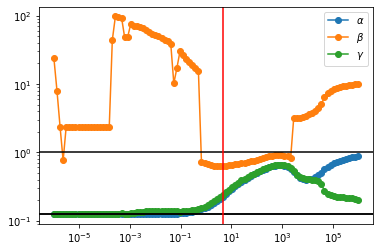

In [16]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

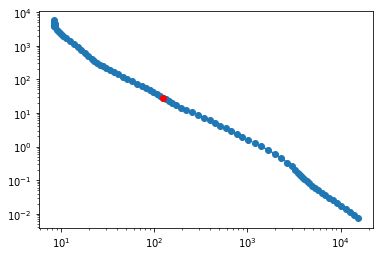

In [17]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

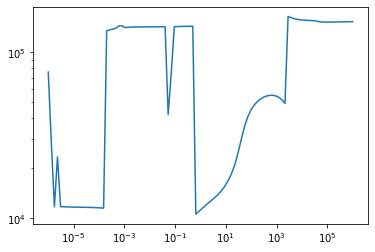

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

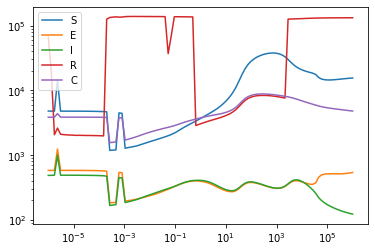

In [19]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [20]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

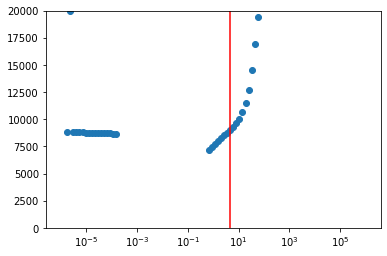

In [21]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [22]:
rinf(sols[idx])

8990.557518090518

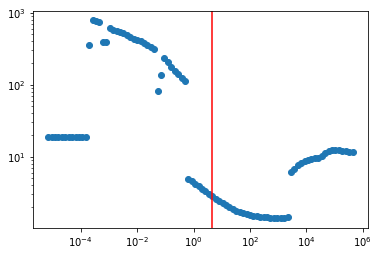

In [23]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [24]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(5378.44), DM(1182.24), DM(951.83), DM(1997.19), DM(3234.14)]

In [25]:
getx(sols[idx]['x'])[0][0]

DM(9695.5)

In [26]:
getp(sols[idx]['x'])

(DM(0.225526), DM(0.632163), DM(0.241356))

In [27]:
r0(sols[idx])

2.8030562845347045

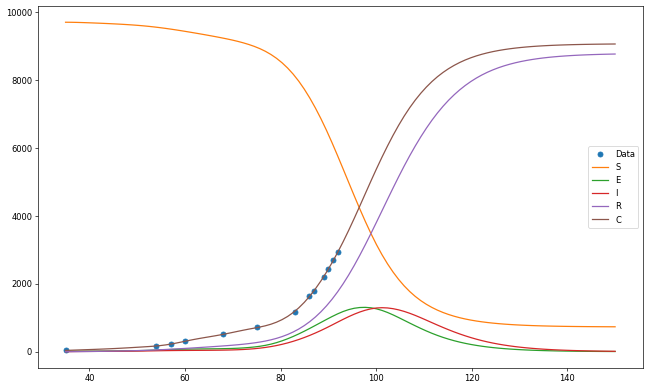

In [28]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

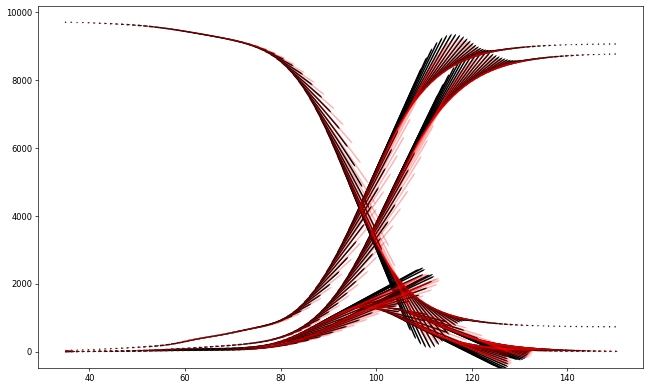

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

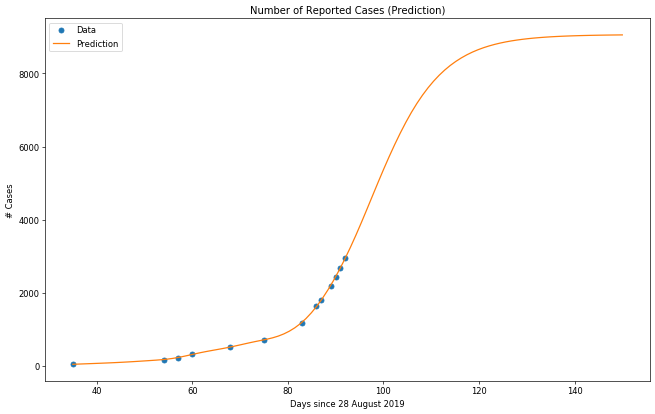

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

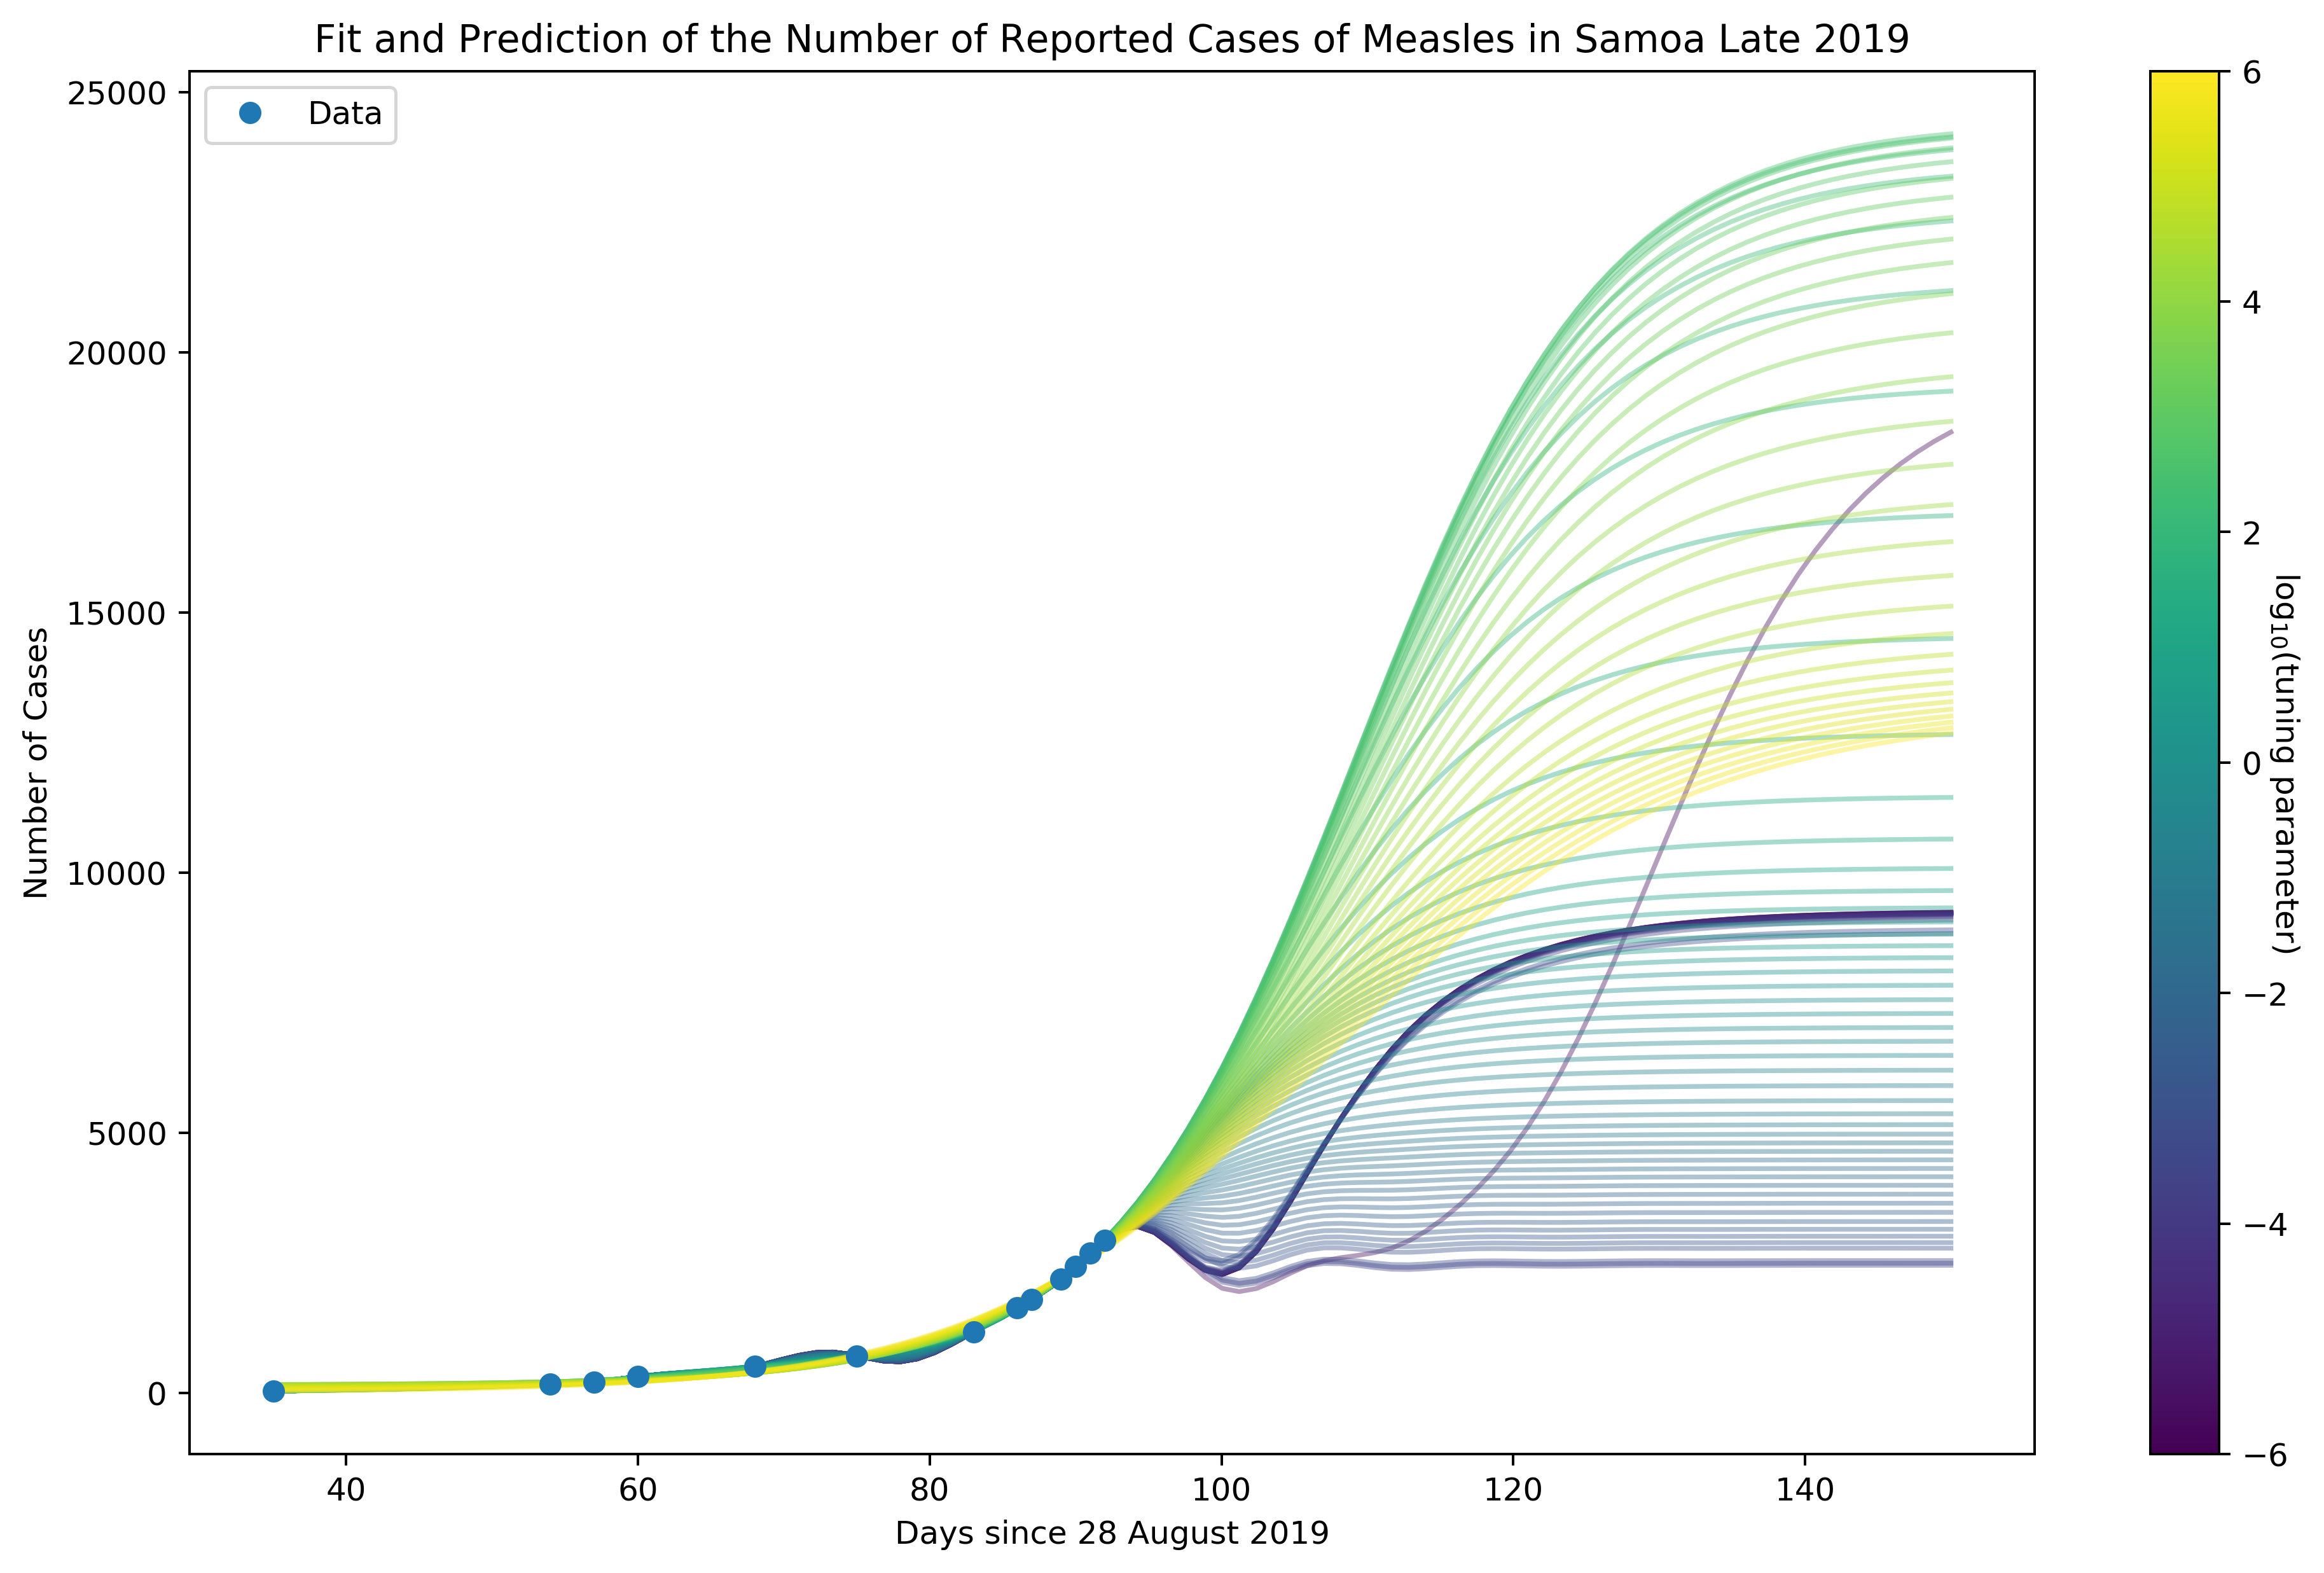

In [66]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[1:-1:]):
    plt.plot(model.observation_times, getx(sols[i+1]['x'])[-1], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
# plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([122.71258911,  28.40786737])

In [33]:
# getc = ca.Function('getx', [solver_setup['x']], model.cs)
# np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

In [34]:
getp(sols[idx]['x'])

(DM(0.225526), DM(0.632163), DM(0.241356))

In [35]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),

}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [36]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], 
                                      lbx=lbx0, ubx=ubx0, lbg=lbg, ubg=ubg))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  20  4.1257639e+03 0.00e+00 1.35e+01  -3.8 7.73e+02  -8.3 2.76e-01 1.00e+00f  1
  30  6.4667319e+02 0.00e+00 2.76e+01  -3.8 6.47e+02  -9.5 1.00e+00 1.00e+00f  1
  40  3.3919617e+02 0.00e+00 3.06e-02  -3.8 1.55e+02  -9.7 1.00e+00 1.00e+00f  1
  50  3.2615898e+02 0.00e+00 9.35e-01  -5.7 7.61e+01 -10.8 1.00e+00 1.00e+00f  1
  60  3.2325785e+02 0.00e+00 6.13e-01  -5.7 1.08e+02 -11.1 1.00e+00 5.00e-01f  2
  70  3.2173556e+02 0.00e+00 2.50e-01  -5.7 3.75e+02 -12.2 1.00e+00 2.50e-01f  3
  80  3.2054742e+02 0.00e+00 2.48e-04  -5.7 1.66e+00  -8.8 1.00e+00 1.00e+00f  1
  90  3.1967832e+02 0.00e+00 3.97e-05  -5.7 1.42e+00  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1871495e+02 0.00e+00 2.01e-03  -5.7 4.00e+00  -9.6 1.00e+00 1.00e+00f  1
 110  3.1793079e+02 0.00e+00 1.55e-01  -5.7 2.88e+04    -  5.26e-01 7.31e-03f  5
 120  3.1727329e+02 0.00e+00 1.03e-03  -8.6 1.23e+01  -9.9 1.00e+00 1.00e+00h  1
 130  3.1642707e+02 0.00e+00

 510  3.2124608e+02 0.00e+00 2.50e-01  -8.6 1.05e+02 -10.9 1.00e+00 1.00e+00h  1
 520  3.2074478e+02 0.00e+00 2.01e-02  -8.6 4.91e+01 -10.2 1.00e+00 1.00e+00f  1
 530  3.1998575e+02 0.00e+00 5.31e-03  -8.6 7.05e+00  -9.6 1.00e+00 1.00e+00h  1
 540  3.1953517e+02 0.00e+00 1.85e-02  -8.6 6.95e+01 -10.7 1.00e+00 1.00e+00h  1
 550  3.1889232e+02 0.00e+00 1.25e-01  -8.6 1.67e+02 -11.0 1.00e+00 1.00e+00f  1
 560  3.1816634e+02 0.00e+00 7.54e-03  -8.6 3.52e+01 -10.3 1.00e+00 1.00e+00h  1
 570  3.1730626e+02 0.00e+00 7.60e-02  -8.6 4.53e+03 -11.5 1.00e+00 4.52e-02f  5
 580  3.1643018e+02 0.00e+00 1.41e-01  -8.6 8.85e+02 -12.7 1.00e+00 5.00e-01f  2
 590  3.1555166e+02 0.00e+00 5.26e-02  -8.6 1.76e+03 -12.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.1496094e+02 0.00e+00 3.57e-02  -8.6 2.15e+03 -11.8 1.00e+00 6.25e-02f  5
 610  3.1420808e+02 0.00e+00 6.28e-02  -8.6 4.18e+02 -11.1 1.00e+00 6.25e-02h  5
 620  3.1394257e+02 0.00e+00

  30  1.5475818e+03 0.00e+00 9.07e+01  -2.5 2.52e+04    -  9.13e-01 5.00e-01f  2
  40  8.6387546e+02 0.00e+00 6.49e-01  -2.5 4.11e+02  -9.5 1.00e+00 1.00e+00f  1
  50  9.3473078e+02 0.00e+00 2.50e+02  -2.5 3.86e+04    -  7.79e-01 6.25e-02f  5
  60  1.0829652e+03 0.00e+00 4.88e+02  -2.5 1.91e+04    -  1.00e+00 5.00e-01f  2
  70  9.8681441e+02 0.00e+00 5.93e+01  -2.5 4.73e+03    -  1.00e+00 2.50e-01f  3
  80  1.0020494e+03 0.00e+00 2.12e-03  -2.5 9.24e+00    -  1.00e+00 1.00e+00h  1
  90  5.0084711e+02 0.00e+00 6.83e+01  -3.8 1.22e+03 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3161973e+02 0.00e+00 4.28e+01  -3.8 7.99e+02 -11.3 1.00e+00 1.00e+00f  1
 110  4.1516586e+02 0.00e+00 9.54e+00  -3.8 5.01e+02 -11.1 1.00e+00 1.00e+00f  1
 120  4.1030584e+02 0.00e+00 3.72e+00  -3.8 2.29e+02 -10.8 1.00e+00 1.00e+00h  1
 130  4.0575132e+02 0.00e+00 4.65e+00  -3.8 3.19e+02 -11.8 1.00e+00 1.00e+00f  1
 140  4.0346935e+02 0.00e+00

 110  3.3212382e+02 0.00e+00 7.24e-01  -5.7 3.51e+02 -11.6 1.00e+00 1.00e+00f  1
 120  3.2905303e+02 0.00e+00 7.75e-01  -5.7 6.04e+01 -10.9 1.00e+00 1.00e+00f  1
 130  3.2674032e+02 0.00e+00 4.32e-01  -5.7 4.45e+01 -11.2 1.00e+00 1.00e+00f  1
 140  3.2493455e+02 0.00e+00 1.41e+00  -5.7 4.29e+02 -12.3 1.00e+00 1.00e+00f  1
 150  3.2354182e+02 0.00e+00 3.70e-01  -5.7 7.65e+02 -11.7 1.00e+00 5.00e-01f  2
 160  3.2273901e+02 0.00e+00 3.99e-02  -5.7 6.63e+01 -11.0 1.00e+00 1.00e+00h  1
 170  3.2223626e+02 0.00e+00 5.34e-02  -5.7 1.32e+02 -11.3 1.00e+00 1.00e+00h  1
 180  3.2199316e+02 0.00e+00 4.37e-03  -5.7 3.22e+01 -10.6 1.00e+00 1.00e+00h  1
 190  3.2146645e+02 0.00e+00 3.56e-02  -5.7 1.04e+01 -10.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.2101837e+02 0.00e+00 2.08e-02  -5.7 9.58e+01 -11.2 1.00e+00 1.00e+00h  1
 210  3.2043189e+02 0.00e+00 4.44e-03  -5.7 5.76e+00  -9.6 1.00e+00 1.00e+00h  1
 220  3.1984164e+02 0.00e+00

  90  3.2280864e+02 0.00e+00 1.51e+00  -5.7 2.76e+02 -12.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2025204e+02 0.00e+00 2.07e+00  -5.7 3.65e+02 -11.6 1.00e+00 2.50e-01f  3
 110  3.1812428e+02 0.00e+00 2.70e-01  -5.7 3.35e+01 -10.9 1.00e+00 1.00e+00f  1
 120  3.1704795e+02 0.00e+00 4.76e-02  -5.7 1.38e+02 -11.2 1.00e+00 1.00e+00f  1
 130  3.1636832e+02 0.00e+00 8.43e-01  -5.7 2.24e+02 -10.5 1.00e+00 2.50e-01f  3
 140  3.1568290e+02 0.00e+00 3.48e-01  -5.7 3.66e+02 -11.7 1.00e+00 5.00e-01h  2
 150  3.1513635e+02 0.00e+00 8.84e-04  -5.7 1.14e+01 -10.1 1.00e+00 1.00e+00h  1
 160  3.1463589e+02 0.00e+00 4.40e-02  -5.7 1.60e+02 -11.3 1.00e+00 1.00e+00h  1
 170  3.1406982e+02 0.00e+00 5.54e-03  -5.7 3.95e+01 -10.6 1.00e+00 1.00e+00h  1
 180  3.1346804e+02 0.00e+00 2.00e-02  -5.7 7.51e+01 -10.9 1.00e+00 1.00e+00h  1
 190  3.1280533e+02 0.00e+00 1.55e-01  -8.6 2.13e+02 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 430  3.2765695e+02 0.00e+00 8.28e-01  -5.7 5.60e+01 -11.1 1.00e+00 1.00e+00f  1
 440  3.2631524e+02 0.00e+00 6.91e-01  -5.7 9.23e+01 -11.3 1.00e+00 1.00e+00h  1
 450  3.2521388e+02 0.00e+00 9.75e-01  -5.7 4.00e+03 -12.5 1.00e+00 3.12e-02f  6
 460  3.2444229e+02 0.00e+00 1.83e+00  -5.7 7.55e+01 -10.1 1.00e+00 1.00e+00h  1
 470  3.2383257e+02 0.00e+00 5.06e-01  -5.7 7.06e+02 -12.1 1.00e+00 1.00e+00h  1
 480  3.2370292e+02 0.00e+00 4.80e+00  -5.7 1.19e+02 -10.6 1.00e+00 1.00e+00H  1
 490  3.2274295e+02 0.00e+00 3.46e-01  -5.7 6.01e+05    -  1.33e-01 7.48e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.2251551e+02 0.00e+00 8.39e-02  -5.7 5.88e+01 -11.0 1.00e+00 1.00e+00h  1
 510  3.2216703e+02 0.00e+00 4.07e-01  -5.7 1.20e+02 -11.3 1.00e+00 1.00e+00h  1
 520  3.2175743e+02 0.00e+00 7.94e-01  -5.7 9.46e+02 -11.5 1.00e+00 5.00e-01f  2
 530  3.2129718e+02 0.00e+00 4.53e-01  -5.7 3.36e+02 -11.8 1.00e+00 1.00e+00h  1
 540  3.2096102e+02 0.00e+00

  20  4.9281138e+02 0.00e+00 6.30e+00  -3.8 7.63e+02  -9.2 1.00e+00 1.00e+00f  1
  30  3.0845065e+02 0.00e+00 5.26e-01  -3.8 4.30e+01  -8.1 1.00e+00 1.00e+00f  1
  40  2.9967307e+02 0.00e+00 1.71e-02  -5.7 7.58e+00  -8.8 1.00e+00 1.00e+00f  1
  50  2.9858472e+02 0.00e+00 3.82e-02  -5.7 9.44e+01 -10.8 1.00e+00 1.00e+00f  1
  60  2.9768622e+02 0.00e+00 1.89e-01  -5.7 6.06e+04    -  4.38e-01 4.36e-03f  5
  70  2.9669405e+02 0.00e+00 2.44e-01  -5.7 6.43e+03    -  7.91e-01 3.53e-02f  5
  80  2.9607726e+02 0.00e+00 1.43e-01  -5.7 7.36e+03 -11.7 1.00e+00 2.60e-02f  5
  90  2.9555315e+02 0.00e+00 9.27e-02  -5.7 5.80e+03    -  8.34e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9547934e+02 0.00e+00 7.50e-02  -5.7 1.11e+04    -  9.22e-01 1.25e-01f  4
 110  2.9540556e+02 0.00e+00 9.44e-02  -8.6 6.05e+02    -  9.31e-01 2.43e-01h  3
 120  2.9533028e+02 0.00e+00 6.17e-05  -8.6 4.87e-01  -9.2 1.00e+00 1.00e+00h  1
 130  2.9532882e+02 0.00e+00

 490  3.0102368e+02 0.00e+00 2.68e-03  -5.7 2.33e+01 -10.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.0031083e+02 0.00e+00 5.41e-01  -5.7 2.93e+02 -11.3 1.00e+00 1.00e+00f  1
 510  2.9921438e+02 0.00e+00 8.34e-04  -5.7 1.33e+01  -9.8 1.00e+00 1.00e+00f  1
 520  2.9841640e+02 0.00e+00 4.77e-02  -5.7 1.42e+02 -10.9 1.00e+00 1.00e+00h  1
 530  2.9762107e+02 0.00e+00 2.60e-05  -5.7 1.04e+00  -8.5 1.00e+00 1.00e+00f  1
 540  2.9704268e+02 0.00e+00 1.97e-02  -5.7 6.32e+01 -10.5 1.00e+00 1.00e+00h  1
 550  2.9613630e+02 0.00e+00 7.16e-02  -5.7 7.24e+02 -11.7 1.00e+00 2.50e-01f  3
 560  2.9539342e+02 0.00e+00 2.94e-03  -5.7 6.87e+00  -9.2 1.00e+00 1.00e+00f  1
 570  2.9414046e+02 0.00e+00 1.29e-03  -5.7 1.96e+01  -9.9 1.00e+00 1.00e+00f  1
 580  2.9353012e+02 0.00e+00 5.25e-02  -5.7 2.08e+03 -10.6 1.00e+00 6.25e-02f  5
 590  2.9300645e+02 0.00e+00 1.76e-01  -5.7 1.94e+02 -10.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

  60  3.1003154e+02 0.00e+00 6.43e-01  -5.7 7.06e+01 -10.0 1.00e+00 1.00e+00f  1
  70  3.0655193e+02 0.00e+00 4.04e+00  -5.7 2.09e+02 -11.1 1.00e+00 5.00e-01f  2
  80  3.0372848e+02 0.00e+00 1.49e+00  -5.7 2.35e+02 -11.4 1.00e+00 2.50e-01f  3
  90  3.0185453e+02 0.00e+00 1.57e-01  -5.7 4.42e+01 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0089590e+02 0.00e+00 4.08e-01  -5.7 1.75e+03 -11.9 1.00e+00 2.50e-01f  3
 110  3.0036771e+02 0.00e+00 2.97e+00  -5.7 1.70e+02 -10.3 1.00e+00 5.00e-01h  2
 120  2.9916419e+02 0.00e+00 2.19e-03  -5.7 7.21e+00  -9.7 1.00e+00 1.00e+00h  1
 130  2.9861383e+02 0.00e+00 1.39e-03  -5.7 2.07e+00  -9.0 1.00e+00 1.00e+00h  1
 140  2.9802698e+02 0.00e+00 2.91e-03  -5.7 2.55e+01 -10.2 1.00e+00 1.00e+00h  1
 150  2.9707282e+02 0.00e+00 7.42e-03  -5.7 5.50e+01 -10.5 1.00e+00 1.00e+00h  1
 160  2.9645691e+02 0.00e+00 1.66e-02  -5.7 9.16e+01 -10.7 1.00e+00 1.00e+00h  1
 170  2.9558530e+02 0.00e+00

 320  2.9739685e+02 0.00e+00 2.53e-02  -5.7 1.16e+02 -10.9 1.00e+00 1.00e+00h  1
 330  2.9675207e+02 0.00e+00 2.10e-01  -5.7 2.23e+02 -11.1 1.00e+00 1.00e+00f  1
 340  2.9615708e+02 0.00e+00 1.21e-02  -5.7 5.18e+01 -10.5 1.00e+00 1.00e+00h  1
 350  2.9530814e+02 0.00e+00 6.18e-03  -5.7 1.22e+01  -9.8 1.00e+00 1.00e+00f  1
 360  2.9439871e+02 0.00e+00 7.28e-02  -5.7 1.89e+02 -11.0 1.00e+00 1.00e+00f  1
 370  2.9349180e+02 0.00e+00 7.16e-01  -5.7 3.44e+02 -11.3 1.00e+00 1.00e+00f  1
 380  2.9258030e+02 0.00e+00 5.80e-01  -5.7 4.43e+02 -11.5 1.00e+00 5.00e-01f  2
 390  2.9173058e+02 0.00e+00 2.34e-03  -5.7 2.49e+01 -10.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.9097066e+02 0.00e+00 5.92e-01  -5.7 2.94e+02 -11.1 1.00e+00 1.00e+00f  1
 410  2.8914182e+02 0.00e+00 1.71e-01  -5.7 3.42e+03 -12.3 1.00e+00 5.00e-01f  2
 420  2.8818569e+02 0.00e+00 1.98e-02  -5.7 2.41e+01  -9.8 1.00e+00 1.00e+00h  1
 430  2.8728320e+02 0.00e+00

 500  3.0858117e+02 0.00e+00 4.87e+00  -5.7 4.41e+02 -11.7 1.00e+00 5.00e-01f  2
 510  3.0784391e+02 0.00e+00 1.47e+00  -5.7 2.59e+03 -12.0 1.00e+00 3.12e-02f  6
 520  3.0735220e+02 0.00e+00 2.17e-01  -5.7 1.82e+01  -9.5 1.00e+00 1.00e+00h  1
 530  3.0684390e+02 0.00e+00 7.14e-01  -5.7 3.28e+01  -9.7 1.00e+00 1.00e+00h  1
 540  3.0645447e+02 0.00e+00 5.11e-03  -5.7 2.04e+01 -10.4 1.00e+00 1.00e+00h  1
 550  3.0575574e+02 0.00e+00 5.87e-01  -5.7 5.21e+05    -  1.00e-01 1.05e-03f  7
 560  3.0518348e+02 0.00e+00 7.69e-05  -5.7 1.71e+00  -9.3 1.00e+00 1.00e+00h  1
 570  3.0479827e+02 0.00e+00 2.18e-01  -5.7 5.06e+02 -11.8 1.00e+00 1.00e+00h  1
 580  3.0431790e+02 0.00e+00 1.65e+00  -5.7 7.84e+02 -12.0 1.00e+00 1.00e+00f  1
 590  3.0381116e+02 0.00e+00 6.06e-05  -5.7 3.55e+00  -9.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.0348335e+02 0.00e+00 2.19e-02  -5.7 5.03e+01 -10.7 1.00e+00 1.00e+00h  1
 610  3.0307132e+02 0.00e+00

  80  2.8347204e+02 0.00e+00 6.09e-01  -5.7 4.02e+02 -11.1 1.00e+00 5.00e-01f  2
  90  2.8228548e+02 0.00e+00 6.11e-01  -5.7 4.92e+02 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8134802e+02 0.00e+00 5.78e-02  -5.7 1.02e+02 -10.7 1.00e+00 1.00e+00f  1
 110  2.8001513e+02 0.00e+00 1.02e-04  -5.7 1.64e+00  -8.6 1.00e+00 1.00e+00f  1
 120  2.7935007e+02 0.00e+00 2.47e-04  -5.7 4.13e+00  -9.2 1.00e+00 1.00e+00f  1
 130  2.7903837e+02 0.00e+00 5.13e-02  -5.7 7.07e+03    -  1.00e+00 6.25e-02f  5
 140  2.7892722e+02 0.00e+00 1.61e-01  -5.7 6.70e+02 -12.8 1.00e+00 5.00e-01h  2
 150  2.8021859e+02 0.00e+00 1.07e+00  -8.6 5.27e+03    -  9.49e-01 9.84e-01H  1
 160  2.7894388e+02 0.00e+00 5.78e-06  -8.6 9.26e+01 -13.2 1.00e+00 1.00e+00h  1
 170  2.7893355e+02 0.00e+00 3.28e-04  -8.6 1.51e+02 -12.5 1.00e+00 1.00e+00h  1
 180  2.7892512e+02 0.00e+00 2.40e-05  -8.6 9.24e+00 -11.9 1.00e+00 1.00e+00h  1
 190  2.7890981e+02 0.00e+00

 560  2.9845720e+02 0.00e+00 5.73e-01  -5.7 1.25e+03 -11.7 1.00e+00 6.25e-02h  5
 570  2.9803742e+02 0.00e+00 2.03e-03  -5.7 3.07e+00  -9.3 1.00e+00 1.00e+00h  1
 580  2.9769621e+02 0.00e+00 1.38e-01  -5.7 3.32e+02 -11.4 1.00e+00 1.00e+00f  1
 590  2.9720226e+02 0.00e+00 5.93e-02  -5.7 7.85e+01 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.9678266e+02 0.00e+00 2.29e-03  -5.7 2.52e+00  -9.2 1.00e+00 1.00e+00h  1
 610  2.9601146e+02 0.00e+00 3.29e-01  -5.7 2.73e+02 -11.2 1.00e+00 1.00e+00f  1
 620  2.9564512e+02 0.00e+00 2.71e-02  -5.7 6.69e+01 -10.6 1.00e+00 1.00e+00h  1
 630  2.9509314e+02 0.00e+00 1.38e-04  -5.7 2.08e+00  -9.0 1.00e+00 1.00e+00f  1
 640  2.9461512e+02 0.00e+00 1.24e-01  -5.7 2.24e+02 -11.1 1.00e+00 1.00e+00f  1
 650  2.9412728e+02 0.00e+00 1.60e-02  -5.7 7.21e+00  -9.5 1.00e+00 1.00e+00h  1
 660  2.9374832e+02 0.00e+00 7.82e-01  -5.7 1.40e+03 -11.6 1.00e+00 6.25e-02f  5
 670  2.9323729e+02 0.00e+00

 180  2.8241219e+02 0.00e+00 1.33e-03  -5.7 2.37e+00  -8.5 1.00e+00 1.00e+00h  1
 190  2.8107162e+02 0.00e+00 1.64e-01  -5.7 2.39e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.7974713e+02 0.00e+00 9.28e-01  -5.7 3.77e+02 -10.8 1.00e+00 5.00e-01f  2
 210  2.7815647e+02 0.00e+00 8.83e-02  -5.7 2.95e+02 -11.0 1.00e+00 1.00e+00f  1
 220  2.7689143e+02 0.00e+00 1.51e-01  -5.7 7.66e+01  -9.4 1.00e+00 2.50e-01f  3
 230  2.7585708e+02 0.00e+00 4.02e-02  -5.7 2.03e+02 -11.0 1.00e+00 1.00e+00f  1
 240  2.7526877e+02 0.00e+00 4.10e-03  -5.7 5.75e+00  -9.0 1.00e+00 1.00e+00f  1
 250  2.7508262e+02 0.00e+00 1.35e-01  -5.7 2.74e+04    -  4.85e-01 1.25e-01f  4
 260  2.7509940e+02 0.00e+00 1.11e-01  -5.7 2.95e+04    -  7.73e-01 2.50e-01f  3
 270  2.7507886e+02 0.00e+00 1.35e-04  -8.6 1.22e+02 -12.7 1.00e+00 1.00e+00h  1
 280  2.7504987e+02 0.00e+00 2.03e-02  -8.6 4.19e+02 -13.0 1.00e+00 1.00e+00h  1
 290  2.7503098e+02 0.00e+00

 540  2.9853085e+02 0.00e+00 1.33e+00  -3.8 2.32e+04    -  1.00e+00 1.56e-02f  7
 550  2.9816818e+02 0.00e+00 1.39e+00  -3.8 1.28e+04    -  1.00e+00 3.12e-02f  6
 560  2.9752060e+02 0.00e+00 7.20e-02  -5.7 1.43e+01  -9.4 1.00e+00 1.00e+00f  1
 570  2.9708681e+02 0.00e+00 1.46e+00  -5.7 2.15e+03 -11.5 1.00e+00 2.50e-01f  3
 580  2.9670199e+02 0.00e+00 1.03e-01  -5.7 3.15e+01  -9.9 1.00e+00 1.00e+00h  1
 590  2.9632317e+02 0.00e+00 3.10e+00  -5.7 2.61e+03 -12.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.9604833e+02 0.00e+00 3.77e-02  -5.7 1.05e+02 -10.4 1.00e+00 1.00e+00h  1
 610  2.9552596e+02 0.00e+00 1.12e-01  -5.7 1.96e+02 -10.7 1.00e+00 1.00e+00f  1
 620  2.9499448e+02 0.00e+00 3.75e-01  -5.7 3.59e+02 -10.9 1.00e+00 1.00e+00f  1
 630  2.9463242e+02 0.00e+00 1.05e+00  -5.7 7.60e+03 -11.2 1.00e+00 7.81e-03f  8
 640  2.9422097e+02 0.00e+00 3.13e-01  -5.7 1.60e+02 -10.5 1.00e+00 1.00e+00f  1
 650  2.9346059e+02 0.00e+00

 180  3.8768617e+02 0.00e+00 1.44e+03  -1.7 4.78e+03    -  1.00e+00 1.25e-01f  4
 190  3.8445876e+02 0.00e+00 1.68e+03  -1.7 6.05e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8278353e+02 0.00e+00 3.57e+01  -1.7 1.14e+02  -9.4 1.00e+00 1.00e+00f  1
 210  3.8162657e+02 0.00e+00 2.64e+02  -1.7 1.89e+03    -  1.00e+00 1.25e-01f  4
 220  3.8016744e+02 0.00e+00 1.29e+01  -1.7 1.96e+02    -  1.00e+00 1.00e+00f  1
 230  3.7918119e+02 0.00e+00 9.76e+01  -1.7 6.78e+02 -10.4 1.00e+00 2.50e-01f  3
 240  3.7839180e+02 0.00e+00 4.45e+01  -1.7 2.42e+02 -10.5 1.00e+00 1.00e+00f  1
 250  3.7755562e+02 0.00e+00 8.94e+01  -1.7 1.12e+02    -  1.00e+00 1.00e+00f  1
 260  3.7688969e+02 0.00e+00 2.56e+01  -1.7 5.79e+01    -  1.00e+00 1.00e+00h  1
 270  3.7077588e+02 0.00e+00 3.38e+03  -2.5 6.79e+02  -8.7 1.00e+00 1.00e+00f  1
 280  3.6612549e+02 0.00e+00 9.94e+02  -2.5 4.81e+04    -  8.69e-01 1.02e-02f  7
 290  3.6233855e+02 0.00e+00

  80  2.8353743e+02 0.00e+00 2.45e+00  -5.7 4.80e+02 -10.6 1.00e+00 1.00e+00f  1
  90  2.8240022e+02 0.00e+00 3.89e-03  -5.7 1.10e+01  -9.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8106271e+02 0.00e+00 1.06e+00  -5.7 3.70e+03 -11.1 1.00e+00 1.25e-01f  4
 110  2.7949972e+02 0.00e+00 1.74e+00  -5.7 1.71e+04 -11.3 1.00e+00 8.53e-02f  4
 120  2.7767304e+02 0.00e+00 1.04e-01  -5.7 8.35e+01  -9.8 1.00e+00 1.00e+00f  1
 130  2.7578117e+02 0.00e+00 3.81e-02  -5.7 1.99e+01  -9.1 1.00e+00 1.00e+00f  1
 140  2.7459638e+02 0.00e+00 1.37e-01  -5.7 1.50e+02 -10.3 1.00e+00 1.00e+00f  1
 150  2.7416146e+02 0.00e+00 6.43e-03  -5.7 1.80e+02 -11.5 1.00e+00 1.00e+00f  1
 160  2.7410014e+02 0.00e+00 1.46e-02  -5.7 5.95e+02 -12.6 1.00e+00 1.00e+00h  1
 170  2.7403963e+02 0.00e+00 2.33e-02  -5.7 2.16e+02 -12.0 1.00e+00 5.00e-01h  2
 180  2.7397040e+02 0.00e+00 2.40e-03  -5.7 7.64e+01    -  1.00e+00 1.00e+00h  1
 190  2.7390523e+02 0.00e+00

 550  2.9887664e+02 0.00e+00 6.60e-01  -5.7 9.54e+03 -12.6 1.00e+00 2.50e-01f  3
 560  2.9849404e+02 0.00e+00 8.47e-03  -5.7 1.91e+01 -10.1 1.00e+00 1.00e+00h  1
 570  2.9808931e+02 0.00e+00 2.40e-01  -5.7 2.79e+02 -11.3 1.00e+00 1.00e+00h  1
 580  2.9767692e+02 0.00e+00 2.97e-04  -5.7 8.75e+00  -9.8 1.00e+00 1.00e+00h  1
 590  2.9735707e+02 0.00e+00 9.97e-01  -5.7 1.12e+03 -11.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.9685522e+02 0.00e+00 2.35e-01  -5.7 2.32e+02 -11.2 1.00e+00 1.00e+00h  1
 610  2.9638273e+02 0.00e+00 1.33e+00  -5.7 5.57e+02 -11.4 1.00e+00 1.00e+00f  1
 620  2.9567135e+02 0.00e+00 2.96e-02  -5.7 6.60e+00  -9.0 1.00e+00 1.00e+00h  1
 630  2.9502207e+02 0.00e+00 4.50e-02  -5.7 8.25e+00  -9.2 1.00e+00 1.00e+00h  1
 640  2.9468180e+02 0.00e+00 1.19e-01  -5.7 3.60e+02 -11.3 1.00e+00 1.00e+00f  1
 650  2.9409006e+02 0.00e+00 6.91e-03  -5.7 1.09e+01  -9.7 1.00e+00 1.00e+00f  1
 660  2.9357578e+02 0.00e+00

 300  2.7943755e+02 0.00e+00 4.02e-07  -8.6 3.17e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 301

                                   (scaled)                 (unscaled)
Objective...............:   1.4724156613107864e-01    2.7943755036281169e+02
Dual infeasibility......:   1.3296580553324698e-12    2.5234476891635015e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    4.7557464278739728e-06
Overall NLP error.......:   2.5059035596800626e-09    4.7557464278739728e-06


Number of objective function evaluations             = 577
Number of objective gradient evaluations             = 302
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 577
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 302
Number of Lagrangian Hessian evaluations             = 301
Total CPU secs in IP

 720  3.0410620e+02 0.00e+00 4.09e-01  -8.6 1.83e+03 -11.4 1.00e+00 5.00e-01f  2
 730  3.0334422e+02 0.00e+00 2.01e-01  -8.6 2.01e+03 -12.6 1.00e+00 2.50e-01f  3
 740  3.0293791e+02 0.00e+00 3.17e-01  -8.6 1.66e+03 -11.9 8.70e-01 6.25e-02h  5
 750  3.0232068e+02 0.00e+00 1.23e-01  -8.6 2.56e+02 -11.3 1.00e+00 1.00e+00f  1
 760  3.0180468e+02 0.00e+00 4.56e-02  -8.6 3.84e+02 -11.6 1.00e+00 1.00e+00h  1
 770  3.0097295e+02 0.00e+00 2.45e-05  -8.6 1.85e+00  -9.1 1.00e+00 1.00e+00f  1
 780  3.0012338e+02 0.00e+00 1.04e-01  -8.6 2.19e+02 -11.2 1.00e+00 1.00e+00h  1
 790  2.9950427e+02 0.00e+00 8.66e-02  -8.6 4.24e+03 -12.3 1.00e+00 8.25e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.9853682e+02 0.00e+00 2.03e-02  -8.6 9.57e+01 -10.8 1.00e+00 1.00e+00h  1
 810  2.9770684e+02 0.00e+00 1.23e-01  -8.6 2.16e+03 -11.9 1.00e+00 2.24e-01f  2
 820  2.9646870e+02 0.00e+00 3.76e-02  -8.6 3.43e+02 -11.3 1.00e+00 1.00e+00f  1
 830  2.9546786e+02 0.00e+00

 360  3.6131985e+02 0.00e+00 2.38e+00  -3.8 1.35e+03    -  1.00e+00 5.00e-01h  2
 370  3.5857935e+02 0.00e+00 3.36e-01  -3.8 9.32e+03    -  1.00e+00 3.12e-02h  6
 380  3.5576232e+02 0.00e+00 7.69e-01  -3.8 5.92e+01 -11.7 1.00e+00 1.00e+00h  1
 390  3.5310854e+02 0.00e+00 2.09e+00  -3.8 1.76e+02 -11.3 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.5039224e+02 0.00e+00 1.06e+00  -3.8 7.09e+01 -12.0 1.00e+00 1.00e+00h  1
 410  3.4754649e+02 0.00e+00 1.65e-01  -3.8 8.08e+01 -12.2 1.00e+00 1.00e+00f  1
 420  3.4471324e+02 0.00e+00 3.63e+00  -3.8 1.22e+03    -  1.00e+00 5.00e-01h  2
 430  3.4238152e+02 0.00e+00 4.03e+00  -3.8 1.55e+02    -  1.00e+00 1.00e+00h  1
 440  3.4037028e+02 0.00e+00 1.25e+00  -3.8 1.41e+02    -  1.00e+00 5.00e-01h  2
 450  3.3794018e+02 0.00e+00 1.14e+00  -3.8 6.02e+02    -  1.00e+00 1.25e-01h  4
 460  3.3629700e+02 0.00e+00 4.15e+00  -5.7 1.35e+04    -  5.46e-01 1.09e-02f  7
 470  3.3043955e+02 0.00e+00

  90  7.8640955e+02 0.00e+00 5.42e+01  -2.5 2.04e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.0713071e+02 0.00e+00 3.19e+00  -2.5 2.69e+02    -  1.00e+00 1.00e+00f  1
 110  5.1678369e+02 0.00e+00 5.54e+01  -3.8 3.30e+03 -11.1 1.00e+00 5.00e-01f  2
 120  4.3287173e+02 0.00e+00 5.65e+00  -3.8 4.54e+02 -11.3 1.00e+00 1.00e+00f  1
 130  4.2491549e+02 0.00e+00 1.89e+01  -3.8 3.86e+03    -  1.00e+00 2.50e-01f  3
 140  4.2265102e+02 0.00e+00 2.97e-01  -3.8 2.35e+02 -11.6 1.00e+00 1.00e+00f  1
 150  4.2043894e+02 0.00e+00 1.19e+01  -3.8 5.30e+03 -12.7 1.00e+00 1.25e-01f  4
 160  4.1857315e+02 0.00e+00 3.60e+00  -3.8 1.33e+04    -  1.00e+00 3.12e-02h  6
 170  4.1658068e+02 0.00e+00 6.69e+00  -3.8 3.49e+02    -  1.00e+00 1.00e+00h  1
 180  4.1470784e+02 0.00e+00 7.93e+00  -3.8 1.58e+03    -  1.00e+00 2.50e-01h  3
 190  4.1327487e+02 0.00e+00 3.16e+00  -3.8 5.92e+03    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr 

  60  3.7720856e+02 0.00e+00 1.22e-02  -3.8 6.42e+01 -10.0 1.00e+00 1.00e+00f  1
  70  3.8164770e+02 0.00e+00 6.04e+00  -3.8 3.62e+04    -  1.00e+00 1.25e-01f  4
  80  3.8423472e+02 0.00e+00 6.85e+00  -3.8 3.47e+04    -  1.00e+00 6.25e-02f  5
  90  3.8721972e+02 0.00e+00 4.36e+00  -3.8 2.31e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8936849e+02 0.00e+00 5.31e-02  -3.8 3.44e+01 -10.6 1.00e+00 1.00e+00h  1
 110  3.9182197e+02 0.00e+00 4.66e-01  -3.8 6.20e+01 -11.2 1.00e+00 1.00e+00h  1
 120  3.9460576e+02 0.00e+00 1.00e+00  -3.8 1.82e+02    -  1.00e+00 1.00e+00h  1
 130  3.9654355e+02 0.00e+00 4.98e-01  -3.8 1.50e+02 -13.2 1.00e+00 1.00e+00h  1
 140  3.9857801e+02 0.00e+00 2.96e-01  -3.8 5.28e+01 -13.3 1.00e+00 1.00e+00h  1
 150  4.0087918e+02 0.00e+00 2.31e+00  -3.8 1.41e+02    -  1.00e+00 1.00e+00H  1
 160  4.0284975e+02 0.00e+00 2.64e+00  -3.8 6.06e+02    -  1.00e+00 2.50e-01h  3
 170  4.0435392e+02 0.00e+00

 100  6.0624115e+02 0.00e+00 1.66e+01  -3.8 1.03e+03 -11.0 1.00e+00 1.00e+00f  1
 110  4.8023617e+02 0.00e+00 4.51e+00  -3.8 6.02e+02 -11.2 1.00e+00 1.00e+00f  1
 120  4.6842027e+02 0.00e+00 8.33e+00  -3.8 9.56e+03    -  1.00e+00 2.50e-01f  3
 130  4.6503664e+02 0.00e+00 1.11e+00  -3.8 1.80e+02 -11.6 1.00e+00 1.00e+00h  1
 140  4.6327181e+02 0.00e+00 2.81e+00  -3.8 3.59e+03    -  1.00e+00 2.50e-01h  3
 150  4.6128330e+02 0.00e+00 3.17e+00  -3.8 5.17e+02    -  1.00e+00 1.00e+00h  1
 160  4.5937395e+02 0.00e+00 3.20e+00  -3.8 4.02e+03    -  1.00e+00 6.25e-02h  5
 170  4.5826665e+02 0.00e+00 1.16e+00  -3.8 7.25e+02    -  1.00e+00 5.00e-01h  2
 180  4.5627880e+02 0.00e+00 7.38e-01  -3.8 1.15e+02 -12.0 1.00e+00 1.00e+00h  1
 190  4.5522001e+02 0.00e+00 7.54e-01  -3.8 2.48e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.5447192e+02 0.00e+00 1.74e-01  -3.8 5.57e+01    -  1.00e+00 1.00e+00h  1
 210  4.5213210e+02 0.00e+00

  90  4.6470789e+02 0.00e+00 1.82e+00  -3.8 1.78e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.6666724e+02 0.00e+00 9.37e-02  -3.8 3.65e+01 -10.3 1.00e+00 1.00e+00h  1
 110  4.6994919e+02 0.00e+00 5.16e+00  -3.8 7.65e+03    -  1.00e+00 5.00e-01f  2
 120  4.7226565e+02 0.00e+00 3.40e-01  -3.8 2.58e+02 -11.9 1.00e+00 1.00e+00f  1
 130  4.7515101e+02 0.00e+00 2.07e+00  -3.8 1.91e+02    -  1.00e+00 1.00e+00h  1
 140  4.7742008e+02 0.00e+00 8.05e-02  -3.8 2.76e+02    -  1.00e+00 1.00e+00h  1
 150  4.7951211e+02 0.00e+00 1.78e+00  -3.8 2.59e+03    -  1.00e+00 1.25e-01h  4
 160  4.8138559e+02 0.00e+00 2.90e-01  -3.8 9.65e+01 -11.8 1.00e+00 1.00e+00h  1
 170  4.8290288e+02 0.00e+00 5.19e+00  -3.8 2.61e+03    -  1.00e+00 1.25e-01h  4
 180  4.8434345e+02 0.00e+00 8.95e-01  -3.8 7.04e+02    -  1.00e+00 2.50e-01h  3
 190  4.8605803e+02 0.00e+00 4.70e-01  -3.8 2.58e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  50  4.8572693e+02 0.00e+00 2.70e-01  -3.8 5.77e+01  -9.8 1.00e+00 1.00e+00f  1
  60  4.8801718e+02 0.00e+00 6.24e-02  -3.8 3.69e+02 -10.8 1.00e+00 1.00e+00f  1
  70  4.9012334e+02 0.00e+00 3.69e-02  -3.8 4.97e+01 -10.1 1.00e+00 1.00e+00f  1
  80  4.9576051e+02 0.00e+00 1.06e+01  -3.8 1.25e+03 -11.7 1.00e+00 5.00e-01f  2
  90  5.0062496e+02 0.00e+00 1.29e+01  -3.8 2.34e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0146995e+02 0.00e+00 7.27e+00  -3.8 1.18e+04    -  1.00e+00 3.12e-02f  6
 110  5.0504659e+02 0.00e+00 5.74e+00  -3.8 2.87e+03    -  1.00e+00 2.50e-01f  3
 120  5.0826386e+02 0.00e+00 4.17e+00  -3.8 1.09e+03    -  1.00e+00 2.50e-01h  3
 130  5.1105228e+02 0.00e+00 4.76e-01  -3.8 3.40e+02 -11.9 1.00e+00 1.00e+00h  1
 140  5.1391069e+02 0.00e+00 2.40e+00  -3.8 9.39e+02 -12.5 1.00e+00 5.00e-01h  2
 150  5.1697010e+02 0.00e+00 6.10e+00  -3.8 1.84e+03    -  1.00e+00 1.00e+00f  1
 160  5.1847788e+02 0.00e+00

  60  5.1862987e+02 0.00e+00 1.26e-02  -3.8 1.12e+01  -9.1 1.00e+00 1.00e+00f  1
  70  5.2685432e+02 0.00e+00 7.90e+00  -3.8 4.55e+02 -11.1 1.00e+00 1.00e+00f  1
  80  5.3196923e+02 0.00e+00 9.06e+00  -3.8 3.69e+03 -12.2 1.00e+00 1.00e+00f  1
  90  5.3310807e+02 0.00e+00 4.77e-02  -3.8 2.47e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3715384e+02 0.00e+00 5.13e-01  -3.8 1.01e+02 -11.2 1.00e+00 1.00e+00f  1
 110  5.4181814e+02 0.00e+00 1.78e+00  -3.8 2.33e+02 -11.8 1.00e+00 1.00e+00f  1
 120  5.4618462e+02 0.00e+00 4.64e+00  -3.8 8.19e+02    -  1.00e+00 1.00e+00f  1
 130  5.4984412e+02 0.00e+00 1.43e+00  -3.8 3.15e+02 -12.0 1.00e+00 1.00e+00f  1
 140  5.5328553e+02 0.00e+00 2.39e+00  -3.8 7.23e+03    -  1.00e+00 6.25e-02h  5
 150  5.5709734e+02 0.00e+00 7.94e-01  -3.8 2.00e+03 -12.6 1.00e+00 5.00e-01h  2
 160  5.5936180e+02 0.00e+00 4.47e+00  -3.8 2.33e+03 -12.3 1.00e+00 2.50e-01f  3
 170  5.6248147e+02 0.00e+00

 490  5.1411292e+02 0.00e+00 2.10e-02  -8.6 8.95e+01 -12.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.1333912e+02 0.00e+00 1.39e-03  -8.6 3.99e+00  -9.5 1.00e+00 1.00e+00h  1
 510  5.1285828e+02 0.00e+00 1.03e-02  -8.6 9.13e+00  -9.8 1.00e+00 1.00e+00h  1
 520  5.1261220e+02 0.00e+00 1.23e-05  -8.6 1.00e+01 -10.9 1.00e+00 1.00e+00h  1
 530  5.1221079e+02 0.00e+00 2.03e-03  -8.6 1.94e+01 -11.2 1.00e+00 1.00e+00h  1
 540  5.1187194e+02 0.00e+00 1.32e-02  -8.6 2.67e+02 -12.3 1.00e+00 1.00e+00h  1
 550  5.1139740e+02 0.00e+00 1.30e-02  -8.6 5.03e+02 -12.6 1.00e+00 1.00e+00h  1
 560  5.1071747e+02 0.00e+00 3.31e-04  -8.6 2.03e+00  -9.2 1.00e+00 1.00e+00f  1
 570  5.1040857e+02 0.00e+00 1.04e-05  -8.6 3.79e+00 -10.4 1.00e+00 1.00e+00h  1
 580  5.0993882e+02 0.00e+00 2.85e-02  -8.6 4.40e+02 -12.5 1.00e+00 1.00e+00h  1
 590  5.0934904e+02 0.00e+00 3.95e-02  -8.6 6.94e+01 -10.0 1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

  40  7.6347704e+02 0.00e+00 5.33e+00  -3.8 4.29e+04    -  1.84e-01 9.34e-03f  6
  50  7.4458497e+02 0.00e+00 2.04e-04  -3.8 7.55e+01 -10.2 1.00e+00 1.00e+00f  1
  60  7.1594099e+02 0.00e+00 5.90e-01  -5.7 1.24e+02 -11.8 1.00e+00 1.00e+00f  1
  70  7.0980868e+02 0.00e+00 7.27e-01  -5.7 2.78e+02 -12.1 1.00e+00 1.00e+00f  1
  80  7.0274765e+02 0.00e+00 4.36e-01  -5.7 3.29e+02 -12.3 1.00e+00 1.00e+00f  1
  90  6.9667435e+02 0.00e+00 3.96e-01  -5.7 1.57e+03 -12.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9019751e+02 0.00e+00 2.97e-01  -5.7 2.65e+02 -11.9 1.00e+00 1.00e+00f  1
 110  6.8411158e+02 0.00e+00 8.36e-01  -5.7 1.35e+03 -13.1 1.00e+00 2.50e-01f  3
 120  6.7795972e+02 0.00e+00 4.11e-01  -5.7 1.82e+02 -11.6 1.00e+00 1.00e+00f  1
 130  6.7223626e+02 0.00e+00 6.68e-01  -5.7 8.32e+02 -12.7 1.00e+00 5.00e-01f  2
 140  6.6712153e+02 0.00e+00 1.67e-01  -5.7 1.93e+02 -12.1 1.00e+00 1.00e+00f  1
 150  6.6349753e+02 0.00e+00

 200  7.4088879e+02 0.00e+00 1.25e-02  -8.6 2.68e+02 -11.9 1.00e+00 1.00e+00h  1
 210  7.3784885e+02 0.00e+00 4.31e-02  -8.6 1.79e+03 -13.1 1.00e+00 1.00e+00f  1
 220  7.3675881e+02 0.00e+00 9.33e-05  -8.6 1.41e+01 -10.6 1.00e+00 1.00e+00h  1
 230  7.3572759e+02 0.00e+00 1.15e-02  -8.6 2.80e+02 -12.7 1.00e+00 1.00e+00h  1
 240  7.3538989e+02 0.00e+00 1.51e-07  -8.6 7.03e+00 -12.0 1.00e+00 1.00e+00h  1
 250  7.3551062e+02 0.00e+00 3.59e-02  -8.6 1.44e+03 -14.1 1.00e+00 1.00e+00H  1
 260  7.3526866e+02 0.00e+00 6.05e-05  -8.6 6.31e+01 -12.5 1.00e+00 1.00e+00h  1
 270  7.3516694e+02 0.00e+00 1.09e-02  -8.6 8.88e+02 -13.7 1.00e+00 1.00e+00h  1
 280  7.3502605e+02 0.00e+00 4.31e-03  -8.6 4.39e+04 -13.9 3.80e-01 6.97e-03h  4
 290  7.3489628e+02 0.00e+00 3.89e-03  -8.6 1.20e+02 -12.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 297

                                   (scaled)                 (unscaled)
Object

  40  1.0634308e+03 0.00e+00 4.50e-01  -5.7 4.80e+03 -12.8 1.00e+00 2.50e-01f  3
  50  1.0549430e+03 0.00e+00 1.28e+00  -5.7 2.81e+02 -12.2 1.00e+00 1.00e+00f  1
  60  1.0439070e+03 0.00e+00 3.05e-02  -5.7 1.10e+03 -12.5 1.00e+00 1.00e+00f  1
  70  1.0349793e+03 0.00e+00 3.16e-01  -5.7 8.17e+01 -10.0 1.00e+00 1.00e+00f  1
  80  1.0282720e+03 0.00e+00 2.39e-01  -5.7 6.12e+02 -12.1 1.00e+00 2.50e-01f  3
  90  1.0239483e+03 0.00e+00 1.62e-01  -5.7 2.65e+02 -11.4 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0219373e+03 0.00e+00 1.33e-01  -5.7 3.25e+02 -12.6 1.00e+00 5.00e-01h  2
 110  1.0211943e+03 0.00e+00 5.17e-06  -5.7 7.02e-01 -10.1 1.00e+00 1.00e+00f  1
 120  1.0203678e+03 0.00e+00 1.74e-03  -8.6 5.22e+01 -11.7 1.00e+00 1.00e+00h  1
 130  1.0195594e+03 0.00e+00 2.03e-02  -8.6 7.54e+02 -12.8 1.00e+00 1.00e+00h  1
 140  1.0187602e+03 0.00e+00 4.75e-02  -8.6 1.47e+04 -13.1 1.00e+00 1.05e-02h  6
 150  1.0176178e+03 0.00e+00

 490  1.2070606e+03 0.00e+00 5.25e-03  -8.6 1.23e+03 -13.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2062950e+03 0.00e+00 4.49e-04  -8.6 8.07e+01 -12.0 1.00e+00 1.00e+00f  1
 510  1.2057119e+03 0.00e+00 2.34e-06  -8.6 1.69e+01 -11.3 1.00e+00 1.00e+00h  1
 520  1.2053019e+03 0.00e+00 4.20e-03  -8.6 2.42e+02 -12.5 1.00e+00 1.00e+00h  1
 530  1.2046475e+03 0.00e+00 2.66e-04  -8.6 7.55e+01 -11.8 1.00e+00 1.00e+00h  1
 540  1.2038912e+03 0.00e+00 7.43e-03  -8.6 1.53e+01 -10.3 1.00e+00 1.00e+00h  1
 550  1.2033153e+03 0.00e+00 5.90e-02  -8.6 3.31e+02 -12.4 1.00e+00 5.00e-01h  2
 560  1.2025673e+03 0.00e+00 1.58e-04  -8.6 2.12e+00  -9.9 1.00e+00 1.00e+00f  1
 570  1.2020014e+03 0.00e+00 8.56e-04  -8.6 1.09e+02 -12.0 1.00e+00 1.00e+00h  1
 580  1.2013652e+03 0.00e+00 4.04e-03  -8.6 2.06e+02 -12.2 1.00e+00 1.00e+00h  1
 590  1.2003755e+03 0.00e+00 3.07e-02  -8.6 5.33e+02 -12.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  80  1.8862998e+03 0.00e+00 6.35e-03  -3.8 3.71e+02 -11.2 1.00e+00 1.00e+00f  1
  90  1.8803174e+03 0.00e+00 6.00e+00  -3.8 1.44e+04 -12.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8909802e+03 0.00e+00 3.75e+00  -3.8 4.58e+03    -  1.00e+00 2.50e-01f  3
 110  1.8986598e+03 0.00e+00 6.54e-01  -3.8 1.58e+03    -  1.00e+00 5.00e-01h  2
 120  1.9008536e+03 0.00e+00 4.79e-02  -3.8 8.52e+01    -  1.00e+00 1.00e+00h  1
 130  1.8231750e+03 0.00e+00 2.77e+00  -5.7 6.18e+02 -12.6 1.00e+00 1.00e+00h  1
 140  1.8200345e+03 0.00e+00 6.92e-01  -5.7 4.17e+03 -13.3 1.00e+00 6.25e-02h  5
 150  1.8174717e+03 0.00e+00 3.83e+00  -5.7 4.92e+03 -13.5 1.00e+00 1.25e-01h  4
 160  1.8132068e+03 0.00e+00 6.77e-01  -5.7 2.41e+02 -12.4 1.00e+00 1.00e+00h  1
 170  1.8097575e+03 0.00e+00 7.05e-01  -5.7 4.16e+02 -13.1 1.00e+00 1.00e+00h  1
 180  1.8060151e+03 0.00e+00 2.16e+00  -5.7 4.10e+02 -12.0 1.00e+00 1.00e+00h  1
 190  1.8032711e+03 0.00e+00

  60  2.3056730e+03 0.00e+00 2.55e+01  -3.8 2.87e+04    -  1.00e+00 5.00e-01f  2
  70  2.2304841e+03 0.00e+00 1.24e+01  -3.8 1.05e+04    -  1.00e+00 1.25e-01f  4
  80  2.2298082e+03 0.00e+00 5.04e+00  -3.8 5.64e+03    -  1.00e+00 1.25e-01f  4
  90  2.2368421e+03 0.00e+00 3.68e+00  -3.8 1.62e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2423288e+03 0.00e+00 1.55e+00  -3.8 5.34e+02 -12.5 1.00e+00 1.00e+00f  1
 110  2.2478252e+03 0.00e+00 4.89e-02  -3.8 5.33e+02    -  1.00e+00 1.00e+00h  1
 120  2.2320350e+03 0.00e+00 9.49e+00  -5.7 7.43e+03    -  8.41e-01 2.50e-01f  3
 130  2.1585057e+03 0.00e+00 6.83e+00  -5.7 1.97e+03 -13.2 1.00e+00 5.00e-01h  2
 140  2.1546353e+03 0.00e+00 5.76e-01  -5.7 4.80e+02 -13.0 1.00e+00 1.00e+00h  1
 150  2.1516949e+03 0.00e+00 1.58e+00  -5.7 3.10e+04 -13.6 1.00e+00 1.56e-02f  7
 160  2.1496135e+03 0.00e+00 1.46e-01  -5.7 1.82e+03 -13.0 1.00e+00 5.00e-01h  2
 170  2.1450448e+03 0.00e+00

  40  2.4760937e+03 0.00e+00 9.86e-02  -5.7 7.46e+03 -13.3 7.50e-01 2.50e-01f  3
  50  2.4661682e+03 0.00e+00 4.42e-02  -5.7 1.62e+02 -11.8 1.00e+00 1.00e+00f  1
  60  2.4572920e+03 0.00e+00 3.16e-02  -5.7 3.59e+03 -12.9 1.00e+00 2.50e-01f  3
  70  2.4490720e+03 0.00e+00 2.40e-02  -5.7 2.85e+02 -12.3 1.00e+00 1.00e+00f  1
  80  2.4438769e+03 0.00e+00 1.08e-01  -5.7 6.80e+02 -13.0 1.00e+00 1.00e+00h  1
  90  2.4406907e+03 0.00e+00 9.00e-02  -5.7 3.67e+02 -12.3 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4400394e+03 0.00e+00 1.11e-02  -5.7 1.35e+03 -13.5 1.00e+00 1.00e+00h  1
 110  2.4407828e+03 0.00e+00 2.39e-02  -5.7 1.13e+05    -  1.67e-01 5.82e-03h  8
 120  2.4419905e+03 0.00e+00 1.80e-05  -5.7 2.62e+00 -10.3 1.00e+00 1.00e+00h  1
 130  2.4412259e+03 0.00e+00 1.12e-02  -8.6 2.17e+02 -12.8 1.00e+00 1.00e+00h  1
 140  2.4406092e+03 0.00e+00 4.47e-04  -8.6 8.86e+00 -11.2 1.00e+00 1.00e+00h  1
 150  2.4398051e+03 0.00e+00

 410  2.9353534e+03 0.00e+00 7.22e-04  -8.6 1.03e+02 -12.6 1.00e+00 1.00e+00h  1
 420  2.9347078e+03 0.00e+00 9.47e-04  -8.6 1.08e+01 -11.0 1.00e+00 1.00e+00h  1
 430  2.9342864e+03 0.00e+00 4.93e-03  -8.6 3.82e+02 -13.1 1.00e+00 1.00e+00h  1
 440  2.9338840e+03 0.00e+00 1.24e-04  -8.6 9.50e+01 -12.5 1.00e+00 1.00e+00h  1
 450  2.9334276e+03 0.00e+00 8.89e-04  -8.6 1.78e+02 -12.7 1.00e+00 1.00e+00h  1
 460  2.9324287e+03 0.00e+00 1.05e-06  -8.6 6.32e+00 -11.2 1.00e+00 1.00e+00h  1
 470  2.9320675e+03 0.00e+00 3.08e-04  -8.6 9.15e+01 -12.3 1.00e+00 1.00e+00h  1
 480  2.9428595e+03 0.00e+00 6.02e-01  -8.6 1.29e+03 -13.5 1.00e+00 1.00e+00h  1
 490  2.9305059e+03 0.00e+00 1.15e-04  -8.6 8.68e+00 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.9299800e+03 0.00e+00 5.00e-03  -8.6 6.18e+02 -13.1 1.00e+00 1.00e+00h  1
 510  2.9293008e+03 0.00e+00 2.26e-02  -8.6 1.10e+03 -13.3 1.00e+00 2.50e-01h  3
 520  2.9282172e+03 0.00e+00

 400  3.5334717e+03 0.00e+00 7.29e-04  -8.6 9.61e+00 -10.8 1.00e+00 1.00e+00h  1
 410  3.5702846e+03 0.00e+00 1.23e+00  -8.6 1.75e+03 -13.7 1.00e+00 1.00e+00h  1
 420  3.5326160e+03 0.00e+00 5.83e-06  -8.6 4.19e+01 -12.2 1.00e+00 1.00e+00h  1
 430  3.5320768e+03 0.00e+00 3.88e-02  -8.6 1.05e+03 -13.3 1.00e+00 1.00e+00h  1
 440  3.5314402e+03 0.00e+00 3.08e-02  -8.6 1.04e+03 -13.6 1.00e+00 1.00e+00h  1
 450  3.5308756e+03 0.00e+00 2.09e-05  -8.6 5.21e+00 -11.1 1.00e+00 1.00e+00h  1
 460  3.5303746e+03 0.00e+00 5.15e-03  -8.6 5.88e+02 -13.2 1.00e+00 1.00e+00h  1
 470  3.5299415e+03 0.00e+00 6.81e-04  -8.6 1.49e+02 -12.6 1.00e+00 1.00e+00h  1
 480  3.5293000e+03 0.00e+00 2.87e-02  -8.6 3.08e+02 -12.8 1.00e+00 1.00e+00h  1
 490  3.5286210e+03 0.00e+00 4.47e-03  -8.6 1.38e+03 -13.1 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5316383e+03 0.00e+00 2.62e-01  -8.6 1.01e+03 -13.3 1.00e+00 1.00e+00H  1
 510  3.5264579e+03 0.00e+00

 400  4.2611871e+03 0.00e+00 4.13e-03  -8.6 3.14e+02 -13.2 1.00e+00 1.00e+00h  1
 410  4.2604699e+03 0.00e+00 9.01e-03  -8.6 5.82e+02 -13.4 1.00e+00 1.00e+00h  1
 420  4.2581371e+03 0.00e+00 3.48e-04  -8.6 9.88e+00 -10.1 1.00e+00 1.00e+00h  1
 430  4.2575075e+03 0.00e+00 5.74e-03  -8.6 8.96e+01 -12.2 1.00e+00 1.00e+00h  1
 440  4.2568056e+03 0.00e+00 3.03e-02  -8.6 9.91e+02 -13.3 1.00e+00 1.00e+00h  1
 450  4.2559341e+03 0.00e+00 8.34e-04  -8.6 2.59e+01 -11.8 1.00e+00 1.00e+00h  1
 460  4.2551979e+03 0.00e+00 3.60e-03  -8.6 3.68e+02 -12.9 1.00e+00 1.00e+00h  1
 470  4.2543977e+03 0.00e+00 1.85e-03  -8.6 6.86e+02 -13.2 1.00e+00 1.00e+00h  1
 480  4.2523259e+03 0.00e+00 5.43e-05  -8.6 2.21e+00  -9.8 1.00e+00 1.00e+00h  1
 490  4.2513460e+03 0.00e+00 3.25e-04  -8.6 8.35e+00 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.2511989e+03 0.00e+00 2.25e-02  -8.6 1.00e+02 -11.2 1.00e+00 1.00e+00H  1
 510  4.2493362e+03 0.00e+00

  10  2.2924139e+04 0.00e+00 1.75e-01  -3.8 5.02e+03    -  8.34e-01 1.00e+00f  1
  20  6.7905631e+03 0.00e+00 5.35e-02  -5.7 8.45e+02  -9.2 5.77e-01 1.00e+00f  1
  30  6.2407802e+03 0.00e+00 1.76e-01  -5.7 5.19e+03    -  6.90e-01 1.25e-01f  4
  40  6.2293389e+03 0.00e+00 8.20e-02  -5.7 3.26e+03 -12.4 1.00e+00 2.50e-01f  3
  50  6.2176591e+03 0.00e+00 8.91e-03  -5.7 4.07e+02 -11.8 1.00e+00 1.00e+00f  1
  60  6.2132483e+03 0.00e+00 1.69e-02  -5.7 2.38e+02 -12.0 1.00e+00 1.00e+00h  1
  70  6.2120611e+03 0.00e+00 5.42e-02  -5.7 2.66e+04    -  7.98e-01 6.25e-02f  5
  80  6.2077494e+03 0.00e+00 1.14e-02  -8.6 1.50e+02 -11.9 1.00e+00 1.00e+00h  1
  90  6.2062655e+03 0.00e+00 3.14e-04  -8.6 2.37e+01 -11.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.2046280e+03 0.00e+00 1.68e-04  -8.6 4.03e+00  -9.7 1.00e+00 1.00e+00h  1
 110  6.2038426e+03 0.00e+00 1.09e-03  -8.6 1.25e+01 -10.9 1.00e+00 1.00e+00h  1
 120  6.2020205e+03 0.00e+00

 500  7.5068789e+03 0.00e+00 1.77e-07  -8.6 7.11e+00 -11.4 1.00e+00 1.00e+00h  1
 510  7.5062592e+03 0.00e+00 8.83e-03  -8.6 6.96e+02 -13.5 1.00e+00 1.00e+00h  1
 520  7.5055786e+03 0.00e+00 8.87e-04  -8.6 1.79e+02 -12.8 1.00e+00 1.00e+00h  1
 530  7.5044308e+03 0.00e+00 2.25e-06  -8.6 7.67e+00 -11.3 1.00e+00 1.00e+00h  1
 540  7.5037756e+03 0.00e+00 2.95e-04  -8.6 6.94e+02 -13.3 1.00e+00 1.00e+00h  1
 550  7.5029936e+03 0.00e+00 1.04e-03  -8.6 1.94e+02 -12.7 1.00e+00 1.00e+00h  1
 560  7.5020905e+03 0.00e+00 2.41e-04  -8.6 5.38e+01 -12.1 1.00e+00 1.00e+00h  1
 570  7.5008508e+03 0.00e+00 1.97e-02  -8.6 1.72e+03 -14.1 1.00e+00 1.00e+00h  1
 580  7.4998980e+03 0.00e+00 4.29e-04  -8.6 8.77e+00 -10.8 1.00e+00 1.00e+00h  1
 590  7.4985725e+03 0.00e+00 7.84e-04  -8.6 1.24e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.4970213e+03 0.00e+00 4.96e-04  -8.6 1.10e+02 -12.2 1.00e+00 1.00e+00h  1
 610  7.4959867e+03 0.00e+00

  30  4.2119147e+03 0.00e+00 2.25e+00  -5.7 6.48e+01  -7.2 1.00e+00 1.00e+00f  1
  40  3.1101056e+03 0.00e+00 6.28e+00  -5.7 1.87e+04    -  7.88e-01 2.50e-01f  3
  50  2.7173672e+03 0.00e+00 1.73e+01  -5.7 5.63e+02  -8.0 8.91e-01 6.25e-02f  5
  60  2.5956298e+03 0.00e+00 5.24e+00  -5.7 1.67e+04    -  1.00e+00 5.00e-01f  2
  70  2.5490102e+03 0.00e+00 2.81e-04  -5.7 1.61e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   4.5011315816621023e-01    2.5478463826290372e+03
Dual infeasibility......:   3.1928344412790466e-09    1.8072903522056827e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.8125516306902682e-09    3.8562158679036715e-05
Overall NLP error.......:   6.8125516306902682e-09    3.8562158679036715e-05


Number of objective function evaluations             = 135
Number of objective gradient evaluations       

  80  1.8056016e+03 0.00e+00 4.76e-01  -5.7 5.94e+03    -  1.00e+00 1.00e+00f  1
  90  1.7985924e+03 0.00e+00 7.93e-04  -8.6 2.57e+01    -  1.00e+00 9.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 94

                                   (scaled)                 (unscaled)
Objective...............:   3.2453472040932485e-01    1.7985742798596491e+03
Dual infeasibility......:   5.2398512195850344e-09    2.9039301625263239e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1597315244549288e-09    1.7511259947713951e-05
Overall NLP error.......:   5.2398512195850344e-09    2.9039301625263239e-05


Number of objective function evaluations             = 169
Number of objective gradient evaluations             = 95
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 169
Number of equality constraint Jacob

  80  1.1915285e+03 0.00e+00 2.91e+00  -5.7 2.06e+04    -  1.00e+00 2.50e-01f  3
  90  1.1691720e+03 0.00e+00 1.02e+01  -5.7 1.13e+04    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1533174e+03 0.00e+00 1.98e+00  -5.7 4.73e+04    -  1.00e+00 1.01e-01f  3
 110  1.1453736e+03 0.00e+00 5.66e-02  -5.7 1.98e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 119

                                   (scaled)                 (unscaled)
Objective...............:   2.1245638197021319e-01    1.1440733877291455e+03
Dual infeasibility......:   2.4843558321663295e-09    1.3378206702351202e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5595123057438283e-09    1.3782922816492881e-05
Overall NLP error.......:   2.5595123057438283e-09    1.3782922816492881e-05


Number of objective function evaluations             = 235
Number of objective gradient evaluations      

  20  5.4143292e+03 0.00e+00 8.11e+00  -5.7 3.31e+02  -8.3 5.97e-01 1.00e+00f  1
  30  1.8912354e+03 0.00e+00 8.62e+00  -5.7 4.52e+03 -10.4 1.00e+00 8.67e-01f  1
  40  1.0053974e+03 0.00e+00 7.20e+00  -5.7 8.22e+02  -9.7 2.79e-02 1.00e+00f  1
  50  8.3552875e+02 0.00e+00 3.84e+00  -5.7 3.54e+01  -7.6 1.00e+00 1.00e+00f  1
  60  7.7287959e+02 0.00e+00 4.36e+00  -5.7 4.93e+03    -  1.00e+00 5.00e-01f  2
  70  7.3666601e+02 0.00e+00 7.86e+00  -5.7 4.71e+03    -  1.00e+00 2.50e-01f  3
  80  7.1525289e+02 0.00e+00 1.06e-02  -5.7 2.20e+01  -8.9 1.00e+00 1.00e+00f  1
  90  6.9970252e+02 0.00e+00 5.67e-01  -5.7 1.61e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9231575e+02 0.00e+00 9.53e-02  -5.7 3.54e+01  -9.6 1.00e+00 1.00e+00f  1
 110  6.8452025e+02 0.00e+00 1.74e-02  -5.7 1.53e+01  -9.2 1.00e+00 1.00e+00f  1
 120  6.7927211e+02 0.00e+00 3.28e+00  -5.7 2.83e+04    -  1.00e+00 1.19e-01f  4
 130  6.7548040e+02 0.00e+00

  80  5.0766367e+02 0.00e+00 7.74e-04  -5.7 1.11e+01  -8.5 1.00e+00 1.00e+00f  1
  90  4.9957400e+02 0.00e+00 6.66e-01  -5.7 1.67e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9513935e+02 0.00e+00 2.76e+00  -5.7 1.99e+02  -9.7 1.00e+00 2.38e-01f  3
 110  4.9118573e+02 0.00e+00 9.05e-02  -5.7 3.91e+01 -10.3 1.00e+00 1.00e+00h  1
 120  4.8860812e+02 0.00e+00 4.38e+00  -5.7 2.89e+03    -  1.00e+00 1.25e-01f  4
 130  4.8693166e+02 0.00e+00 3.08e+00  -5.7 4.05e+01 -10.0 1.00e+00 1.00e+00H  1
 140  4.8585852e+02 0.00e+00 3.35e-03  -5.7 6.19e+00  -9.8 1.00e+00 1.00e+00h  1
 150  4.8490639e+02 0.00e+00 6.83e-01  -5.7 2.21e+04    -  1.00e+00 6.25e-02f  5
 160  4.8406020e+02 0.00e+00 8.20e-01  -5.7 4.28e+01 -10.5 1.00e+00 1.00e+00h  1
 170  4.8348352e+02 0.00e+00 6.55e-04  -5.7 2.71e+01 -11.1 1.00e+00 1.00e+00h  1
 180  4.8311621e+02 0.00e+00 1.76e-02  -5.7 2.71e+02    -  1.00e+00 1.00e+00h  1
 190  4.8194171e+02 0.00e+00

  50  5.0886809e+02 0.00e+00 7.44e+00  -5.7 2.10e+04    -  2.56e-03 4.60e-02f  3
  60  4.5744223e+02 0.00e+00 2.48e+00  -5.7 7.38e+03    -  1.00e+00 1.23e-01f  4
  70  4.2408562e+02 0.00e+00 2.52e-03  -5.7 1.23e+01  -7.6 1.00e+00 1.00e+00f  1
  80  4.0676333e+02 0.00e+00 5.29e-01  -5.7 5.49e+03    -  1.00e+00 1.40e-01f  3
  90  3.9961905e+02 0.00e+00 3.95e-01  -5.7 3.22e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9479264e+02 0.00e+00 3.36e+00  -5.7 2.52e+03    -  1.00e+00 5.00e-01f  2
 110  3.9188821e+02 0.00e+00 3.19e+00  -5.7 9.68e+03    -  1.00e+00 1.25e-01f  4
 120  3.8992255e+02 0.00e+00 7.63e-01  -5.7 7.67e+03    -  1.00e+00 1.25e-01f  4
 130  3.8907903e+02 0.00e+00 7.25e-04  -5.7 2.08e+00  -8.6 1.00e+00 1.00e+00f  1
 140  3.8873765e+02 0.00e+00 1.38e+00  -5.7 1.03e+03    -  1.00e+00 1.00e+00h  1
 150  3.8862049e+02 0.00e+00 6.24e-02  -5.7 2.33e+02    -  1.00e+00 1.00e+00h  1
 160  3.8847159e+02 0.00e+00

 360  3.5055804e+02 0.00e+00 1.41e-01  -5.7 4.12e+01 -10.6 1.00e+00 1.00e+00h  1
 370  3.4995092e+02 0.00e+00 2.94e-03  -5.7 1.81e+01 -10.8 1.00e+00 1.00e+00h  1
 380  3.4935018e+02 0.00e+00 7.50e-01  -5.7 2.69e+04    -  1.00e+00 1.76e-02f  6
 390  3.4893984e+02 0.00e+00 6.93e-01  -5.7 2.72e+04    -  1.00e+00 1.62e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.4857852e+02 0.00e+00 2.61e-01  -5.7 2.74e+01 -10.4 1.00e+00 1.00e+00h  1
 410  3.4816162e+02 0.00e+00 8.71e-03  -5.7 6.28e+01 -11.5 1.00e+00 1.00e+00h  1
 420  3.4764643e+02 0.00e+00 1.55e+00  -5.7 9.52e+03    -  1.00e+00 6.25e-02f  5
 430  3.4725466e+02 0.00e+00 3.99e-01  -5.7 1.29e+04    -  1.00e+00 2.33e-02f  6
 440  3.4698766e+02 0.00e+00 1.40e-01  -5.7 4.10e+03    -  1.00e+00 6.25e-02h  5
 450  3.4667704e+02 0.00e+00 7.25e-04  -5.7 8.77e+00 -10.7 1.00e+00 1.00e+00h  1
 460  3.4612681e+02 0.00e+00 6.50e-01  -5.7 3.31e+01  -9.0 1.00e+00 1.00e+00f  1
 470  3.4567118e+02 0.00e+00

  40  4.3051642e+02 0.00e+00 2.27e-01  -3.8 1.33e+02  -9.2 1.00e+00 1.00e+00f  1
  50  4.1254543e+02 0.00e+00 1.96e-02  -3.8 8.29e+00  -7.5 1.00e+00 1.00e+00f  1
  60  3.9509832e+02 0.00e+00 1.13e+00  -3.8 2.27e+02  -9.9 1.00e+00 1.00e+00f  1
  70  3.9163461e+02 0.00e+00 1.02e-01  -3.8 1.19e+02  -9.6 1.00e+00 1.00e+00f  1
  80  3.9166537e+02 0.00e+00 1.89e+01  -3.8 2.63e+04    -  1.00e+00 6.25e-02f  5
  90  3.8884386e+02 0.00e+00 2.09e+01  -3.8 2.29e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8522077e+02 0.00e+00 1.75e+01  -3.8 4.58e+04    -  8.71e-01 2.16e-02f  6
 110  3.8352710e+02 0.00e+00 5.20e+01  -3.8 3.02e+04    -  1.00e+00 6.25e-02f  5
 120  3.7950873e+02 0.00e+00 4.61e-01  -3.8 4.79e+01  -9.5 1.00e+00 1.00e+00f  1
 130  3.7823111e+02 0.00e+00 3.41e+01  -3.8 2.74e+04    -  1.00e+00 5.19e-02f  5
 140  3.7772907e+02 0.00e+00 3.32e+01  -3.8 1.15e+03 -11.2 1.00e+00 1.00e+00f  1
 150  3.7753875e+02 0.00e+00

  80  3.5685307e+02 0.00e+00 1.41e+01  -3.8 2.36e+04    -  8.91e-01 6.25e-02f  5
  90  3.5721903e+02 0.00e+00 1.10e+01  -3.8 6.58e+02 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6038931e+02 0.00e+00 3.12e+01  -3.8 2.57e+04    -  1.00e+00 6.25e-02f  5
 110  3.6063005e+02 0.00e+00 2.30e+00  -3.8 4.97e+02 -10.8 1.00e+00 1.00e+00f  1
 120  3.6333804e+02 0.00e+00 8.78e+00  -3.8 1.23e+03 -11.5 1.00e+00 1.00e+00f  1
 130  3.6328869e+02 0.00e+00 5.49e-02  -3.8 1.79e+01  -9.4 1.00e+00 1.00e+00f  1
 140  3.6658282e+02 0.00e+00 2.87e-01  -3.8 2.89e+01  -9.6 1.00e+00 1.00e+00f  1
 150  3.7005065e+02 0.00e+00 8.26e+00  -3.8 1.76e+02 -10.2 1.00e+00 5.00e-01f  2
 160  3.7208438e+02 0.00e+00 1.87e+00  -3.8 9.30e+02 -11.8 1.00e+00 5.00e-01f  2
 170  3.7405603e+02 0.00e+00 1.03e-03  -3.8 4.08e+00  -9.3 1.00e+00 1.00e+00f  1
 180  3.6627372e+02 0.00e+00 6.00e-01  -5.7 1.15e+02 -10.9 1.00e+00 1.00e+00f  1
 190  3.6415380e+02 0.00e+00

 210  3.7459908e+02 0.00e+00 1.57e+01  -5.7 3.49e+04    -  3.12e-01 3.12e-02f  6
 220  3.6756599e+02 0.00e+00 2.02e+00  -5.7 3.59e+02 -11.1 1.00e+00 1.00e+00f  1
 230  3.6552497e+02 0.00e+00 5.54e+00  -5.7 1.15e+03 -11.4 1.00e+00 2.50e-01f  3
 240  3.6389113e+02 0.00e+00 1.30e+01  -5.7 2.53e+03 -12.5 1.00e+00 1.00e+00f  1
 250  3.6204230e+02 0.00e+00 1.08e+00  -5.7 2.10e+02 -11.0 1.00e+00 1.00e+00f  1
 260  3.6070435e+02 0.00e+00 6.75e+00  -5.7 9.57e+02 -12.1 1.00e+00 1.00e+00f  1
 270  3.5975667e+02 0.00e+00 3.84e-02  -5.7 3.77e+01 -10.1 1.00e+00 1.00e+00h  1
 280  3.5850035e+02 0.00e+00 6.56e+00  -5.7 4.74e+02 -11.6 1.00e+00 1.00e+00f  1
 290  3.5712070e+02 0.00e+00 1.07e+00  -5.7 3.02e+05    -  1.76e-01 3.21e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.5587539e+02 0.00e+00 5.17e+00  -5.7 4.21e+02 -11.1 1.00e+00 1.00e+00f  1
 310  3.5417025e+02 0.00e+00 5.22e+00  -5.7 2.09e+05    -  2.81e-01 4.92e-03f  6
 320  3.5275405e+02 0.00e+00

 290  3.5653936e+02 0.00e+00 1.04e+01  -5.7 5.31e+02 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.5504198e+02 0.00e+00 1.81e-02  -5.7 2.11e+01  -9.7 1.00e+00 1.00e+00h  1
 310  3.5388605e+02 0.00e+00 1.67e+00  -5.7 2.03e+02 -10.8 1.00e+00 1.00e+00h  1
 320  3.5257005e+02 0.00e+00 1.15e+00  -5.7 1.56e+02 -11.1 1.00e+00 1.00e+00h  1
 330  3.5089554e+02 0.00e+00 2.00e+01  -5.7 1.14e+05    -  4.20e-01 1.13e-02f  6
 340  3.4929957e+02 0.00e+00 2.98e+00  -5.7 2.43e+02 -11.1 1.00e+00 1.00e+00h  1
 350  3.4800577e+02 0.00e+00 4.60e+00  -5.7 2.20e+03 -11.3 1.00e+00 1.25e-01f  4
 360  3.4637130e+02 0.00e+00 2.05e-01  -5.7 1.13e+02 -10.6 1.00e+00 1.00e+00h  1
 370  3.4501376e+02 0.00e+00 8.77e+00  -5.7 1.91e+05    -  2.83e-01 6.63e-03f  6
 380  3.4375635e+02 0.00e+00 3.12e-01  -5.7 7.33e+01 -10.7 1.00e+00 1.00e+00h  1
 390  3.4234447e+02 0.00e+00 1.03e+01  -5.7 5.51e+05    -  1.05e-01 1.81e-03f  6
iter    objective    inf_pr 

 270  3.2559009e+02 0.00e+00 1.92e-03  -5.7 5.41e+00  -9.4 1.00e+00 1.00e+00h  1
 280  3.2417620e+02 0.00e+00 2.78e-01  -5.7 7.08e+01 -10.5 1.00e+00 1.00e+00h  1
 290  3.2280070e+02 0.00e+00 8.54e-01  -5.7 1.29e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.2153055e+02 0.00e+00 2.71e-02  -5.7 2.78e+01 -10.0 1.00e+00 1.00e+00h  1
 310  3.1994842e+02 0.00e+00 3.49e+00  -5.7 2.40e+05    -  3.23e-01 4.40e-03f  5
 320  3.1843183e+02 0.00e+00 2.10e+00  -5.7 2.25e+02 -10.9 1.00e+00 1.00e+00f  1
 330  3.1542486e+02 0.00e+00 1.51e-02  -5.7 9.88e+00  -9.3 1.00e+00 1.00e+00h  1
 340  3.1417353e+02 0.00e+00 8.91e-01  -5.7 2.00e+02 -11.4 1.00e+00 1.00e+00f  1
 350  3.1353149e+02 0.00e+00 8.01e-01  -5.7 2.48e+02 -11.6 1.00e+00 5.00e-01h  2
 360  3.1282717e+02 0.00e+00 7.17e-02  -5.7 9.06e+01 -11.3 1.00e+00 1.00e+00h  1
 370  3.1235596e+02 0.00e+00 8.53e-03  -5.7 4.33e+01 -11.0 1.00e+00 1.00e+00h  1
 380  3.1195440e+02 0.00e+00

  50  3.1507744e+02 0.00e+00 2.33e-02  -3.8 1.52e+01  -8.0 1.00e+00 1.00e+00f  1
  60  3.1958118e+02 0.00e+00 1.57e-02  -3.8 1.52e+01  -8.5 1.00e+00 1.00e+00f  1
  70  3.2347186e+02 0.00e+00 4.38e+00  -3.8 2.95e+04    -  6.82e-01 6.25e-02f  5
  80  3.3004467e+02 0.00e+00 1.41e+01  -3.8 2.84e+04    -  9.53e-01 1.25e-01f  4
  90  3.3309201e+02 0.00e+00 2.19e+01  -3.8 2.65e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2881194e+02 0.00e+00 4.08e+00  -5.7 3.65e+02 -11.0 1.00e+00 5.00e-01f  2
 110  3.2667717e+02 0.00e+00 1.30e+00  -5.7 1.20e+02 -10.3 1.00e+00 1.00e+00f  1
 120  3.2487983e+02 0.00e+00 1.88e+00  -5.7 1.41e+02 -10.6 1.00e+00 1.00e+00f  1
 130  3.2347745e+02 0.00e+00 1.11e-01  -5.7 3.69e+01  -9.9 1.00e+00 1.00e+00h  1
 140  3.2264305e+02 0.00e+00 7.54e-02  -5.7 3.64e+01 -10.2 1.00e+00 1.00e+00h  1
 150  3.2151190e+02 0.00e+00 1.49e+00  -5.7 1.15e+05    -  5.42e-01 1.08e-02f  6
 160  3.2051556e+02 0.00e+00

  10  1.6522812e+04 0.00e+00 3.00e+02  -1.0 1.15e+04    -  5.67e-01 1.00e+00f  1
  20  3.2999982e+03 0.00e+00 6.01e+02  -1.7 2.01e+04    -  9.19e-01 5.00e-01f  2
  30  2.4784198e+03 0.00e+00 8.44e+02  -1.7 1.86e+03  -9.3 1.00e+00 1.00e+00f  1
  40  2.4600624e+03 0.00e+00 8.41e+02  -1.7 2.12e+03  -9.1 1.00e+00 1.00e+00f  1
  50  3.0886775e+03 0.00e+00 8.49e+02  -1.7 4.97e+04    -  4.05e-01 6.01e-02f  3
  60  3.7475434e+03 0.00e+00 4.24e+01  -1.7 3.44e+03  -9.9 1.00e+00 5.00e-01f  2
  70  5.2181624e+03 0.00e+00 5.84e+01  -1.7 1.19e+03 -10.0 1.00e+00 1.00e+00f  1
  80  6.0006605e+03 0.00e+00 3.36e-02  -1.7 1.11e+02    -  1.00e+00 1.00e+00f  1
  90  4.5294035e+03 0.00e+00 1.45e+03  -2.5 1.10e+04 -10.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5245433e+03 0.00e+00 9.36e+01  -2.5 1.11e+03  -9.1 1.00e+00 1.00e+00f  1
 110  1.5034972e+03 0.00e+00 1.99e+02  -2.5 1.04e+05 -11.6 4.33e-01 1.51e-02f  3
 120  1.0525947e+03 0.00e+00

 110  2.9723090e+02 0.00e+00 2.20e+00  -5.7 5.99e+02 -10.9 1.00e+00 5.00e-01f  2
 120  2.9613743e+02 0.00e+00 1.09e-01  -5.7 7.42e+01 -10.3 1.00e+00 1.00e+00h  1
 130  2.9535467e+02 0.00e+00 1.13e-03  -5.7 1.25e+01  -9.6 1.00e+00 1.00e+00h  1
 140  2.9473444e+02 0.00e+00 4.66e-01  -5.7 1.96e+02 -10.8 1.00e+00 1.00e+00f  1
 150  2.9377601e+02 0.00e+00 1.98e+00  -5.7 2.94e+03 -12.0 1.00e+00 2.50e-01f  3
 160  2.9298883e+02 0.00e+00 9.86e-01  -5.7 4.20e+02 -11.3 1.00e+00 1.00e+00f  1
 170  2.9238575e+02 0.00e+00 2.56e-02  -5.7 8.03e+01 -10.7 1.00e+00 1.00e+00h  1
 180  2.9155594e+02 0.00e+00 1.19e-02  -5.7 4.37e+01 -10.4 1.00e+00 1.00e+00h  1
 190  2.9078385e+02 0.00e+00 1.73e-02  -8.6 4.89e+01 -10.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.8982487e+02 0.00e+00 5.98e-03  -8.6 3.22e+00  -8.7 1.00e+00 1.00e+00f  1
 210  2.8931315e+02 0.00e+00 2.28e+00  -8.6 3.95e+04    -  1.00e+00 3.51e-02f  2
 220  2.8822417e+02 0.00e+00

  80  4.5482037e+03 0.00e+00 2.01e+03  -2.5 3.84e+03  -9.6 1.00e+00 7.96e-01f  1
  90  2.5362917e+03 0.00e+00 7.86e+02  -2.5 2.48e+04    -  5.02e-01 2.36e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2312316e+03 0.00e+00 5.91e+03  -2.5 3.72e+03  -9.6 9.39e-01 1.00e+00f  1
 110  7.6658945e+02 0.00e+00 6.42e+02  -2.5 2.88e+03  -9.4 1.00e+00 5.00e-01f  2
 120  5.4796757e+02 0.00e+00 4.40e+01  -2.5 1.58e+03  -9.6 1.00e+00 5.00e-01f  2
 130  4.8890325e+02 0.00e+00 5.76e+02  -2.5 1.86e+04    -  8.30e-01 6.25e-02f  5
 140  4.5603738e+02 0.00e+00 2.27e+02  -2.5 8.50e+02 -10.4 1.00e+00 1.00e+00f  1
 150  4.4354630e+02 0.00e+00 2.85e+02  -2.5 1.65e+03 -10.6 1.00e+00 5.00e-01f  2
 160  4.3420403e+02 0.00e+00 4.17e+01  -2.5 9.01e+02 -10.3 1.00e+00 5.00e-01f  2
 170  4.2912264e+02 0.00e+00 2.48e+00  -2.5 8.36e+01 -10.9 1.00e+00 1.00e+00f  1
 180  4.2715338e+02 0.00e+00 1.24e+00  -2.5 7.77e+01    -  1.00e+00 1.00e+00h  1
 190  4.0740214e+02 0.00e+00

  60  6.9345052e+02 0.00e+00 4.00e+03  -1.0 1.06e+05  -9.1 2.19e-01 2.12e-02f  3
  70  6.7198020e+02 0.00e+00 3.88e+03  -1.0 1.07e+03  -8.4 1.00e+00 1.00e+00f  1
  80  7.0002367e+02 0.00e+00 1.16e+02  -1.0 2.59e+02  -8.1 1.00e+00 1.00e+00f  1
  90  6.9385140e+02 0.00e+00 5.83e+02  -1.0 2.31e+05    -  8.11e-02 5.78e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.7827867e+02 0.00e+00 1.08e+03  -1.0 8.22e+02  -8.4 1.00e+00 1.00e+00f  1
 110  8.0230534e+02 0.00e+00 2.62e+02  -1.0 5.59e+02    -  1.00e+00 1.00e+00f  1
 120  5.7294944e+02 0.00e+00 1.45e+03  -1.7 5.78e+04    -  2.67e-01 5.83e-02f  4
 130  4.9413262e+02 0.00e+00 1.45e+02  -1.7 2.56e+02  -8.5 1.00e+00 1.00e+00f  1
 140  4.6223934e+02 0.00e+00 8.96e+01  -1.7 1.75e+02  -8.8 1.00e+00 1.00e+00f  1
 150  4.4995154e+02 0.00e+00 2.91e+02  -1.7 1.14e+05  -9.8 1.48e-01 4.64e-03f  7
 160  4.4497373e+02 0.00e+00 2.77e+02  -1.7 2.03e+04 -10.4 6.55e-01 1.56e-02f  7
 170  4.3901401e+02 0.00e+00

  10  1.2581868e+03 0.00e+00 1.14e+02  -1.7 8.99e+03    -  4.88e-01 2.50e-01f  3
  20  6.3221413e+02 0.00e+00 2.84e+00  -1.7 5.17e+01  -6.9 1.00e+00 1.00e+00f  1
  30  6.7918797e+02 0.00e+00 1.36e+02  -1.7 4.77e+02  -8.4 1.00e+00 1.00e+00f  1
  40  6.9884538e+02 0.00e+00 8.38e+01  -1.7 5.40e+02  -8.6 1.00e+00 1.00e+00f  1
  50  8.0345700e+02 0.00e+00 2.89e+01  -1.7 2.50e+02  -8.3 1.00e+00 1.00e+00f  1
  60  8.6443971e+02 0.00e+00 4.78e+01  -1.7 3.72e+02  -8.5 1.00e+00 1.00e+00f  1
  70  9.9649721e+02 0.00e+00 1.70e+02  -1.7 6.76e+02  -8.7 1.00e+00 1.00e+00f  1
  80  1.1612814e+03 0.00e+00 6.94e+01  -1.7 5.53e+02  -8.9 1.00e+00 1.00e+00f  1
  90  1.3733048e+03 0.00e+00 3.35e+01  -1.7 3.29e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3811968e+03 0.00e+00 3.44e+00  -1.7 3.32e+02    -  1.00e+00 1.00e+00f  1
 110  7.0743296e+02 0.00e+00 2.02e+02  -3.8 2.17e+03  -9.9 1.00e+00 1.00e+00f  1
 120  5.0728431e+02 0.00e+00

  40  2.8725023e+02 0.00e+00 2.72e-03  -3.8 1.30e+01  -8.3 1.00e+00 1.00e+00f  1
  50  2.8930646e+02 0.00e+00 3.98e-03  -3.8 5.89e+00  -8.0 1.00e+00 1.00e+00f  1
  60  2.9217464e+02 0.00e+00 5.15e-03  -3.8 6.01e+00  -7.6 1.00e+00 1.00e+00f  1
  70  2.9485299e+02 0.00e+00 1.28e-03  -3.8 7.17e+00  -8.2 1.00e+00 1.00e+00f  1
  80  2.9209451e+02 0.00e+00 2.69e+00  -5.7 1.39e+03 -10.7 1.00e+00 6.25e-02f  5
  90  2.9097960e+02 0.00e+00 4.38e-01  -5.7 1.40e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9032345e+02 0.00e+00 1.40e-01  -5.7 2.43e+02 -11.2 1.00e+00 1.00e+00f  1
 110  2.8986411e+02 0.00e+00 2.00e-02  -5.7 1.44e+01  -9.7 1.00e+00 1.00e+00f  1
 120  2.8934711e+02 0.00e+00 6.13e-01  -5.7 1.09e+03 -11.7 1.00e+00 5.00e-01f  2
 130  2.8849145e+02 0.00e+00 5.89e-02  -5.7 2.13e+02 -11.1 1.00e+00 1.00e+00f  1
 140  2.8736158e+02 0.00e+00 1.80e+00  -5.7 4.31e+03 -12.2 1.00e+00 2.50e-01f  3
 150  2.8643033e+02 0.00e+00

  60  6.2913269e+02 0.00e+00 1.89e+02  -2.5 2.46e+04 -10.4 5.98e-01 5.28e-02f  5
  70  6.2590543e+02 0.00e+00 6.81e+01  -2.5 2.14e+03 -10.6 1.00e+00 5.00e-01f  2
  80  6.5316112e+02 0.00e+00 8.76e+00  -2.5 3.65e+02  -9.8 1.00e+00 1.00e+00f  1
  90  6.9671566e+02 0.00e+00 8.53e+01  -2.5 7.04e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5846347e+02 0.00e+00 1.56e+01  -2.5 4.99e+02 -10.2 1.00e+00 1.00e+00f  1
 110  8.4671108e+02 0.00e+00 4.43e+01  -2.5 4.08e+03    -  1.00e+00 1.00e+00f  1
 120  8.7041354e+02 0.00e+00 1.71e+01  -2.5 4.59e+02 -10.5 1.00e+00 1.00e+00f  1
 130  8.5877644e+02 0.00e+00 2.89e+00  -2.5 2.58e+02    -  1.00e+00 1.00e+00h  1
 140  5.4639868e+02 0.00e+00 9.22e+01  -3.8 1.48e+03 -10.2 1.00e+00 1.00e+00f  1
 150  4.5409076e+02 0.00e+00 6.92e+00  -3.8 4.90e+02 -10.5 1.00e+00 1.00e+00f  1
 160  4.3922790e+02 0.00e+00 3.62e+01  -3.8 9.68e+02 -10.7 1.00e+00 1.00e+00f  1
 170  4.3043768e+02 0.00e+00

  10  5.3890067e+03 0.00e+00 5.26e+01  -1.7 3.77e+03    -  8.20e-01 1.00e+00f  1
  20  6.8820165e+02 0.00e+00 7.57e+00  -3.8 5.94e+02  -8.8 1.00e+00 1.00e+00f  1
  30  3.1520711e+02 0.00e+00 7.10e-01  -3.8 1.38e+02  -9.5 1.00e+00 1.00e+00f  1
  40  3.1623263e+02 0.00e+00 1.44e+00  -3.8 7.12e+02 -10.1 1.00e+00 2.50e-01f  3
  50  3.2015252e+02 0.00e+00 3.83e-02  -3.8 4.05e+01  -9.4 1.00e+00 1.00e+00f  1
  60  3.2784305e+02 0.00e+00 1.06e+01  -3.8 3.21e+02 -10.4 1.00e+00 1.00e+00f  1
  70  3.3391654e+02 0.00e+00 6.35e+00  -3.8 3.11e+04    -  9.47e-01 1.25e-01f  4
  80  3.3549180e+02 0.00e+00 3.55e+00  -3.8 5.75e+02 -10.9 1.00e+00 5.00e-01f  2
  90  3.3838466e+02 0.00e+00 1.36e+00  -3.8 3.72e+02 -10.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4132492e+02 0.00e+00 2.67e-02  -3.8 1.37e+01  -9.5 1.00e+00 1.00e+00f  1
 110  3.3599308e+02 0.00e+00 4.90e+00  -5.7 4.05e+02 -10.6 1.00e+00 5.00e-01f  2
 120  3.3187994e+02 0.00e+00

 270  3.3427056e+02 0.00e+00 1.06e+01  -5.7 6.26e+02 -11.8 1.00e+00 5.00e-01f  2
 280  3.3056482e+02 0.00e+00 5.95e+00  -5.7 4.28e+02 -11.2 1.00e+00 5.00e-01f  2
 290  3.2741717e+02 0.00e+00 4.39e+00  -5.7 1.56e+03 -12.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.2412154e+02 0.00e+00 6.36e-01  -5.7 1.37e+02 -10.8 1.00e+00 1.00e+00f  1
 310  3.2083215e+02 0.00e+00 3.79e-01  -5.7 2.43e+02 -11.0 1.00e+00 1.00e+00f  1
 320  3.1763258e+02 0.00e+00 4.10e-01  -5.7 6.71e+01 -10.8 1.00e+00 1.00e+00f  1
 330  3.1451768e+02 0.00e+00 6.59e-01  -5.7 1.26e+02 -11.1 1.00e+00 1.00e+00f  1
 340  3.1199665e+02 0.00e+00 9.92e-01  -5.7 4.52e+02 -11.3 1.00e+00 1.00e+00f  1
 350  3.0950020e+02 0.00e+00 1.88e+00  -5.7 3.62e+02 -11.6 1.00e+00 5.00e-01f  2
 360  3.0689036e+02 0.00e+00 1.43e+00  -5.7 7.05e+02 -11.8 1.00e+00 2.50e-01f  3
 370  3.0411553e+02 0.00e+00 6.91e-01  -5.7 1.37e+02 -11.2 1.00e+00 1.00e+00f  1
 380  3.0119950e+02 0.00e+00

 200  3.8888415e+02 0.00e+00 2.05e-02  -3.8 4.77e+01    -  1.00e+00 1.00e+00h  1
 210  3.7819130e+02 0.00e+00 1.10e+01  -5.7 4.41e+02 -11.4 1.00e+00 1.00e+00f  1
 220  3.7303826e+02 0.00e+00 1.38e+00  -5.7 2.33e+02 -10.8 1.00e+00 1.00e+00f  1
 230  3.6765145e+02 0.00e+00 1.78e-01  -5.7 5.85e+01 -10.1 1.00e+00 1.00e+00f  1
 240  3.6278070e+02 0.00e+00 9.15e+00  -5.7 4.14e+02 -12.2 1.00e+00 1.00e+00f  1
 250  3.5817997e+02 0.00e+00 1.01e+00  -5.7 1.70e+02 -10.6 1.00e+00 1.00e+00f  1
 260  3.5345682e+02 0.00e+00 1.21e+00  -5.7 2.42e+02 -10.9 1.00e+00 1.00e+00f  1
 270  3.4905094e+02 0.00e+00 2.70e+00  -5.7 3.56e+02 -12.0 1.00e+00 1.00e+00f  1
 280  3.4543210e+02 0.00e+00 2.42e+00  -5.7 6.06e+02 -11.4 1.00e+00 5.00e-01f  2
 290  3.4149521e+02 0.00e+00 5.58e-01  -5.7 1.42e+02 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.3834456e+02 0.00e+00 3.59e+00  -5.7 7.43e+02 -12.8 1.00e+00 1.00e+00f  1
 310  3.3508577e+02 0.00e+00

 180  4.0603318e+02 0.00e+00 5.26e+00  -3.8 3.76e+02 -11.8 1.00e+00 1.00e+00f  1
 190  4.0360916e+02 0.00e+00 7.33e-01  -3.8 1.58e+02 -12.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.0085559e+02 0.00e+00 6.46e-01  -3.8 1.06e+02 -12.0 1.00e+00 1.00e+00h  1
 210  3.9902602e+02 0.00e+00 1.51e-01  -3.8 2.43e+02    -  1.00e+00 5.00e-01h  2
 220  3.8687658e+02 0.00e+00 1.26e+01  -5.7 5.55e+02 -11.3 1.00e+00 1.00e+00f  1
 230  3.8080574e+02 0.00e+00 1.72e+01  -5.7 4.42e+03 -12.8 1.00e+00 2.50e-01f  3
 240  3.7515910e+02 0.00e+00 1.44e+01  -5.7 2.75e+03 -11.3 1.00e+00 2.50e-01f  3
 250  3.6955626e+02 0.00e+00 7.06e+00  -5.7 4.02e+02 -11.6 1.00e+00 1.00e+00f  1
 260  3.6497942e+02 0.00e+00 1.36e+00  -5.7 2.64e+03 -11.8 1.00e+00 1.25e-01f  4
 270  3.5943401e+02 0.00e+00 1.17e+00  -5.7 2.86e+02 -12.1 1.00e+00 1.00e+00f  1
 280  3.5486352e+02 0.00e+00 2.42e+00  -5.7 2.37e+03 -11.4 1.00e+00 1.25e-01f  4
 290  3.5088003e+02 0.00e+00

 160  4.0572790e+02 0.00e+00 4.30e-01  -3.8 6.31e+02    -  1.00e+00 2.50e-01h  3
 170  4.0541115e+02 0.00e+00 4.84e+00  -5.7 1.75e+04    -  3.98e-01 3.12e-02f  6
 180  3.8692920e+02 0.00e+00 1.11e+01  -5.7 5.64e+03 -12.0 1.00e+00 1.25e-01f  4
 190  3.8010374e+02 0.00e+00 2.58e+00  -5.7 1.76e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.7401657e+02 0.00e+00 1.46e+00  -5.7 1.93e+02 -11.6 1.00e+00 1.00e+00f  1
 210  3.6877697e+02 0.00e+00 5.69e-01  -5.7 2.19e+02 -10.9 1.00e+00 1.00e+00h  1
 220  3.6441504e+02 0.00e+00 6.77e+00  -5.7 4.22e+02 -11.6 1.00e+00 1.00e+00f  1
 230  3.5993315e+02 0.00e+00 6.86e+00  -5.7 1.51e+03 -12.8 1.00e+00 1.00e+00f  1
 240  3.5583674e+02 0.00e+00 5.33e+00  -5.7 3.67e+02 -11.2 1.00e+00 1.00e+00f  1
 250  3.5210086e+02 0.00e+00 4.14e+00  -5.7 8.83e+02 -12.4 1.00e+00 5.00e-01f  2
 260  3.4874061e+02 0.00e+00 2.09e+00  -5.7 2.63e+02 -11.7 1.00e+00 1.00e+00f  1
 270  3.4562418e+02 0.00e+00

 260  3.5164946e+02 0.00e+00 1.85e-01  -5.7 1.51e+02 -11.1 1.00e+00 1.00e+00h  1
 270  3.4856717e+02 0.00e+00 5.40e-01  -5.7 2.38e+02 -11.8 1.00e+00 1.00e+00h  1
 280  3.4562935e+02 0.00e+00 3.99e+00  -5.7 3.14e+02 -11.1 1.00e+00 1.00e+00h  1
 290  3.4288105e+02 0.00e+00 6.42e+00  -5.7 1.59e+03 -11.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.3966044e+02 0.00e+00 6.61e-01  -5.7 1.83e+02 -11.6 1.00e+00 1.00e+00h  1
 310  3.3653755e+02 0.00e+00 1.57e+00  -5.7 1.56e+03 -12.3 1.00e+00 1.25e-01f  4
 320  3.3330972e+02 0.00e+00 1.10e+00  -5.7 1.42e+02 -10.7 1.00e+00 1.00e+00h  1
 330  3.3061345e+02 0.00e+00 1.81e+00  -5.7 4.56e+02 -11.9 1.00e+00 5.00e-01f  2
 340  3.2739222e+02 0.00e+00 1.63e+00  -5.7 7.78e+02 -12.1 1.00e+00 1.00e+00f  1
 350  3.2346933e+02 0.00e+00 1.92e+00  -5.7 7.72e+02 -12.4 1.00e+00 5.00e-01f  2
 360  3.2020254e+02 0.00e+00 2.00e-01  -5.7 5.28e+01  -9.9 1.00e+00 1.00e+00f  1
 370  3.1699808e+02 0.00e+00

 270  3.4495577e+02 0.00e+00 4.31e+00  -5.7 4.50e+02 -12.2 1.00e+00 1.00e+00h  1
 280  3.4219671e+02 0.00e+00 2.58e+00  -5.7 5.37e+02 -11.6 1.00e+00 5.00e-01h  2
 290  3.3983347e+02 0.00e+00 5.18e-01  -5.7 1.23e+02 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.3729890e+02 0.00e+00 2.18e+00  -5.7 2.34e+02 -11.2 1.00e+00 1.00e+00h  1
 310  3.3380354e+02 0.00e+00 1.15e+00  -5.7 3.54e+02 -11.5 1.00e+00 1.00e+00h  1
 320  3.3073288e+02 0.00e+00 5.27e-01  -5.7 3.58e+02 -11.7 1.00e+00 1.00e+00f  1
 330  3.2755668e+02 0.00e+00 1.61e+00  -5.7 1.58e+03 -12.0 1.00e+00 1.25e-01f  4
 340  3.2433979e+02 0.00e+00 9.62e-02  -5.7 9.14e+01 -10.8 1.00e+00 1.00e+00h  1
 350  3.2120694e+02 0.00e+00 2.72e+00  -5.7 2.38e+03 -12.9 1.00e+00 2.50e-01f  3
 360  3.1700145e+02 0.00e+00 1.10e-01  -5.7 2.33e+05    -  8.85e-02 5.95e-03f  6
 370  3.1305999e+02 0.00e+00 7.25e-02  -5.7 7.12e+02 -12.0 1.00e+00 5.00e-01h  2
 380  3.0938533e+02 0.00e+00

 300  3.4321346e+02 0.00e+00 3.63e+00  -5.7 3.43e+02 -11.7 1.00e+00 1.00e+00h  1
 310  3.4274389e+02 0.00e+00 7.62e+00  -5.7 5.47e+02 -12.0 1.00e+00 1.00e+00H  1
 320  3.3832774e+02 0.00e+00 2.02e+00  -5.7 4.31e+03 -12.3 1.00e+00 6.25e-02f  5
 330  3.3537534e+02 0.00e+00 1.63e-01  -5.7 9.09e+01 -11.1 1.00e+00 1.00e+00h  1
 340  3.3281975e+02 0.00e+00 6.23e-02  -5.7 5.09e+01 -10.9 1.00e+00 1.00e+00h  1
 350  3.2944517e+02 0.00e+00 1.06e+00  -5.7 6.56e+02 -12.1 1.00e+00 5.00e-01f  2
 360  3.2634062e+02 0.00e+00 2.92e-01  -5.7 3.48e+02 -11.8 1.00e+00 1.00e+00h  1
 370  3.2382898e+02 0.00e+00 5.79e-01  -5.7 1.46e+02 -11.2 1.00e+00 1.00e+00h  1
 380  3.1939814e+02 0.00e+00 5.93e-01  -5.7 1.08e+02 -10.5 1.00e+00 1.00e+00h  1
 390  3.1632317e+02 0.00e+00 9.94e-01  -5.7 3.84e+02 -11.7 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.1289082e+02 0.00e+00 5.66e-01  -5.7 2.15e+02 -11.1 1.00e+00 5.00e-01h  2
 410  3.0760732e+02 0.00e+00

 470  2.8476539e+02 0.00e+00 4.92e-02  -5.7 1.59e+02 -11.3 1.00e+00 1.00e+00h  1
 480  2.8296075e+02 0.00e+00 5.39e-03  -5.7 2.06e+01 -10.6 1.00e+00 1.00e+00h  1
 490  2.8047516e+02 0.00e+00 5.85e-05  -5.7 3.60e+00  -9.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.3821131e+02 0.00e+00 6.78e+00  -5.7 1.17e+04    -  1.00e+00 4.01e-01h  2
 510  2.7797002e+02 0.00e+00 7.05e-02  -5.7 2.87e+01  -8.7 1.00e+00 1.00e+00f  1
 520  2.7620124e+02 0.00e+00 2.26e-04  -5.7 3.13e+00 -10.2 1.00e+00 1.00e+00f  1
 530  2.7494107e+02 0.00e+00 1.26e-01  -8.6 2.07e+05    -  4.08e-01 9.96e-03f  4
 540  2.7362326e+02 0.00e+00 1.67e-04  -8.6 6.92e+00  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 544

                                   (scaled)                 (unscaled)
Objective...............:   1.8654008553674637e-02    2.7361190066579780e+02
Dual infeasibility......:   1.9311359488608056e-09    2.8325374457264764e-05
Constraint vio

  40  4.0595795e+02 0.00e+00 2.88e-01  -3.8 4.53e+01  -9.2 1.00e+00 1.00e+00f  1
  50  4.0172424e+02 0.00e+00 1.18e+00  -3.8 1.29e+02  -9.8 1.00e+00 1.00e+00f  1
  60  4.0169900e+02 0.00e+00 1.07e+01  -3.8 3.63e+03 -11.8 1.00e+00 1.00e+00f  1
  70  4.0641812e+02 0.00e+00 6.56e+00  -3.8 1.08e+04 -12.0 1.00e+00 2.50e-01f  3
  80  4.2231794e+02 0.00e+00 1.17e+01  -3.8 3.61e+04    -  1.00e+00 6.25e-02f  5
  90  4.2640539e+02 0.00e+00 3.60e-01  -3.8 2.20e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2852384e+02 0.00e+00 6.40e-01  -3.8 3.40e+02 -11.3 1.00e+00 1.00e+00f  1
 110  4.4481924e+02 0.00e+00 7.95e-01  -3.8 2.40e+03    -  1.00e+00 2.50e-01f  3
 120  4.4169735e+02 0.00e+00 2.11e+01  -5.7 1.19e+04    -  7.61e-01 1.25e-01f  4
 130  3.9534999e+02 0.00e+00 7.51e-01  -5.7 2.54e+02 -11.3 1.00e+00 1.00e+00f  1
 140  3.8739954e+02 0.00e+00 8.97e+00  -5.7 1.87e+03 -12.5 1.00e+00 5.00e-01f  2
 150  3.8059877e+02 0.00e+00

 170  3.7365142e+02 0.00e+00 7.57e+00  -5.7 2.25e+03 -13.1 1.00e+00 5.00e-01h  2
 180  3.7047023e+02 0.00e+00 1.68e-02  -5.7 4.98e+01 -11.1 1.00e+00 1.00e+00h  1
 190  3.6848950e+02 0.00e+00 6.57e-01  -5.7 1.84e+03 -12.6 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.6588004e+02 0.00e+00 1.03e-01  -5.7 1.87e+02 -11.9 1.00e+00 1.00e+00h  1
 210  3.6313992e+02 0.00e+00 1.13e+00  -5.7 6.48e+02 -12.6 1.00e+00 1.00e+00h  1
 220  3.6056672e+02 0.00e+00 3.36e-01  -5.7 1.86e+02 -11.9 1.00e+00 1.00e+00h  1
 230  3.5879386e+02 0.00e+00 7.42e-03  -5.7 3.29e+01 -11.2 1.00e+00 1.00e+00h  1
 240  3.5672990e+02 0.00e+00 6.58e-03  -5.7 1.74e+01 -10.9 1.00e+00 1.00e+00h  1
 250  3.5501940e+02 0.00e+00 9.19e-01  -5.7 2.71e+02 -12.0 1.00e+00 1.00e+00h  1
 260  3.5290715e+02 0.00e+00 6.56e-03  -5.7 1.94e+01 -10.9 1.00e+00 1.00e+00h  1
 270  3.5167946e+02 0.00e+00 2.56e-01  -5.7 1.70e+02 -11.6 1.00e+00 1.00e+00h  1
 280  3.4961222e+02 0.00e+00

 290  3.4957013e+02 0.00e+00 1.88e-01  -5.7 3.57e+02 -12.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.4712975e+02 0.00e+00 3.71e-01  -5.7 1.59e+02 -11.5 1.00e+00 1.00e+00h  1
 310  3.4544153e+02 0.00e+00 1.01e-02  -5.7 3.02e+01 -10.9 1.00e+00 1.00e+00h  1
 320  3.4292262e+02 0.00e+00 2.63e-01  -5.7 1.79e+02 -11.6 1.00e+00 1.00e+00h  1
 330  3.3972713e+02 0.00e+00 4.42e-02  -5.7 5.06e+01 -10.9 1.00e+00 1.00e+00h  1
 340  3.3702955e+02 0.00e+00 1.43e+00  -5.7 3.21e+02 -12.0 1.00e+00 1.00e+00h  1
 350  3.3352295e+02 0.00e+00 4.35e-01  -5.7 1.52e+02 -11.3 1.00e+00 1.00e+00h  1
 360  3.3014579e+02 0.00e+00 1.49e-02  -5.7 6.02e+01 -10.7 1.00e+00 1.00e+00h  1
 370  3.2627387e+02 0.00e+00 5.66e-02  -5.7 7.31e+01 -11.4 1.00e+00 1.00e+00f  1
 380  3.2193871e+02 0.00e+00 3.02e-01  -5.7 1.39e+02 -11.1 1.00e+00 1.00e+00h  1
 390  3.1714216e+02 0.00e+00 3.71e-01  -5.7 5.52e+02 -11.4 1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

       total  | 732.94ms (732.94ms) 738.99ms (738.99ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    

 310  3.3527800e+02 0.00e+00 1.43e-03  -8.6 4.49e+04    -  8.97e-01 2.50e-01h  3
 320  3.3527543e+02 0.00e+00 6.93e-05  -8.6 4.35e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 323

                                   (scaled)                 (unscaled)
Objective...............:   6.6237937110377954e-02    3.3527543866983666e+02
Dual infeasibility......:   7.4296144745821546e-11    3.7606353107923442e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035813572843e-09    1.2684089498497429e-05
Overall NLP error.......:   2.5059035813572843e-09    1.2684089498497429e-05


Number of objective function evaluations             = 629
Number of objective gradient evaluations             = 324
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 629
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 32

 180  3.2916502e+02 0.00e+00 8.03e-05  -5.7 1.22e+00 -10.5 1.00e+00 1.00e+00h  1
 190  3.2913861e+02 0.00e+00 3.10e-07  -5.7 1.45e+00 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.2906105e+02 0.00e+00 8.18e-05  -8.6 8.65e-01 -13.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 206

                                   (scaled)                 (unscaled)
Objective...............:   6.7637060239193025e-02    3.2906089013512565e+02
Dual infeasibility......:   2.5201957969878168e-10    1.2260998176722467e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035675903652e-09    1.2191465087748627e-05
Overall NLP error.......:   2.5059035675903652e-09    1.2191465087748627e-05


Number of objective function evaluations             = 401
Number of objective gradient evaluations             = 207
Number of equality constraint evaluations            = 0
Number of i

  40  4.2233688e+02 0.00e+00 1.59e-01  -3.8 1.79e+02  -9.2 1.00e+00 1.00e+00f  1
  50  3.7302808e+02 0.00e+00 1.05e+01  -3.8 3.32e+04    -  6.35e-01 6.25e-02f  5
  60  3.6968845e+02 0.00e+00 4.38e+00  -3.8 3.57e+04    -  4.88e-01 6.25e-02f  5
  70  3.6898265e+02 0.00e+00 1.61e+00  -3.8 8.32e+04 -12.5 6.66e-01 2.52e-02f  6
  80  3.7799117e+02 0.00e+00 3.69e+00  -3.8 2.09e+04    -  1.00e+00 2.50e-01f  3
  90  3.7839394e+02 0.00e+00 5.93e-01  -3.8 6.65e+03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8073754e+02 0.00e+00 4.35e-01  -3.8 2.35e+03    -  1.00e+00 2.50e-01h  3
 110  3.8049969e+02 0.00e+00 1.57e-03  -3.8 3.91e+00    -  1.00e+00 1.00e+00h  1
 120  3.7326892e+02 0.00e+00 4.95e+00  -5.7 1.08e+03 -12.2 1.00e+00 2.50e-01f  3
 130  3.7007463e+02 0.00e+00 3.31e+00  -5.7 1.61e+03 -11.5 1.00e+00 1.25e-01f  4
 140  3.6637907e+02 0.00e+00 2.23e+00  -5.7 1.53e+03 -12.7 1.00e+00 1.00e+00f  1
 150  3.6236591e+02 0.00e+00

 280  3.2434524e+02 0.00e+00 2.24e-02  -5.7 1.91e+02 -11.7 1.00e+00 1.00e+00f  1
 290  3.2229222e+02 0.00e+00 3.54e-03  -5.7 5.30e+01 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.2061805e+02 0.00e+00 3.21e-02  -5.7 7.23e+02 -12.2 1.00e+00 2.50e-01f  3
 310  3.1960083e+02 0.00e+00 2.84e-02  -5.7 3.12e+02 -12.4 1.00e+00 5.00e-01h  2
 320  3.1934635e+02 0.00e+00 1.28e-02  -5.7 2.48e+04    -  4.43e-01 3.12e-02f  6
 330  3.1930059e+02 0.00e+00 3.52e-03  -5.7 2.09e+01 -12.4 1.00e+00 1.00e+00h  1
 340  3.1926569e+02 0.00e+00 3.13e-06  -5.7 1.32e+00 -13.0 1.00e+00 1.00e+00h  1
 350  3.1917603e+02 0.00e+00 1.37e-07  -8.6 5.22e+01 -14.5 1.00e+00 1.00e+00h  1
 360  3.1917517e+02 0.00e+00 2.33e-06  -8.6 1.20e+02 -14.8 1.00e+00 1.00e+00h  1
 370  3.1917453e+02 0.00e+00 2.08e-03  -8.6 4.60e+02 -14.1 1.00e+00 1.00e+00h  1
 380  3.1917439e+02 0.00e+00 1.45e-03  -8.6 5.77e+01 -13.5 1.00e+00 1.00e+00H  1
 390  3.1917343e+02 0.00e+00

 420  3.1860118e+02 0.00e+00 5.62e-02  -5.7 1.76e+01  -9.4 1.00e+00 1.00e+00f  1
 430  3.1705029e+02 0.00e+00 7.83e-03  -5.7 8.77e+01 -11.4 1.00e+00 1.00e+00f  1
 440  3.1612351e+02 0.00e+00 9.78e-03  -5.7 8.39e+01 -11.7 1.00e+00 1.00e+00h  1
 450  3.1601610e+02 0.00e+00 4.07e-02  -5.7 9.25e+03    -  9.24e-01 5.00e-01f  2
 460  3.1594671e+02 0.00e+00 2.56e-02  -5.7 1.76e+04    -  1.00e+00 2.50e-01f  3
 470  3.1580108e+02 0.00e+00 8.93e-04  -5.7 3.52e+01 -13.5 1.00e+00 1.00e+00h  1
 480  3.1578406e+02 0.00e+00 5.22e-06  -5.7 6.83e-01 -11.5 1.00e+00 1.00e+00h  1
 490  3.1569095e+02 0.00e+00 4.67e-07  -8.6 1.67e+02 -14.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.1569023e+02 0.00e+00 1.14e-06  -9.0 4.42e+01 -14.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 508

                                   (scaled)                 (unscaled)
Objective...............:   7.2713273849453683e-02    3.1568922275312957e+02
Dual infea

  40  3.3135428e+02 0.00e+00 8.05e-01  -5.7 1.11e+02 -11.5 1.00e+00 1.00e+00f  1
  50  3.2787731e+02 0.00e+00 1.12e+00  -5.7 1.53e+02 -11.7 1.00e+00 1.00e+00f  1
  60  3.2422168e+02 0.00e+00 1.95e+00  -5.7 6.21e+02 -12.0 1.00e+00 2.50e-01f  3
  70  3.2054434e+02 0.00e+00 8.49e-01  -5.7 1.37e+03 -12.2 1.00e+00 1.00e+00f  1
  80  3.1752965e+02 0.00e+00 1.88e-01  -5.7 2.20e+02 -11.6 1.00e+00 1.00e+00f  1
  90  3.1467771e+02 0.00e+00 1.24e-01  -5.7 5.90e+02 -11.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.1214926e+02 0.00e+00 7.14e-02  -5.7 3.79e+03 -12.1 1.00e+00 6.25e-02f  5
 110  3.1020546e+02 0.00e+00 3.75e-02  -5.7 1.59e+02 -11.4 1.00e+00 1.00e+00f  1
 120  3.0915822e+02 0.00e+00 1.39e-02  -5.7 9.38e+01 -11.2 1.00e+00 1.00e+00f  1
 130  3.0871095e+02 0.00e+00 8.57e-02  -5.7 2.16e+01  -9.6 1.00e+00 1.00e+00h  1
 140  3.0865755e+02 0.00e+00 1.69e-02  -5.7 1.79e+04    -  1.00e+00 1.25e-01f  4
 150  3.0863121e+02 0.00e+00

  80  3.2606349e+02 0.00e+00 8.09e-01  -5.7 1.30e+02 -11.9 1.00e+00 1.00e+00f  1
  90  3.2326140e+02 0.00e+00 1.90e+00  -5.7 3.48e+03 -10.4 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2071864e+02 0.00e+00 7.17e-01  -5.7 1.96e+03 -12.4 1.00e+00 1.00e+00f  1
 110  3.1886225e+02 0.00e+00 9.20e-02  -5.7 2.22e+02 -11.8 1.00e+00 1.00e+00f  1
 120  3.1704770e+02 0.00e+00 5.39e-01  -5.7 5.21e+01 -10.2 1.00e+00 1.00e+00f  1
 130  3.1530037e+02 0.00e+00 1.62e-01  -5.7 2.83e+02 -11.4 1.00e+00 2.50e-01f  3
 140  3.1341480e+02 0.00e+00 1.68e-01  -5.7 8.00e+02 -11.6 1.00e+00 5.00e-01f  2
 150  3.1139129e+02 0.00e+00 1.41e-01  -5.7 7.57e+02 -11.9 1.00e+00 5.00e-01f  2
 160  3.0911384e+02 0.00e+00 8.57e-02  -5.7 2.85e+02 -11.2 1.00e+00 1.00e+00f  1
 170  3.0655318e+02 0.00e+00 8.09e-02  -5.7 4.24e+02 -11.5 1.00e+00 1.00e+00f  1
 180  3.0405706e+02 0.00e+00 6.29e-02  -5.7 1.91e+02 -10.9 1.00e+00 1.00e+00f  1
 190  3.0198364e+02 0.00e+00

 370  2.9706108e+02 0.00e+00 3.21e-06  -8.6 5.69e+00 -11.7 1.00e+00 1.00e+00h  1
 380  2.9705594e+02 0.00e+00 2.32e-06  -8.6 2.66e-01  -7.3 1.00e+00 1.00e+00h  1
 390  2.9702955e+02 0.00e+00 3.20e-03  -8.6 4.57e+01 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.0383972e+02 0.00e+00 6.21e-01  -8.6 2.49e+03 -13.2 1.00e+00 5.00e-01h  2
 410  2.9698640e+02 0.00e+00 3.71e-03  -8.6 4.22e+00 -10.8 1.00e+00 1.00e+00h  1
 420  2.9694901e+02 0.00e+00 1.83e-04  -8.6 9.56e-01  -9.2 1.00e+00 1.00e+00h  1
 430  2.9692840e+02 0.00e+00 2.19e-02  -8.6 1.10e+01 -10.4 1.00e+00 1.00e+00h  1
 440  2.9690163e+02 0.00e+00 2.33e-03  -8.6 3.50e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 443

                                   (scaled)                 (unscaled)
Objective...............:   8.8910185394065561e-02    2.9690149813985113e+02
Dual infeasibility......:   9.3764302002783369e-10    3.1311105261199880e-06
Constraint vio

 620  2.9416297e+02 0.00e+00 2.42e-02  -5.7 1.29e+02 -10.7 1.00e+00 1.00e+00f  1
 630  2.9345913e+02 0.00e+00 6.20e-02  -5.7 1.88e+02 -11.8 1.00e+00 1.00e+00h  1
 640  2.9340305e+02 0.00e+00 1.10e-04  -5.7 9.08e+00 -11.1 1.00e+00 1.00e+00h  1
 650  2.9342667e+02 0.00e+00 3.36e-03  -5.7 3.28e+04    -  1.00e+00 6.25e-02h  5
 660  2.9340158e+02 0.00e+00 1.36e-03  -5.7 3.33e+03    -  1.00e+00 5.00e-01h  2
 670  2.9333695e+02 0.00e+00 2.17e-07  -8.6 6.93e+02 -14.7 1.00e+00 1.00e+00h  1
 680  2.9332762e+02 0.00e+00 5.91e-04  -8.6 6.54e+01 -13.2 1.00e+00 1.00e+00h  1
 690  2.9332476e+02 0.00e+00 1.39e-05  -8.6 5.23e+02 -14.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.9331198e+02 0.00e+00 5.52e-05  -8.6 7.70e+00 -10.8 1.00e+00 1.00e+00h  1
 710  2.9330421e+02 0.00e+00 1.98e-03  -8.6 7.32e+00 -11.1 1.00e+00 1.00e+00h  1
 720  2.9329240e+02 0.00e+00 3.87e-06  -8.6 1.70e-01  -9.5 1.00e+00 1.00e+00h  1
 730  2.9328605e+02 0.00e+00

  50  3.1661040e+02 0.00e+00 1.06e+01  -3.8 2.26e+02  -9.2 1.00e+00 1.00e+00f  1
  60  3.1401432e+02 0.00e+00 8.41e-02  -5.7 2.97e+01  -9.0 9.15e-01 1.00e+00f  1
  70  3.1149340e+02 0.00e+00 5.87e-01  -5.7 4.63e+02 -11.9 1.00e+00 1.00e+00f  1
  80  3.0947532e+02 0.00e+00 2.24e-01  -5.7 1.26e+03 -12.2 1.00e+00 1.00e+00f  1
  90  3.0787012e+02 0.00e+00 1.51e+00  -5.7 1.91e+02 -11.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0607840e+02 0.00e+00 2.26e-01  -5.7 3.72e+02 -11.8 1.00e+00 1.00e+00f  1
 110  3.0476008e+02 0.00e+00 5.86e-01  -5.7 7.70e+02 -12.0 1.00e+00 5.00e-01f  2
 120  3.0337737e+02 0.00e+00 4.27e-01  -5.7 2.68e+02 -11.4 1.00e+00 5.00e-01f  2
 130  3.0223342e+02 0.00e+00 7.07e-01  -5.7 5.36e+02 -11.7 1.00e+00 1.00e+00f  1
 140  3.0125836e+02 0.00e+00 2.71e-02  -5.7 1.48e+02 -11.0 1.00e+00 1.00e+00h  1
 150  2.9948999e+02 0.00e+00 3.08e-03  -5.7 4.21e+01 -10.4 1.00e+00 1.00e+00h  1
 160  2.9717956e+02 0.00e+00

  70  3.0739877e+02 0.00e+00 1.73e+00  -5.7 7.00e+01 -10.4 1.00e+00 1.00e+00f  1
  80  3.0549973e+02 0.00e+00 2.70e-01  -5.7 2.38e+02 -11.5 1.00e+00 1.00e+00f  1
  90  3.0405575e+02 0.00e+00 5.17e-01  -5.7 3.96e+02 -11.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0267479e+02 0.00e+00 5.04e-01  -5.7 6.43e+01 -10.3 1.00e+00 1.00e+00f  1
 110  3.0163058e+02 0.00e+00 5.91e-01  -5.7 4.26e+01 -10.5 1.00e+00 1.00e+00h  1
 120  3.0067637e+02 0.00e+00 1.13e-02  -5.7 7.06e+01 -10.8 1.00e+00 1.00e+00f  1
 130  2.9986430e+02 0.00e+00 1.58e-01  -5.7 1.45e+02 -11.0 1.00e+00 1.00e+00h  1
 140  2.9874774e+02 0.00e+00 1.11e-01  -5.7 2.79e+02 -11.3 1.00e+00 1.00e+00f  1
 150  2.9744803e+02 0.00e+00 5.91e-02  -5.7 2.77e+02 -11.5 1.00e+00 1.00e+00f  1
 160  2.9644862e+02 0.00e+00 2.41e-02  -5.7 1.35e+02 -10.9 1.00e+00 1.00e+00h  1
 170  2.9467539e+02 0.00e+00 4.51e-01  -5.7 2.41e+03 -12.0 1.00e+00 2.50e-01f  3
 180  2.9243671e+02 0.00e+00

 380  2.7693319e+02 0.00e+00 3.67e-06  -8.6 2.27e+01 -11.7 1.00e+00 1.00e+00h  1
 390  2.7687413e+02 0.00e+00 5.39e-05  -8.6 1.07e+01 -11.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.7680963e+02 0.00e+00 1.57e-02  -8.6 2.31e+03 -12.2 1.00e+00 1.25e-01h  4
 410  2.7676219e+02 0.00e+00 4.75e-03  -8.6 7.49e+01 -11.6 1.00e+00 1.00e+00h  1
 420  2.7666829e+02 0.00e+00 3.42e-03  -8.6 4.70e+01 -10.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 427

                                   (scaled)                 (unscaled)
Objective...............:   2.1046070488281171e-01    2.7665682022274297e+02
Dual infeasibility......:   1.3607894298753653e-13    1.7887979462563524e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059092550900173e-09    3.2940918194965451e-06
Overall NLP error.......:   2.5059092550900173e-09    3.2940918194965451e-06


Number of objective func

 110  2.7367754e+02 0.00e+00 1.47e-01  -5.7 1.26e+03 -12.6 1.00e+00 1.00e+00f  1
 120  2.7363569e+02 0.00e+00 1.31e-01  -5.7 3.98e+02 -12.0 1.00e+00 1.00e+00h  1
 130  2.7356823e+02 0.00e+00 1.94e-02  -5.7 1.11e+02 -11.3 1.00e+00 1.00e+00h  1
 140  2.7349019e+02 0.00e+00 3.96e-01  -8.6 8.31e+02    -  9.95e-01 6.30e-01f  1

Number of Iterations....: 147

                                   (scaled)                 (unscaled)
Objective...............:   7.9717130403401337e-01    2.7347783469392238e+02
Dual infeasibility......:   2.7785783297408794e-10    9.5321994319124285e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035657879146e-09    8.5967605413731438e-07
Overall NLP error.......:   2.5059035657879146e-09    8.5967605413731438e-07


Number of objective function evaluations             = 248
Number of objective gradient evaluations             = 148
Number of equality constraint evaluations            = 0
Number of i

  70  2.9137606e+02 0.00e+00 2.51e-01  -5.7 2.17e+01  -9.0 1.00e+00 1.00e+00f  1
  80  2.9039936e+02 0.00e+00 1.65e+00  -5.7 1.07e+04 -12.0 1.00e+00 2.50e-01f  3
  90  2.8940751e+02 0.00e+00 1.48e-01  -5.7 1.80e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8778511e+02 0.00e+00 5.98e-01  -5.7 9.93e+02 -11.6 1.00e+00 5.00e-01f  2
 110  2.8573871e+02 0.00e+00 1.62e+00  -5.7 1.17e+04 -11.8 1.00e+00 1.25e-01f  4
 120  2.8300671e+02 0.00e+00 5.93e-01  -5.7 5.68e+02 -11.2 1.00e+00 1.00e+00f  1
 130  2.8050050e+02 0.00e+00 5.50e-01  -5.7 9.51e+02 -11.4 1.00e+00 5.00e-01f  2
 140  2.7799310e+02 0.00e+00 1.86e-02  -5.7 7.08e+01  -9.9 1.00e+00 1.00e+00f  1
 150  2.7555513e+02 0.00e+00 1.38e-03  -5.7 3.05e+00  -8.3 1.00e+00 1.00e+00f  1
 160  2.7490560e+02 0.00e+00 6.02e-01  -5.7 6.93e+02 -11.2 1.00e+00 1.00e+00f  1
 170  2.7473805e+02 0.00e+00 1.64e-04  -5.7 6.59e+01 -12.4 1.00e+00 1.00e+00h  1
 180  2.7630627e+02 0.00e+00

  40  3.1020011e+02 0.00e+00 1.06e-02  -3.8 9.84e+00  -8.7 1.00e+00 1.00e+00h  1
  50  3.1230654e+02 0.00e+00 7.95e+00  -3.8 2.98e+04    -  9.08e-01 1.25e-01f  4
  60  3.0820723e+02 0.00e+00 3.00e+00  -5.7 4.27e+02 -10.8 1.00e+00 2.50e-01f  3
  70  3.0549991e+02 0.00e+00 1.38e+00  -5.7 1.70e+02 -12.0 1.00e+00 1.00e+00f  1
  80  3.0298997e+02 0.00e+00 1.39e+00  -5.7 7.79e+02 -12.2 1.00e+00 1.00e+00f  1
  90  3.0088554e+02 0.00e+00 8.14e-01  -5.7 1.68e+02 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9894893e+02 0.00e+00 1.16e+00  -5.7 5.31e+02 -11.8 1.00e+00 5.00e-01f  2
 110  2.9775991e+02 0.00e+00 9.32e-01  -5.7 1.84e+02 -11.2 1.00e+00 1.00e+00f  1
 120  2.9649239e+02 0.00e+00 7.97e-01  -5.7 3.98e+02 -11.4 1.00e+00 5.00e-01f  2
 130  2.9536269e+02 0.00e+00 1.81e-02  -5.7 1.20e+02 -10.8 1.00e+00 1.00e+00f  1
 140  2.9426393e+02 0.00e+00 3.21e-02  -5.7 1.89e+02 -11.1 1.00e+00 1.00e+00f  1
 150  2.9252126e+02 0.00e+00

 350  2.9005024e+02 0.00e+00 2.68e-02  -8.6 3.66e+03 -13.3 1.00e+00 1.20e-01h  4
 360  2.8999062e+02 0.00e+00 9.70e-04  -8.6 6.55e+01 -11.8 1.00e+00 1.00e+00h  1
 370  2.8990689e+02 0.00e+00 1.13e-06  -8.6 1.13e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 371

                                   (scaled)                 (unscaled)
Objective...............:   9.4812176348395158e-02    2.8990688756388272e+02
Dual infeasibility......:   8.0975581672668822e-09    2.4759877639699130e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5452753976716800e-09    7.7826804209247590e-06
Overall NLP error.......:   8.0975581672668822e-09    2.4759877639699130e-05


Number of objective function evaluations             = 634
Number of objective gradient evaluations             = 372
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 634
Number of equality constraint Jac

  40  3.6782275e+02 0.00e+00 4.62e+00  -3.8 2.46e+02  -9.6 1.00e+00 1.00e+00f  1
  50  3.6924110e+02 0.00e+00 2.83e-04  -3.8 1.34e+01  -8.4 1.00e+00 1.00e+00f  1
  60  3.6193719e+02 0.00e+00 3.58e+00  -5.7 2.82e+02 -12.3 1.00e+00 1.00e+00f  1
  70  3.5812346e+02 0.00e+00 2.00e+00  -5.7 6.35e+02 -12.6 1.00e+00 2.50e-01f  3
  80  3.5425830e+02 0.00e+00 3.39e+00  -5.7 9.38e+02 -12.8 1.00e+00 2.50e-01f  3
  90  3.5052357e+02 0.00e+00 1.96e+00  -5.7 3.19e+02 -12.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4711233e+02 0.00e+00 1.00e+00  -5.7 2.58e+02 -12.4 1.00e+00 1.00e+00f  1
 110  3.4416386e+02 0.00e+00 2.32e+00  -5.7 2.24e+02 -12.7 1.00e+00 1.00e+00f  1
 120  3.4145560e+02 0.00e+00 1.01e+00  -5.7 3.22e+02 -12.9 1.00e+00 5.00e-01f  2
 130  3.3919432e+02 0.00e+00 4.55e-01  -5.7 1.21e+02 -12.3 1.00e+00 1.00e+00f  1
 140  3.3753684e+02 0.00e+00 1.48e+00  -5.7 3.18e+02 -12.5 1.00e+00 1.00e+00f  1
 150  3.3612607e+02 0.00e+00

 290  3.4610801e+02 0.00e+00 9.95e-02  -5.7 3.61e+03 -13.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.4428017e+02 0.00e+00 2.26e-02  -5.7 3.61e+02 -12.3 1.00e+00 1.00e+00f  1
 310  3.4226569e+02 0.00e+00 1.02e-01  -5.7 1.20e+03 -12.6 1.00e+00 5.00e-01f  2
 320  3.4000763e+02 0.00e+00 3.27e-02  -5.7 1.30e+03 -12.8 1.00e+00 2.50e-01f  3
 330  3.3789177e+02 0.00e+00 5.44e-03  -5.7 2.66e+02 -12.2 1.00e+00 1.00e+00f  1
 340  3.3608239e+02 0.00e+00 1.20e-02  -5.7 1.86e+02 -12.5 1.00e+00 1.00e+00h  1
 350  3.3543452e+02 0.00e+00 3.50e-02  -5.7 2.22e+02 -10.9 1.00e+00 1.25e-01h  4
 360  3.3541974e+02 0.00e+00 2.90e-03  -5.7 1.57e+04    -  1.00e+00 2.50e-01h  3
 370  3.3515817e+02 0.00e+00 1.43e-03  -8.6 2.13e+02 -13.0 1.00e+00 1.00e+00h  1
 380  3.3512012e+02 0.00e+00 1.46e-05  -8.6 1.69e+03 -15.1 1.00e+00 1.00e+00h  1
 390  3.3543698e+02 0.00e+00 1.80e-03  -8.6 2.21e+02 -11.7 1.00e+00 2.84e-14h 46
iter    objective    inf_pr 

  80  4.1160490e+02 0.00e+00 8.45e-01  -5.7 2.40e+02 -12.5 1.00e+00 1.00e+00f  1
  90  4.0885066e+02 0.00e+00 3.00e-01  -5.7 4.97e+02 -12.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0715849e+02 0.00e+00 2.36e-01  -5.7 8.80e+02 -13.0 1.00e+00 2.50e-01f  3
 110  4.0586668e+02 0.00e+00 1.62e-01  -5.7 2.14e+02 -12.4 1.00e+00 1.00e+00h  1
 120  4.0502388e+02 0.00e+00 2.79e-02  -5.7 9.48e+01 -11.7 1.00e+00 1.00e+00h  1
 130  4.0390962e+02 0.00e+00 1.34e-01  -5.7 1.36e+03 -12.9 1.00e+00 5.00e-01h  2
 140  4.0249429e+02 0.00e+00 9.51e-03  -5.7 2.37e+02 -12.2 1.00e+00 1.00e+00h  1
 150  4.0105698e+02 0.00e+00 1.98e-02  -5.7 3.41e+02 -12.5 1.00e+00 1.00e+00h  1
 160  3.9932992e+02 0.00e+00 7.94e-02  -5.7 1.13e+03 -12.7 1.00e+00 5.00e-01h  2
 170  3.9737918e+02 0.00e+00 2.42e-02  -5.7 9.75e+02 -13.0 1.00e+00 1.00e+00h  1
 180  3.9554321e+02 0.00e+00 4.66e-03  -5.7 1.36e+02 -12.3 1.00e+00 1.00e+00h  1
 190  3.9421431e+02 0.00e+00

  40  5.6376070e+02 0.00e+00 2.05e+00  -3.8 2.23e+03 -11.4 1.00e+00 1.00e+00f  1
  50  5.6472789e+02 0.00e+00 4.47e-01  -3.8 1.69e+02 -10.7 1.00e+00 1.00e+00f  1
  60  5.6802351e+02 0.00e+00 7.23e-01  -3.8 3.21e+02 -11.2 1.00e+00 1.00e+00f  1
  70  5.7023820e+02 0.00e+00 4.04e-01  -3.8 1.76e+02 -10.9 1.00e+00 1.00e+00f  1
  80  5.7345067e+02 0.00e+00 1.61e-01  -3.8 1.77e+02 -11.5 1.00e+00 1.00e+00f  1
  90  5.7851707e+02 0.00e+00 5.26e+00  -3.8 2.19e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.8131293e+02 0.00e+00 5.08e+00  -3.8 2.40e+03 -11.8 1.00e+00 2.50e-01f  3
 110  5.8414102e+02 0.00e+00 2.78e-01  -3.8 8.82e+02 -11.0 1.00e+00 5.00e-01f  2
 120  5.8693016e+02 0.00e+00 7.36e-01  -3.8 2.54e+02 -12.0 1.00e+00 1.00e+00f  1
 130  5.8984041e+02 0.00e+00 2.93e-01  -3.8 2.46e+03    -  1.00e+00 5.00e-01h  2
 140  5.9300986e+02 0.00e+00 6.28e+00  -3.8 6.05e+03    -  1.00e+00 1.25e-01f  4
 150  5.9506939e+02 0.00e+00

  50  6.3387353e+02 0.00e+00 1.45e-01  -3.8 7.30e+01  -9.8 1.00e+00 1.00e+00f  1
  60  6.3854430e+02 0.00e+00 3.58e-02  -3.8 7.22e+01 -10.3 1.00e+00 1.00e+00f  1
  70  6.4354770e+02 0.00e+00 6.95e-02  -3.8 7.20e+01 -10.0 1.00e+00 1.00e+00f  1
  80  6.4811373e+02 0.00e+00 2.23e+00  -3.8 4.73e+02 -12.4 1.00e+00 1.00e+00f  1
  90  6.5183569e+02 0.00e+00 2.48e+00  -3.8 3.28e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.5533759e+02 0.00e+00 3.63e+00  -3.8 1.06e+03    -  1.00e+00 5.00e-01h  2
 110  6.5854120e+02 0.00e+00 1.08e+00  -3.8 3.27e+02 -13.2 1.00e+00 1.00e+00h  1
 120  6.6097758e+02 0.00e+00 2.70e+00  -3.8 2.19e+03    -  1.00e+00 2.50e-01h  3
 130  6.6405607e+02 0.00e+00 7.61e-01  -3.8 3.34e+02 -12.9 1.00e+00 1.00e+00h  1
 140  6.6687969e+02 0.00e+00 3.05e+00  -3.8 1.17e+03    -  1.00e+00 5.00e-01h  2
 150  6.6964813e+02 0.00e+00 5.33e-01  -3.8 1.09e+03    -  1.00e+00 1.00e+00h  1
 160  6.7209957e+02 0.00e+00

  40  6.7412745e+02 0.00e+00 7.43e-01  -5.7 7.82e+02 -10.6 1.00e+00 2.50e-01f  3
  50  6.6689554e+02 0.00e+00 1.68e-01  -5.7 1.53e+02 -11.7 1.00e+00 1.00e+00f  1
  60  6.6196107e+02 0.00e+00 4.03e-01  -5.7 1.85e+02 -11.5 1.00e+00 1.00e+00f  1
  70  6.5642947e+02 0.00e+00 1.25e-01  -5.7 1.68e+02 -11.8 1.00e+00 1.00e+00f  1
  80  6.5126474e+02 0.00e+00 6.24e-02  -5.7 1.23e+02 -12.0 1.00e+00 1.00e+00f  1
  90  6.4755970e+02 0.00e+00 7.95e-02  -5.7 1.42e+02 -12.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.4504534e+02 0.00e+00 5.66e-02  -5.7 1.83e+02 -12.5 1.00e+00 1.00e+00h  1
 110  6.4323373e+02 0.00e+00 6.81e-02  -5.7 2.92e+03 -12.3 1.00e+00 3.12e-02f  6
 120  6.4266107e+02 0.00e+00 2.99e-04  -5.7 8.00e+00 -10.3 1.00e+00 1.00e+00h  1
 130  6.4188730e+02 0.00e+00 1.10e-01  -5.7 1.18e+03 -13.6 1.00e+00 5.00e-01h  2
 140  6.4095487e+02 0.00e+00 6.39e-02  -5.7 6.70e+02 -13.4 1.00e+00 1.00e+00h  1
 150  6.4016418e+02 0.00e+00

  10  7.5745539e+03 0.00e+00 7.91e-01  -2.5 2.50e+03    -  8.60e-01 1.00e+00f  1
  20  1.7121934e+03 0.00e+00 3.66e-01  -5.7 3.94e+02  -8.3 1.00e+00 1.00e+00f  1
  30  8.8396291e+02 0.00e+00 5.79e-01  -5.7 6.15e+02 -12.2 1.00e+00 2.50e-01f  3
  40  8.7535581e+02 0.00e+00 4.60e-02  -5.7 2.36e+02 -11.9 1.00e+00 1.00e+00f  1
  50  8.6787267e+02 0.00e+00 9.03e-03  -5.7 4.70e+02 -12.2 1.00e+00 1.00e+00f  1
  60  8.6305861e+02 0.00e+00 2.54e-01  -5.7 3.46e+02 -11.5 1.00e+00 5.00e-01f  2
  70  8.6026087e+02 0.00e+00 1.35e-01  -5.7 3.61e+02 -12.7 1.00e+00 5.00e-01h  2
  80  8.5893683e+02 0.00e+00 1.86e-03  -5.7 1.82e+01 -10.6 1.00e+00 1.00e+00h  1
  90  8.5887800e+02 0.00e+00 3.94e-03  -8.6 1.24e+01 -10.3 9.96e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.5772538e+02 0.00e+00 1.68e-02  -8.6 1.08e+03 -13.3 1.00e+00 1.00e+00h  1
 110  8.5605040e+02 0.00e+00 8.57e-03  -8.6 3.04e+02 -12.6 1.00e+00 1.00e+00h  1
 120  8.5505786e+02 0.00e+00

  80  1.1992945e+03 0.00e+00 1.28e-01  -5.7 5.59e+02 -12.8 1.00e+00 5.00e-01h  2
  90  1.1961457e+03 0.00e+00 7.18e-02  -5.7 1.06e+03 -13.1 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1940385e+03 0.00e+00 6.92e-04  -5.7 4.56e+01 -11.0 1.00e+00 1.00e+00f  1
 110  1.1937585e+03 0.00e+00 3.08e-02  -8.6 8.51e+01 -11.2 1.00e+00 1.00e+00h  1
 120  1.1923260e+03 0.00e+00 3.18e-02  -8.6 8.04e+01 -11.4 1.00e+00 1.00e+00h  1
 130  1.1916141e+03 0.00e+00 3.43e-03  -8.6 3.15e+02 -12.6 1.00e+00 1.00e+00h  1
 140  1.1901603e+03 0.00e+00 2.61e-03  -8.6 1.22e+01 -10.2 1.00e+00 1.00e+00h  1
 150  1.1891021e+03 0.00e+00 2.95e-02  -8.6 1.72e+02 -12.2 1.00e+00 1.00e+00h  1
 160  1.1882601e+03 0.00e+00 9.02e-02  -8.6 1.32e+03 -12.5 1.00e+00 1.00e+00h  1
 170  1.1853319e+03 0.00e+00 5.12e-06  -8.6 1.49e+01 -10.9 1.00e+00 1.00e+00h  1
 180  1.1857004e+03 0.00e+00 7.60e-02  -8.6 1.17e+03 -13.0 1.00e+00 1.00e+00H  1
 190  1.1819444e+03 0.00e+00

  50  1.8240038e+03 0.00e+00 5.12e-01  -3.8 1.01e+03 -11.4 1.00e+00 1.00e+00f  1
  60  1.8247307e+03 0.00e+00 7.79e-01  -3.8 4.07e+03 -12.5 1.00e+00 1.00e+00f  1
  70  1.8348841e+03 0.00e+00 9.06e-01  -3.8 9.74e+02 -12.6 1.00e+00 1.00e+00f  1
  80  1.8433930e+03 0.00e+00 3.53e+00  -3.8 1.83e+03 -11.4 1.00e+00 5.00e-01f  2
  90  1.8505092e+03 0.00e+00 3.83e+00  -3.8 1.80e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8535180e+03 0.00e+00 1.60e+00  -3.8 3.56e+03 -11.7 1.00e+00 2.50e-01f  3
 110  1.8601641e+03 0.00e+00 1.78e-01  -3.8 2.71e+02 -11.8 1.00e+00 1.00e+00f  1
 120  1.8664235e+03 0.00e+00 1.23e+00  -3.8 6.76e+02 -13.2 1.00e+00 1.00e+00h  1
 130  1.8706558e+03 0.00e+00 2.53e-01  -3.8 4.02e+02    -  1.00e+00 1.00e+00h  1
 140  1.7862951e+03 0.00e+00 1.70e-01  -5.7 1.02e+03 -12.5 1.00e+00 1.00e+00f  1
 150  1.7807616e+03 0.00e+00 2.19e-01  -5.7 3.13e+05    -  1.79e-01 7.58e-03f  6
 160  1.7773675e+03 0.00e+00

 130  2.2178464e+03 0.00e+00 4.77e-01  -3.8 4.69e+02    -  1.00e+00 1.00e+00h  1
 140  2.1194124e+03 0.00e+00 1.37e-01  -5.7 9.59e+02 -12.6 1.00e+00 1.00e+00f  1
 150  2.1143395e+03 0.00e+00 8.21e-02  -5.7 1.88e+02 -12.4 1.00e+00 1.00e+00h  1
 160  2.1110791e+03 0.00e+00 1.70e+00  -5.7 3.38e+04    -  1.00e+00 1.25e-01h  4
 170  2.1088267e+03 0.00e+00 7.54e-01  -5.7 5.35e+02 -12.8 1.00e+00 1.00e+00h  1
 180  2.1052223e+03 0.00e+00 1.98e-02  -5.7 8.14e+01 -11.2 1.00e+00 1.00e+00h  1
 190  2.1020637e+03 0.00e+00 9.64e-01  -5.7 5.17e+02 -12.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.0995484e+03 0.00e+00 6.85e-01  -5.7 4.02e+02 -13.0 1.00e+00 1.00e+00h  1
 210  2.0966611e+03 0.00e+00 4.49e-01  -5.7 7.45e+04    -  9.59e-01 3.99e-02h  5
 220  2.0927423e+03 0.00e+00 7.44e-01  -5.7 3.79e+02 -12.9 1.00e+00 1.00e+00h  1
 230  2.0899672e+03 0.00e+00 6.21e-01  -5.7 8.14e+03 -13.2 1.00e+00 2.50e-01h  3
 240  2.0870508e+03 0.00e+00

 140  2.4342282e+03 0.00e+00 5.44e-03  -5.7 3.14e+01 -11.1 1.00e+00 1.00e+00h  1
 150  2.4327565e+03 0.00e+00 1.40e-01  -5.7 3.39e+02 -14.0 1.00e+00 1.00e+00h  1
 160  2.4358777e+03 0.00e+00 3.99e-01  -5.7 4.47e+03    -  1.00e+00 5.00e-01h  2
 170  2.4310147e+03 0.00e+00 1.29e-03  -5.7 4.29e+01 -13.9 1.00e+00 1.00e+00h  1
 180  2.4306025e+03 0.00e+00 2.58e-04  -5.7 3.48e+01 -14.4 1.00e+00 1.00e+00h  1
 190  2.4433971e+03 0.00e+00 4.44e-01  -8.6 1.14e+03 -10.9 7.35e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.4300006e+03 0.00e+00 1.25e-01  -8.6 1.18e+03 -13.0 1.00e+00 1.00e+00h  1
 210  4.1851046e+03 0.00e+00 7.82e+00  -8.6 3.50e+03 -12.3 1.00e+00 5.00e-01h  2
 220  2.4290080e+03 0.00e+00 7.48e-02  -8.6 1.49e+03 -13.5 1.00e+00 2.50e-01h  3
 230  2.4282324e+03 0.00e+00 4.46e-02  -8.6 1.72e+03 -13.7 1.00e+00 5.00e-01h  2
 240  2.4298947e+03 0.00e+00 8.43e-02  -8.6 7.10e+02 -10.4 1.00e+00 4.55e-13h 42
 250  2.4266832e+03 0.00e+00

  40  3.5642257e+03 0.00e+00 5.00e-02  -5.7 8.58e+01 -11.5 1.00e+00 1.00e+00h  1
  50  3.5605789e+03 0.00e+00 2.05e-02  -5.7 5.07e+01 -10.7 1.00e+00 1.00e+00h  1
  60  3.5574771e+03 0.00e+00 8.68e-01  -5.7 3.38e+02 -11.8 1.00e+00 1.00e+00h  1
  70  3.5514862e+03 0.00e+00 1.78e-01  -5.7 3.64e+04    -  7.16e-01 8.45e-03f  6
  80  3.5466443e+03 0.00e+00 7.26e-02  -5.7 3.85e+04    -  1.00e+00 1.25e-01f  4
  90  3.5400929e+03 0.00e+00 1.25e-02  -5.7 2.92e+02 -12.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5358386e+03 0.00e+00 3.87e-02  -5.7 4.67e+02 -13.0 1.00e+00 1.00e+00h  1
 110  3.5314565e+03 0.00e+00 2.24e-01  -5.7 1.10e+03 -12.8 1.00e+00 2.50e-01h  3
 120  3.5278955e+03 0.00e+00 1.55e-01  -5.7 3.62e+03 -12.6 1.00e+00 6.25e-02h  5
 130  3.5251038e+03 0.00e+00 6.32e-02  -5.7 1.18e+03 -13.7 1.00e+00 2.50e-01h  3
 140  3.5232244e+03 0.00e+00 6.35e-02  -5.7 2.26e+03 -12.2 1.00e+00 6.25e-02h  5
 150  3.5225828e+03 0.00e+00

  70  5.1225511e+03 0.00e+00 2.06e-03  -8.6 7.32e+01 -12.0 1.00e+00 1.00e+00h  1
  80  5.1212700e+03 0.00e+00 1.86e-02  -8.6 1.38e+03 -13.2 1.00e+00 1.00e+00f  1
  90  5.1198990e+03 0.00e+00 1.05e-02  -8.6 1.40e+03 -13.4 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1177716e+03 0.00e+00 2.48e-03  -8.6 3.39e+02 -12.8 1.00e+00 1.00e+00h  1
 110  5.1167361e+03 0.00e+00 4.06e-03  -8.6 8.43e+02 -14.0 1.00e+00 5.00e-01h  2
 120  5.1165596e+03 0.00e+00 7.00e-06  -8.6 1.77e+01 -13.3 1.00e+00 1.00e+00h  1
 130  5.1165328e+03 0.00e+00 1.33e-05  -8.6 4.11e+01 -13.6 1.00e+00 1.00e+00h  1
 140  5.1164963e+03 0.00e+00 1.28e-03  -8.6 1.09e+03 -14.7 1.00e+00 5.00e-01h  2
 150  5.1164320e+03 0.00e+00 1.30e-03  -8.6 2.64e+03 -15.0 1.00e+00 5.00e-01h  2
 160  5.1164330e+03 0.00e+00 5.32e-03  -8.6 1.04e+04    -  3.39e-04 7.81e-03f  8
 170  5.1163846e+03 0.00e+00 1.33e-07  -9.8 3.17e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  60  7.4989253e+03 0.00e+00 1.47e-05  -5.7 8.61e+00 -10.3 1.00e+00 1.00e+00h  1
  70  7.4947573e+03 0.00e+00 1.35e-02  -8.6 2.27e+02 -13.7 1.00e+00 1.00e+00h  1
  80  7.4918901e+03 0.00e+00 3.24e-03  -8.6 1.38e+02 -13.1 1.00e+00 1.00e+00h  1
  90  7.4938479e+03 0.00e+00 2.26e-02  -8.6 7.27e+02 -12.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5271889e+03 0.00e+00 1.31e-01  -8.6 1.02e+02  -9.1 1.00e+00 1.00e+00f  1
 110  7.4895127e+03 0.00e+00 3.14e-02  -8.6 5.45e+03 -13.9 1.00e+00 5.00e-01h  2
 120  7.4871351e+03 0.00e+00 1.08e-03  -8.6 3.98e+02 -13.2 1.00e+00 1.00e+00h  1
 130  7.4856572e+03 0.00e+00 1.22e-03  -8.6 8.49e+02 -13.5 1.00e+00 1.00e+00h  1
 140  7.4838651e+03 0.00e+00 4.67e-03  -8.6 1.27e+03 -13.7 1.00e+00 1.00e+00h  1
 150  7.4836580e+03 0.00e+00 5.56e-05  -8.6 1.29e+02 -14.0 1.00e+00 1.00e+00h  1
 160  7.4836052e+03 0.00e+00 9.01e-06  -8.6 2.59e+02 -14.2 1.00e+00 1.00e+00h  1
 170  7.4835387e+03 0.00e+00

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

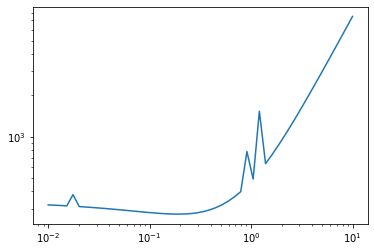

In [38]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(1.74775e-20)),
 (1, 0.011513953993264475, DM(7.89265e-20)),
 (2, 0.013257113655901088, DM(4.01071e-19)),
 (3, 0.015264179671752334, DM(2.30513e-18)),
 (4, 0.017575106248547922, DM(1.52659e-46)),
 (5, 0.020235896477251575, DM(1.11938e-16)),
 (6, 0.023299518105153717, DM(9.50101e-16)),
 (7, 0.02682695795279726, DM(9.19609e-15)),
 (8, 0.030888435964774818, DM(1.01162e-13)),
 (9, 0.03556480306223128, DM(1.25637e-12)),
 (10, 0.040949150623804255, DM(1.74111e-11)),
 (11, 0.04714866363457394, DM(2.64957e-10)),
 (12, 0.054286754393238594, DM(4.32533e-09)),
 (13, 0.06250551925273973, DM(7.91557e-08)),
 (14, 0.07196856730011521, DM(1.40037e-06)),
 (15, 0.08286427728546843, DM(2.35018e-05)),
 (16, 0.09540954763499938, DM(0.000349783)),
 (17, 0.10985411419875583, DM(0.00424402)),
 (18, 0.12648552168552957, DM(0.0378152)),
 (19, 0.14563484775012436, DM(0.217593)),
 (20, 0.16768329368110083, DM(0.690964)),
 (21, 0.19306977288832497, DM(1)),
 (22, 0.22229964825261944, DM(0.522963)),
 (2

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

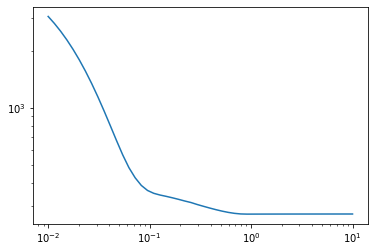

In [41]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(0)),
 (1, 0.011513953993264475, DM(0)),
 (2, 0.013257113655901088, DM(0)),
 (3, 0.015264179671752334, DM(0)),
 (4, 0.017575106248547922, DM(0)),
 (5, 0.020235896477251575, DM(0)),
 (6, 0.023299518105153717, DM(0)),
 (7, 0.02682695795279726, DM(0)),
 (8, 0.030888435964774818, DM(0)),
 (9, 0.03556480306223128, DM(3.09304e-300)),
 (10, 0.040949150623804255, DM(1.71909e-231)),
 (11, 0.04714866363457394, DM(1.61929e-173)),
 (12, 0.054286754393238594, DM(1.26817e-126)),
 (13, 0.06250551925273973, DM(2.52982e-91)),
 (14, 0.07196856730011521, DM(4.77624e-67)),
 (15, 0.08286427728546843, DM(1.95623e-50)),
 (16, 0.09540954763499938, DM(2.02281e-40)),
 (17, 0.10985411419875583, DM(5.07303e-35)),
 (18, 0.12648552168552957, DM(7.08622e-32)),
 (19, 0.14563484775012436, DM(1.82308e-29)),
 (20, 0.16768329368110083, DM(7.03204e-27)),
 (21, 0.19306977288832497, DM(3.8125e-24)),
 (22, 0.22229964825261944, DM(2.67201e-21)),
 (23, 0.2559547922699536, DM(9.67723e-19)),
 (24, 0.2947051702551809

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[9931.6076139952, 9410.733965672795, 9471.51351665135, 9834.689852308002]

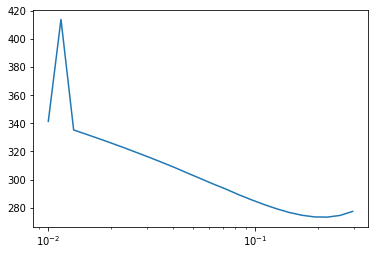

In [47]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [49]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

87.27272727272727


In [50]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(7174.53), DM(772.944), DM(549.674), DM(1019.9), DM(1848.19)]

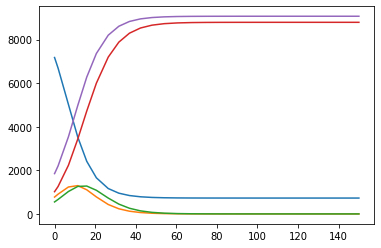

In [51]:
plt.plot(sol.t, sol.y[:,:].T)

In [52]:
model.observation_times[-1]

150.0

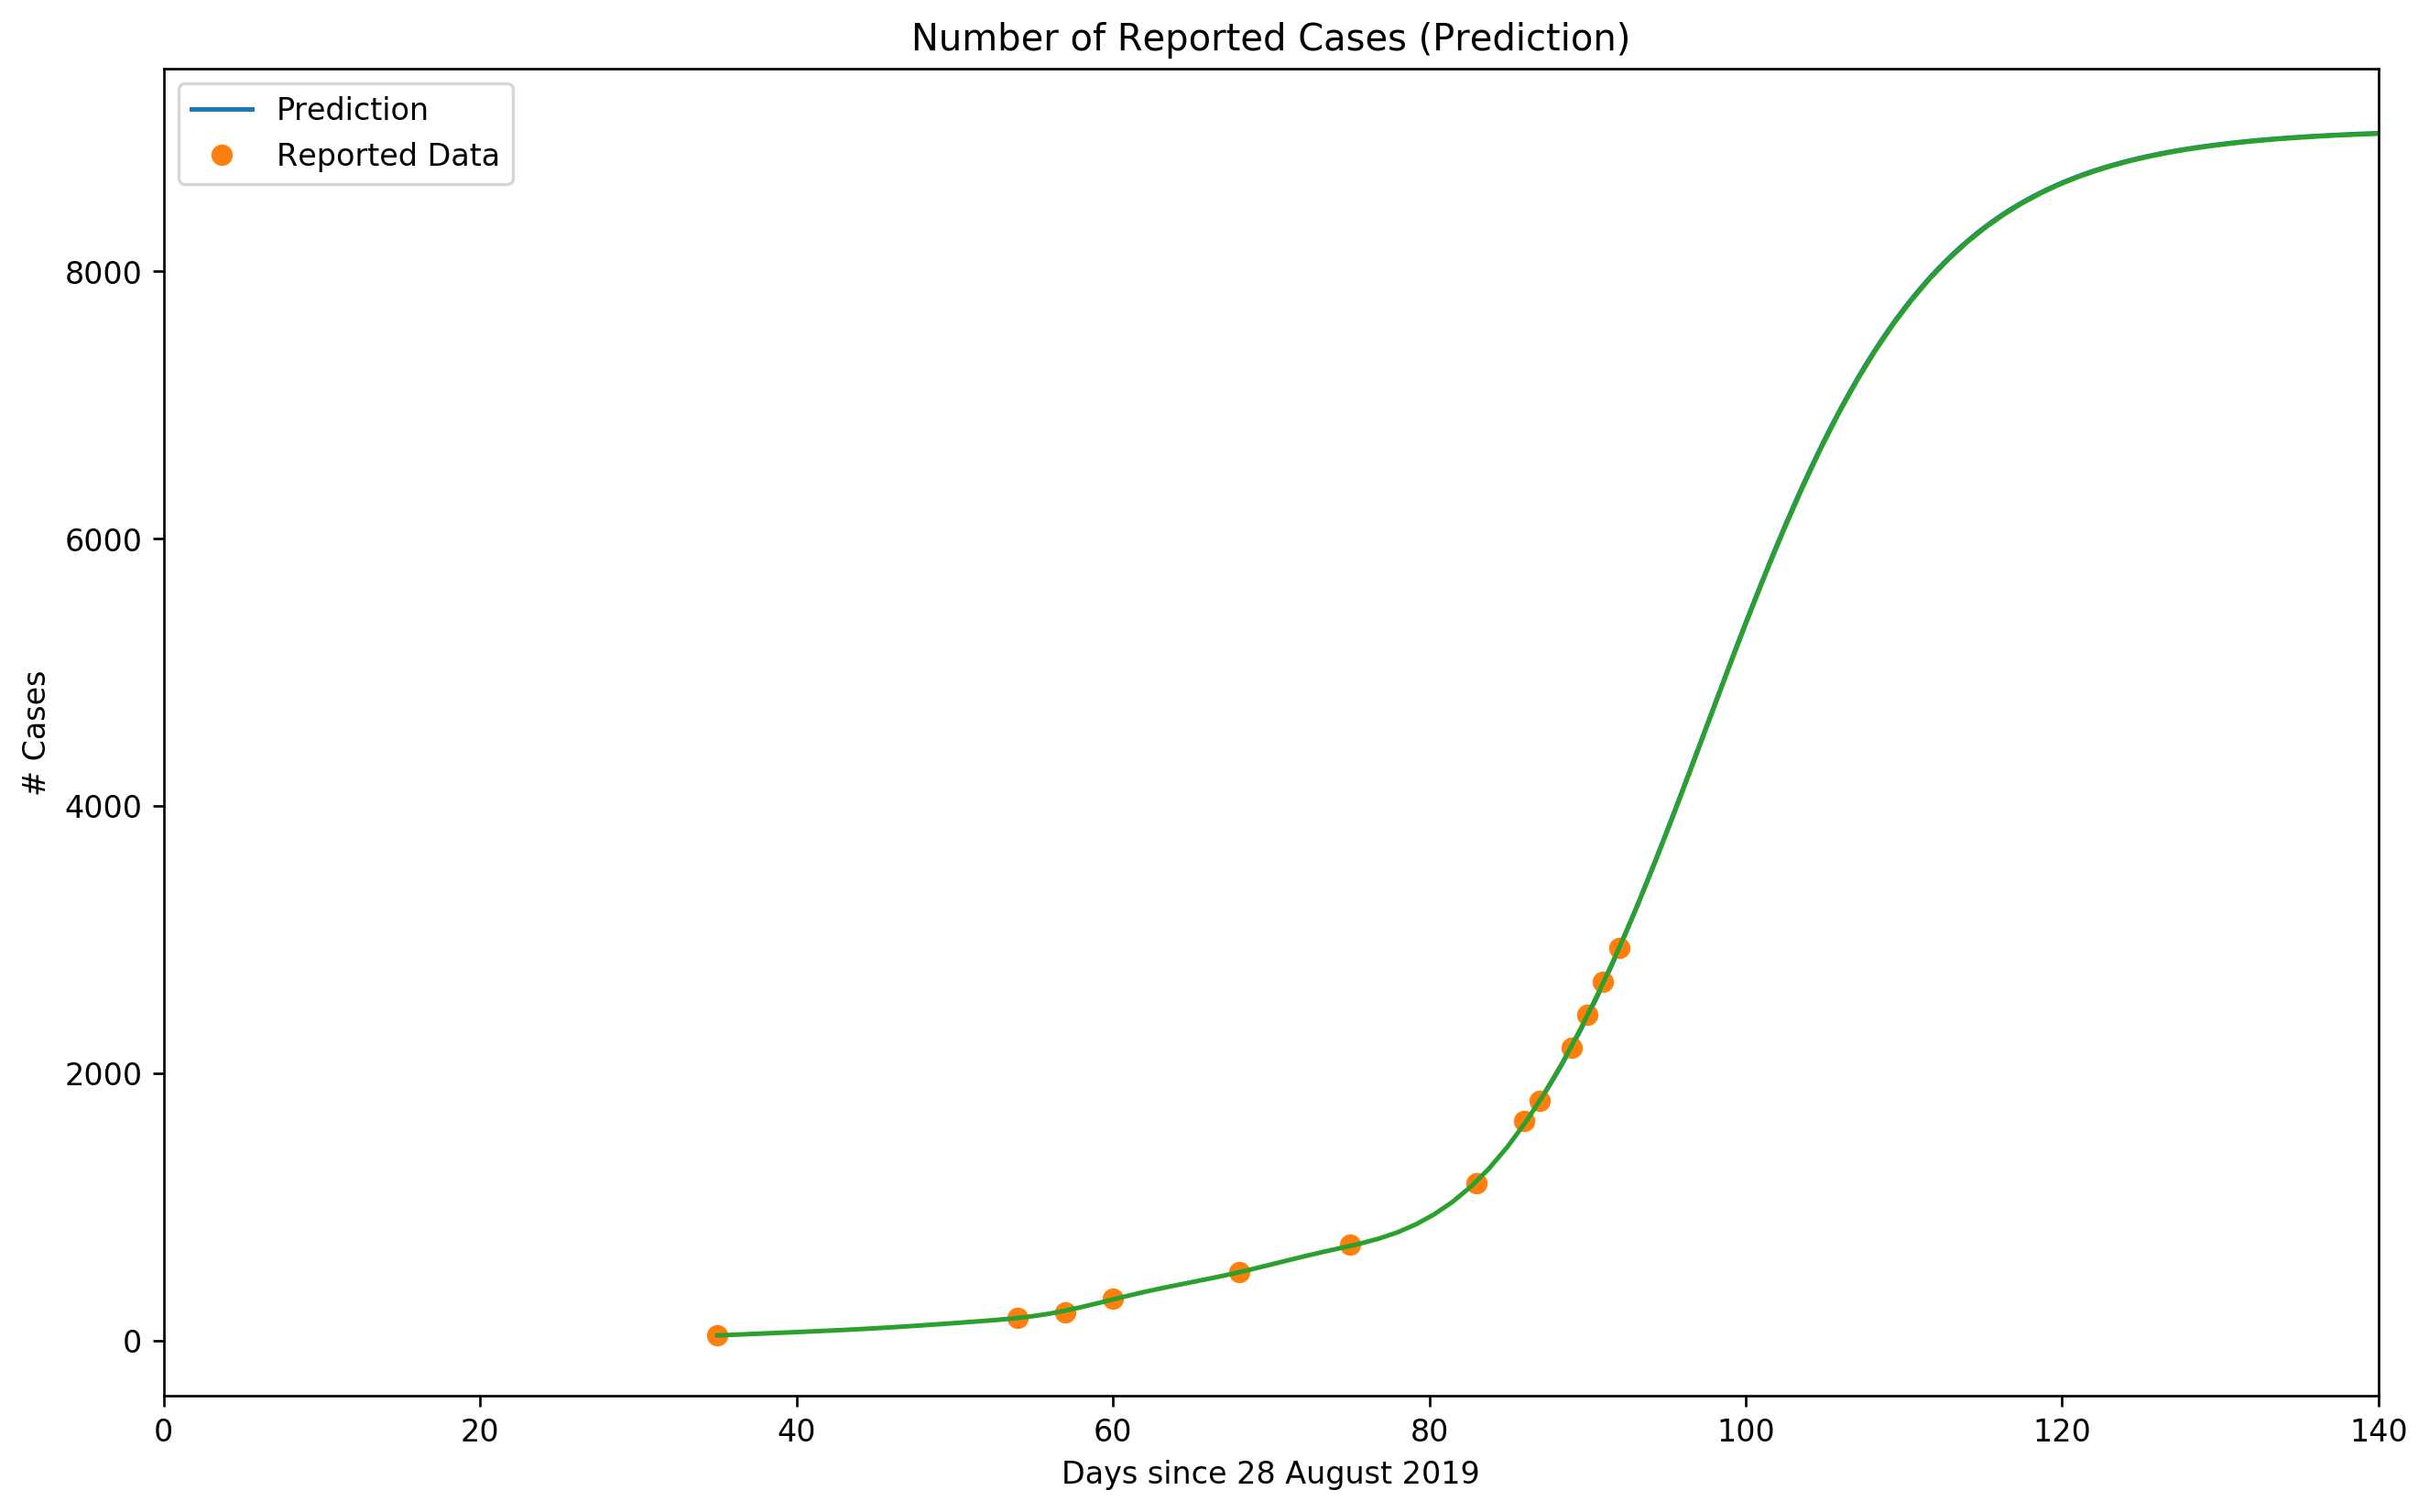

In [53]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [54]:
rfin = sol.sol(tfine)[-1,-1]
rfin

9068.01785731103

In [55]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [56]:
tfine[ridx]

31.803005008347245

In [57]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-30.92426771892549

In [58]:
model.observation_times[-1]-model.observation_times[tidx]

62.727272727272734

In [59]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

0.02 0.02826975476839237


In [60]:
rfin*historical_mortality

181.3603571462206

In [61]:
rfin*current_mortality

256.35064106158563

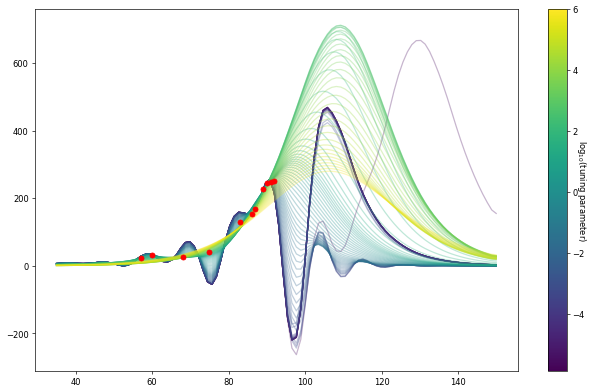

In [62]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, np.gradient(getx(sols[i]['x'])[4].toarray().flatten(), model.observation_times),
            color=scalarMap.to_rgba(np.log10(p)), alpha=0.3)
plt.plot(times, np.gradient(cumdata, times), 'ro')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)